In [17]:
import os
import json
import torch
import torch.nn.functional as F 
from torch_geometric.data import Dataset, Data

class SingleFileEmbeddingPairDataset(Dataset):
    def __init__(self, json_path, feature_idx=None):
        super().__init__(os.path.dirname(json_path))
        # Load dataset (dict of model pairs)
        with open(json_path, 'r') as f:
            model_dict = json.load(f)
            self.all_pairs = [pair for _, pair in model_dict.items()]
        # Store which feature columns to use (e.g., first 4)
        self.feature_idx = feature_idx if feature_idx is not None else list(range(16))

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, idx):
        pair = self.all_pairs[idx]

        # --- Load node features for A ---
        A_ids = sorted(pair['A_embeddings'].keys(), key=lambda x: int(x))
        xA = torch.tensor(
            [pair['A_embeddings'][aid] for aid in A_ids],
            dtype=torch.float
        )[:, self.feature_idx]  # <-- Only use selected features

        # --- Load node features for B ---
        B_ids = sorted(pair['B_embeddings'].keys(), key=lambda x: int(x))
        xB = torch.tensor(
            [pair['B_embeddings'][bid] for bid in B_ids],
            dtype=torch.float
        )[:, self.feature_idx]  # <-- Only use selected features

        # feature sub-selection already done
        # z-score per column (use float64 -> cast to float32 later if needed)
        xA = (xA - xA.mean(dim=0, keepdim=True)) / (xA.std(dim=0, keepdim=True) + 1e-8)
        xB = (xB - xB.mean(dim=0, keepdim=True)) / (xB.std(dim=0, keepdim=True) + 1e-8)

        # or do row L2 norm:
        xA = F.normalize(xA, p=2, dim=1)
        xB = F.normalize(xB, p=2, dim=1)



        # --- Node ID → index maps ---
        A_id_to_idx = {int(aid): i for i, aid in enumerate(A_ids)}
        B_id_to_idx = {int(bid): i for i, bid in enumerate(B_ids)}

        # --- Load edges (make undirected) ---
        def convert_edges(edge_list, id_to_idx):
            edges = []
            for a, b in edge_list:
                if a in id_to_idx and b in id_to_idx:
                    edges.append([id_to_idx[a], id_to_idx[b]])
                    edges.append([id_to_idx[b], id_to_idx[a]])
            return torch.tensor(edges, dtype=torch.long).t().contiguous() \
                   if edges else torch.empty((2, 0), dtype=torch.long)

        A_edges_raw = pair.get("A_edges", [])
        B_edges_raw = pair.get("B_edges", [])
        edge_indexA = convert_edges(A_edges_raw, A_id_to_idx)
        edge_indexB = convert_edges(B_edges_raw, B_id_to_idx)

        # --- Build mapping tensor ---
        mappings = []
        for a, b in pair['mappings']:
            idx_a = -1 if a == "NULL" else A_id_to_idx.get(int(a), -1)
            idx_b = -1 if b == "NULL" else B_id_to_idx.get(int(b), -1)
            mappings.append([idx_a, idx_b])
        matches = torch.tensor(mappings, dtype=torch.long)

        # --- Return graph data ---
        dataA = Data(x=xA, edge_index=edge_indexA, xt_entity_ids=A_ids)
        dataB = Data(x=xB, edge_index=edge_indexB, xt_entity_ids=B_ids)
        return dataA, dataB, matches


In [20]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch_geometric.nn import SAGEConv 
class GraphEncoder(nn.Module): 
    def __init__(self, input_dim, hidden_dim, out_dim): 
        super().__init__() 
        self.conv1 = SAGEConv(input_dim, hidden_dim) 
        self.conv2 = SAGEConv(hidden_dim, hidden_dim) 
        self.conv3 = SAGEConv(hidden_dim, hidden_dim) 
        self.conv4 = SAGEConv(hidden_dim, out_dim)
    def forward(self, x, edge_index): 
        x = F.relu(self.conv1(x, edge_index)) 
        x = F.relu(self.conv2(x, edge_index)) 
        x = self.conv3(x, edge_index)
    
        return x 
class SiameseGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, proj_dim=64): 
        super().__init__() 
        self.encoder = GraphEncoder(in_dim, hidden_dim, out_dim) 
        self.projector = nn.Sequential(
            nn.Linear(out_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )
    def forward(self, data1, data2): 
        h1 = self.encoder(data1.x, data1.edge_index) # [N1, out_dim] 
        h2 = self.encoder(data2.x, data2.edge_index) # [N2, out_dim]
        z1 = F.normalize(self.projector(h1), dim=1)
        z2 = F.normalize(self.projector(h2), dim=1)

        return h1, h2, z1, z2

In [ ]:
import torch
import torch.nn.functional as F

def info_nce_loss(z1, z2, matches_pos, temperature=0.1):
    # z1: [N1, D], z2: [N2, D]
    # matches_pos: [K,2] indices of positives
    if matches_pos.numel() == 0:
        return (z1.sum() * 0.0) + (z2.sum() * 0.0)
    device = z1.device
    # For each positive (i,j), compute logits of z1[i] with all z2
    sims = torch.matmul(z1, z2.t()) / temperature  # [N1, N2]
    # Compute loss only for anchors present in matches_pos
    loss = 0.0
    for a_idx, b_idx in matches_pos.tolist():
        logits = sims[a_idx]  # [N2]
        # target is index b_idx
        loss += F.cross_entropy(logits.unsqueeze(0), torch.tensor([b_idx], device=device))
    return loss / matches_pos.size(0)



# --- Random negative sampling ---
def get_random_negatives(matches_pos, emb1_size, emb2_size, num_neg=None):
    num_pos = matches_pos.size(0)
    num_neg = num_neg or num_pos

    rand_A = torch.randint(0, emb1_size, (num_neg,), device=emb1.device)
    rand_B = torch.randint(0, emb2_size, (num_neg,), device=emb1.device)

    mask = torch.ones(num_neg, dtype=torch.bool)
    pos_set = set(map(tuple, matches_pos.tolist()))
    for i in range(num_neg):
        if (rand_A[i].item(), rand_B[i].item()) in pos_set:
            mask[i] = False
    return torch.stack([rand_A[mask], rand_B[mask]], dim=1)


# --- Hard negative sampling ---
def get_hard_negatives(emb1, emb2, matches_pos, top_k=3):
    """
    Select hardest negatives (closest embeddings not in positive set)
    """
    with torch.no_grad():
        dist = torch.cdist(emb1, emb2, p=2)  # [N1, N2]
        pos_mask = torch.zeros_like(dist, dtype=torch.bool)
        pos_mask[matches_pos[:, 0], matches_pos[:, 1]] = True
        dist[pos_mask] = 1e6  # mask out positives

        # Select top-k smallest distances as negatives
        neg_indices = dist.topk(k=top_k, largest=False).indices  # [N1, top_k]
        matches_neg = []
        for i in range(neg_indices.size(0)):
            for j in neg_indices[i]:
                matches_neg.append([i, j.item()])
        matches_neg = torch.tensor(matches_neg, dtype=torch.long, device=emb1.device)
    return matches_neg


# --- Mixed negative sampling (recommended) ---
def get_mixed_negatives(emb1, emb2, matches_pos, ratio=0.5, top_k=3):
    """
    Combines random + hard negatives
    """
    hard_negs = get_hard_negatives(emb1, emb2, matches_pos, top_k)
    rand_negs = get_random_negatives(matches_pos, emb1.size(0), emb2.size(0))

    hard_negs = hard_negs.to(emb1.device)
    rand_negs = rand_negs.to(emb1.device)
    num_hard = int(ratio * min(len(hard_negs), len(rand_negs)))
    if num_hard == 0:
        return rand_negs
    mixed = torch.cat([hard_negs[:num_hard], rand_negs[:num_hard]], dim=0)
    return mixed



In [22]:
def null_penalty_loss(z_null, z_others, margin_neg=0.4):
    # z_null: [M, D] (NULL anchors)
    # z_others: [N, D] (candidate set)
    # We want max similarity to be < -margin_neg (or below some threshold)
    sims = torch.matmul(z_null, z_others.t())  # cosine if z normalized
    # penalize large similarities; we want sims to be small
    # Softplus on sims - target low
    return F.softplus(sims).mean()   # alternative: F.relu(sims - threshold).mean()


In [12]:
def batch_accuracy(emb1, emb2, matches):
    # emb1: [N1, D], emb2: [N2, D], matches: [K,2]
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None  # avoid NaN

    dists = torch.cdist(emb1, emb2)  # [N1, N2]
    # For each ground-truth emb1 index, which emb2 is closest
    min_indices = torch.argmin(dists[indices1], dim=1)
    correct = (min_indices == indices2).float()
    return correct.mean().item()

In [5]:
def batch_topk_accuracy(emb1, emb2, matches, k=5):
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None

    dists = torch.cdist(emb1, emb2)

    actual_k = min(k, emb2.shape[0])
    if actual_k == 0:
        return None  # no candidates

    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices
    correct = torch.any(topk == indices2.unsqueeze(1), dim=1).float()
    return correct.mean().item()

In [13]:
def batch_f1_score(emb1, emb2, matches, threshold=0.7):
    """Compute F1 score for one pair based on cosine similarity."""
    sim = F.cosine_similarity(
        emb1.unsqueeze(1), emb2.unsqueeze(0), dim=-1
    )  # shape: [N1, N2]
    preds = (sim > threshold).float()

    # Ground truth
    gt = torch.zeros_like(preds)
    for a, b in matches:
        if a != -1 and b != -1:
            gt[a, b] = 1.0

    TP = (preds * gt).sum().item()
    FP = (preds * (1 - gt)).sum().item()
    FN = ((1 - preds) * gt).sum().item()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return f1


In [14]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

#  Load dataset
dataset = SingleFileEmbeddingPairDataset("C:\\Users\\Z0054udc\\Downloads\\Siamese GNN\\XT_merged_new1_doubled_fixed.json", feature_idx=list(range(16))) # Use first 4 features only
print(f"Found {len(dataset)} dataset entries.")
if len(dataset) == 0:
    raise ValueError("ERROR: No JSON files found!")

#  Device setup
device = torch.device('cpu')
print("Using device:", device)

#  Model and optimizer
model = SiameseGNN(in_dim=16, hidden_dim=64, out_dim=32).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2, weight_decay=1e-4)


#  Training hyperparameters
epochs = 1000
grad_accum_steps = 8        # Simulates batch size = 8
loss_history, top1_history, top5_history, f1_history = [], [], [], []

#  Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_f1 = 0.0
    num_acc = 0
    optimizer.zero_grad()

    for i in tqdm(range(len(dataset)), desc=f"Epoch {epoch+1}"):
        data1, data2, matches = dataset[i]
        data1, data2, matches = data1.to(device), data2.to(device), matches.to(device)

        # Forward pass for this pair
        emb1, emb2 = model(data1, data2)
        matches_pos = matches[(matches[:, 0] != -1) & (matches[:, 1] != -1)]
        matches_neg = get_mixed_negatives(emb1, emb2, matches_pos, ratio=0.5, top_k=3)
        loss = contrastive_margin_loss(emb1, emb2, matches_pos, matches_neg)
        loss.backward()

        total_loss += loss.item()

        # --- Accuracy tracking
        acc1 = batch_accuracy(emb1, emb2, matches)
        acc5 = batch_topk_accuracy(emb1, emb2, matches, k=5)
        f1 = batch_f1_score(emb1, emb2, matches)
        if acc1 is not None and acc5 is not None:
            total_top1 += acc1
            total_top5 += acc5
            total_f1 += f1
            num_acc += 1

        # --- Gradient accumulation ---
        if (i + 1) % grad_accum_steps == 0 or (i + 1) == len(dataset):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            optimizer.zero_grad()

    # ---- Epoch summary ----
    avg_loss = total_loss / len(dataset)
    avg_top1 = (total_top1 / num_acc) * 100 if num_acc > 0 else 0.0
    avg_top5 = (total_top5 / num_acc) * 100 if num_acc > 0 else 0.0
    avg_f1 = (total_f1 / num_acc) * 100 if num_acc > 0 else 0.0
    
    f1_history.append(avg_f1)
    loss_history.append(avg_loss)
    top1_history.append(avg_top1)
    top5_history.append(avg_top5)

    print(f"Epoch {epoch+1:03d}: Loss = {avg_loss:.4f}, Top-1 = {avg_top1:.2f}%, Top-5 = {avg_top5:.2f}%, F1 = {avg_f1:.2f}%")



Found 134 dataset entries.
Using device: cpu


Epoch 1: 100%|██████████| 134/134 [00:02<00:00, 66.16it/s]


Epoch 001: Loss = 2.6048, Top-1 = 24.18%, Top-5 = 59.20%, F1 = 7.99%


Epoch 2: 100%|██████████| 134/134 [00:01<00:00, 87.83it/s] 


Epoch 002: Loss = 2.4515, Top-1 = 23.46%, Top-5 = 57.65%, F1 = 10.75%


Epoch 3: 100%|██████████| 134/134 [00:01<00:00, 96.52it/s] 


Epoch 003: Loss = 2.4333, Top-1 = 23.03%, Top-5 = 59.49%, F1 = 10.00%


Epoch 4: 100%|██████████| 134/134 [00:01<00:00, 91.68it/s] 


Epoch 004: Loss = 2.3142, Top-1 = 23.74%, Top-5 = 61.96%, F1 = 11.29%


Epoch 5: 100%|██████████| 134/134 [00:01<00:00, 95.78it/s] 


Epoch 005: Loss = 2.2577, Top-1 = 24.89%, Top-5 = 62.79%, F1 = 13.55%


Epoch 6: 100%|██████████| 134/134 [00:01<00:00, 92.37it/s] 


Epoch 006: Loss = 2.1548, Top-1 = 26.24%, Top-5 = 63.95%, F1 = 13.49%


Epoch 7: 100%|██████████| 134/134 [00:01<00:00, 99.04it/s] 


Epoch 007: Loss = 2.1366, Top-1 = 27.72%, Top-5 = 66.04%, F1 = 13.53%


Epoch 8: 100%|██████████| 134/134 [00:01<00:00, 96.89it/s] 


Epoch 008: Loss = 2.1112, Top-1 = 28.11%, Top-5 = 65.47%, F1 = 14.62%


Epoch 9: 100%|██████████| 134/134 [00:01<00:00, 97.03it/s] 


Epoch 009: Loss = 2.0858, Top-1 = 27.91%, Top-5 = 65.86%, F1 = 13.83%


Epoch 10: 100%|██████████| 134/134 [00:01<00:00, 86.19it/s] 


Epoch 010: Loss = 2.1149, Top-1 = 27.42%, Top-5 = 66.02%, F1 = 13.27%


Epoch 11: 100%|██████████| 134/134 [00:01<00:00, 94.53it/s] 


Epoch 011: Loss = 2.1304, Top-1 = 27.14%, Top-5 = 68.08%, F1 = 14.31%


Epoch 12: 100%|██████████| 134/134 [00:01<00:00, 89.53it/s]


Epoch 012: Loss = 2.0970, Top-1 = 27.89%, Top-5 = 67.43%, F1 = 13.88%


Epoch 13: 100%|██████████| 134/134 [00:01<00:00, 99.48it/s] 


Epoch 013: Loss = 2.1177, Top-1 = 29.28%, Top-5 = 67.36%, F1 = 13.77%


Epoch 14: 100%|██████████| 134/134 [00:01<00:00, 103.43it/s]


Epoch 014: Loss = 2.0303, Top-1 = 28.19%, Top-5 = 67.41%, F1 = 14.52%


Epoch 15: 100%|██████████| 134/134 [00:01<00:00, 103.96it/s]


Epoch 015: Loss = 2.0661, Top-1 = 28.31%, Top-5 = 67.77%, F1 = 15.72%


Epoch 16: 100%|██████████| 134/134 [00:01<00:00, 106.38it/s]


Epoch 016: Loss = 2.0688, Top-1 = 28.63%, Top-5 = 67.91%, F1 = 16.01%


Epoch 17: 100%|██████████| 134/134 [00:01<00:00, 93.28it/s] 


Epoch 017: Loss = 2.0473, Top-1 = 29.33%, Top-5 = 68.18%, F1 = 17.61%


Epoch 18: 100%|██████████| 134/134 [00:01<00:00, 106.27it/s]


Epoch 018: Loss = 1.9938, Top-1 = 29.00%, Top-5 = 68.78%, F1 = 17.18%


Epoch 19: 100%|██████████| 134/134 [00:01<00:00, 99.78it/s] 


Epoch 019: Loss = 1.9352, Top-1 = 29.26%, Top-5 = 68.73%, F1 = 17.91%


Epoch 20: 100%|██████████| 134/134 [00:01<00:00, 104.98it/s]


Epoch 020: Loss = 1.9683, Top-1 = 29.83%, Top-5 = 68.21%, F1 = 18.38%


Epoch 21: 100%|██████████| 134/134 [00:01<00:00, 106.18it/s]


Epoch 021: Loss = 1.9579, Top-1 = 28.89%, Top-5 = 68.25%, F1 = 18.24%


Epoch 22: 100%|██████████| 134/134 [00:01<00:00, 105.31it/s]


Epoch 022: Loss = 1.9193, Top-1 = 30.34%, Top-5 = 68.60%, F1 = 19.71%


Epoch 23: 100%|██████████| 134/134 [00:01<00:00, 106.56it/s]


Epoch 023: Loss = 1.8998, Top-1 = 29.79%, Top-5 = 69.05%, F1 = 19.00%


Epoch 24: 100%|██████████| 134/134 [00:01<00:00, 105.26it/s]


Epoch 024: Loss = 1.9314, Top-1 = 28.51%, Top-5 = 68.54%, F1 = 18.64%


Epoch 25: 100%|██████████| 134/134 [00:01<00:00, 100.03it/s]


Epoch 025: Loss = 1.9579, Top-1 = 30.05%, Top-5 = 69.19%, F1 = 18.28%


Epoch 26: 100%|██████████| 134/134 [00:01<00:00, 106.95it/s]


Epoch 026: Loss = 1.8904, Top-1 = 30.25%, Top-5 = 69.16%, F1 = 18.97%


Epoch 27: 100%|██████████| 134/134 [00:01<00:00, 105.18it/s]


Epoch 027: Loss = 1.9468, Top-1 = 31.64%, Top-5 = 69.22%, F1 = 18.79%


Epoch 28: 100%|██████████| 134/134 [00:01<00:00, 107.16it/s]


Epoch 028: Loss = 1.9155, Top-1 = 31.44%, Top-5 = 69.64%, F1 = 18.79%


Epoch 29: 100%|██████████| 134/134 [00:01<00:00, 107.55it/s]


Epoch 029: Loss = 1.9078, Top-1 = 31.44%, Top-5 = 69.48%, F1 = 19.27%


Epoch 30: 100%|██████████| 134/134 [00:01<00:00, 93.84it/s] 


Epoch 030: Loss = 1.8796, Top-1 = 30.55%, Top-5 = 69.58%, F1 = 19.14%


Epoch 31: 100%|██████████| 134/134 [00:01<00:00, 105.43it/s]


Epoch 031: Loss = 1.9210, Top-1 = 31.44%, Top-5 = 69.46%, F1 = 18.82%


Epoch 32: 100%|██████████| 134/134 [00:01<00:00, 100.49it/s]


Epoch 032: Loss = 1.9261, Top-1 = 30.40%, Top-5 = 68.98%, F1 = 19.12%


Epoch 33: 100%|██████████| 134/134 [00:01<00:00, 105.43it/s]


Epoch 033: Loss = 1.8282, Top-1 = 30.80%, Top-5 = 69.53%, F1 = 19.14%


Epoch 34: 100%|██████████| 134/134 [00:01<00:00, 104.85it/s]


Epoch 034: Loss = 1.8680, Top-1 = 30.06%, Top-5 = 68.87%, F1 = 19.98%


Epoch 35: 100%|██████████| 134/134 [00:01<00:00, 107.03it/s]


Epoch 035: Loss = 1.9016, Top-1 = 31.60%, Top-5 = 69.41%, F1 = 19.80%


Epoch 36: 100%|██████████| 134/134 [00:01<00:00, 106.77it/s]


Epoch 036: Loss = 1.8579, Top-1 = 31.03%, Top-5 = 69.74%, F1 = 20.11%


Epoch 37: 100%|██████████| 134/134 [00:01<00:00, 105.06it/s]


Epoch 037: Loss = 1.8829, Top-1 = 31.42%, Top-5 = 69.52%, F1 = 19.46%


Epoch 38: 100%|██████████| 134/134 [00:01<00:00, 102.49it/s]


Epoch 038: Loss = 1.8610, Top-1 = 30.78%, Top-5 = 69.62%, F1 = 19.56%


Epoch 39: 100%|██████████| 134/134 [00:01<00:00, 98.57it/s] 


Epoch 039: Loss = 1.8549, Top-1 = 31.71%, Top-5 = 69.84%, F1 = 19.62%


Epoch 40: 100%|██████████| 134/134 [00:01<00:00, 106.31it/s]


Epoch 040: Loss = 1.8531, Top-1 = 31.80%, Top-5 = 69.88%, F1 = 19.97%


Epoch 41: 100%|██████████| 134/134 [00:01<00:00, 107.12it/s]


Epoch 041: Loss = 1.8823, Top-1 = 31.36%, Top-5 = 69.77%, F1 = 19.92%


Epoch 42: 100%|██████████| 134/134 [00:01<00:00, 106.60it/s]


Epoch 042: Loss = 1.8426, Top-1 = 31.23%, Top-5 = 69.53%, F1 = 19.75%


Epoch 43: 100%|██████████| 134/134 [00:01<00:00, 95.25it/s] 


Epoch 043: Loss = 1.8521, Top-1 = 31.10%, Top-5 = 69.07%, F1 = 20.22%


Epoch 44: 100%|██████████| 134/134 [00:01<00:00, 106.91it/s]


Epoch 044: Loss = 1.8806, Top-1 = 31.25%, Top-5 = 69.21%, F1 = 20.45%


Epoch 45: 100%|██████████| 134/134 [00:01<00:00, 96.89it/s] 


Epoch 045: Loss = 1.8440, Top-1 = 31.02%, Top-5 = 69.58%, F1 = 19.60%


Epoch 46: 100%|██████████| 134/134 [00:01<00:00, 104.36it/s]


Epoch 046: Loss = 1.8719, Top-1 = 31.59%, Top-5 = 69.33%, F1 = 19.03%


Epoch 47: 100%|██████████| 134/134 [00:01<00:00, 106.06it/s]


Epoch 047: Loss = 1.8501, Top-1 = 31.25%, Top-5 = 69.98%, F1 = 20.05%


Epoch 48: 100%|██████████| 134/134 [00:01<00:00, 106.43it/s]


Epoch 048: Loss = 1.8370, Top-1 = 32.12%, Top-5 = 70.10%, F1 = 20.25%


Epoch 49: 100%|██████████| 134/134 [00:01<00:00, 90.35it/s]


Epoch 049: Loss = 1.8481, Top-1 = 31.87%, Top-5 = 69.20%, F1 = 20.75%


Epoch 50: 100%|██████████| 134/134 [00:01<00:00, 81.08it/s]


Epoch 050: Loss = 1.8599, Top-1 = 31.82%, Top-5 = 69.49%, F1 = 20.36%


Epoch 51: 100%|██████████| 134/134 [00:01<00:00, 79.82it/s]


Epoch 051: Loss = 1.8297, Top-1 = 32.06%, Top-5 = 70.42%, F1 = 20.43%


Epoch 52: 100%|██████████| 134/134 [00:01<00:00, 79.68it/s]


Epoch 052: Loss = 1.8048, Top-1 = 31.32%, Top-5 = 69.75%, F1 = 20.55%


Epoch 53: 100%|██████████| 134/134 [00:01<00:00, 80.11it/s]


Epoch 053: Loss = 1.7707, Top-1 = 31.83%, Top-5 = 70.50%, F1 = 21.09%


Epoch 54: 100%|██████████| 134/134 [00:01<00:00, 77.94it/s]


Epoch 054: Loss = 1.8778, Top-1 = 32.05%, Top-5 = 70.43%, F1 = 20.47%


Epoch 55: 100%|██████████| 134/134 [00:01<00:00, 80.85it/s]


Epoch 055: Loss = 1.8243, Top-1 = 31.41%, Top-5 = 69.13%, F1 = 21.21%


Epoch 56: 100%|██████████| 134/134 [00:01<00:00, 73.05it/s]


Epoch 056: Loss = 1.7828, Top-1 = 31.84%, Top-5 = 69.85%, F1 = 21.36%


Epoch 57: 100%|██████████| 134/134 [00:01<00:00, 88.21it/s] 


Epoch 057: Loss = 1.8001, Top-1 = 32.44%, Top-5 = 69.78%, F1 = 21.07%


Epoch 58: 100%|██████████| 134/134 [00:01<00:00, 86.02it/s] 


Epoch 058: Loss = 1.7836, Top-1 = 32.55%, Top-5 = 70.64%, F1 = 21.63%


Epoch 59: 100%|██████████| 134/134 [00:01<00:00, 90.37it/s] 


Epoch 059: Loss = 1.8235, Top-1 = 32.16%, Top-5 = 70.33%, F1 = 20.45%


Epoch 60: 100%|██████████| 134/134 [00:01<00:00, 85.10it/s]


Epoch 060: Loss = 1.7766, Top-1 = 32.57%, Top-5 = 70.56%, F1 = 21.56%


Epoch 61: 100%|██████████| 134/134 [00:01<00:00, 88.72it/s] 


Epoch 061: Loss = 1.7896, Top-1 = 32.23%, Top-5 = 70.33%, F1 = 21.52%


Epoch 62: 100%|██████████| 134/134 [00:01<00:00, 88.11it/s] 


Epoch 062: Loss = 1.7810, Top-1 = 32.35%, Top-5 = 70.64%, F1 = 21.49%


Epoch 63: 100%|██████████| 134/134 [00:01<00:00, 89.75it/s] 


Epoch 063: Loss = 1.7931, Top-1 = 32.82%, Top-5 = 70.16%, F1 = 22.76%


Epoch 64: 100%|██████████| 134/134 [00:01<00:00, 86.00it/s] 


Epoch 064: Loss = 1.7744, Top-1 = 32.92%, Top-5 = 70.61%, F1 = 22.48%


Epoch 65: 100%|██████████| 134/134 [00:01<00:00, 98.02it/s] 


Epoch 065: Loss = 1.7763, Top-1 = 32.23%, Top-5 = 70.72%, F1 = 23.00%


Epoch 66: 100%|██████████| 134/134 [00:01<00:00, 90.59it/s] 


Epoch 066: Loss = 1.7618, Top-1 = 33.07%, Top-5 = 70.72%, F1 = 23.37%


Epoch 67: 100%|██████████| 134/134 [00:01<00:00, 97.52it/s] 


Epoch 067: Loss = 1.7466, Top-1 = 32.83%, Top-5 = 71.08%, F1 = 23.02%


Epoch 68: 100%|██████████| 134/134 [00:01<00:00, 99.81it/s] 


Epoch 068: Loss = 1.7678, Top-1 = 32.23%, Top-5 = 70.08%, F1 = 23.30%


Epoch 69: 100%|██████████| 134/134 [00:01<00:00, 80.21it/s]


Epoch 069: Loss = 1.7639, Top-1 = 33.18%, Top-5 = 71.66%, F1 = 23.21%


Epoch 70: 100%|██████████| 134/134 [00:01<00:00, 83.71it/s]


Epoch 070: Loss = 1.7623, Top-1 = 32.34%, Top-5 = 70.78%, F1 = 22.63%


Epoch 71: 100%|██████████| 134/134 [00:01<00:00, 88.14it/s]


Epoch 071: Loss = 1.7949, Top-1 = 32.99%, Top-5 = 70.63%, F1 = 22.13%


Epoch 72: 100%|██████████| 134/134 [00:01<00:00, 92.56it/s]


Epoch 072: Loss = 1.7667, Top-1 = 32.71%, Top-5 = 70.39%, F1 = 22.54%


Epoch 73: 100%|██████████| 134/134 [00:01<00:00, 95.46it/s] 


Epoch 073: Loss = 1.7208, Top-1 = 32.87%, Top-5 = 71.35%, F1 = 23.04%


Epoch 74: 100%|██████████| 134/134 [00:01<00:00, 97.99it/s] 


Epoch 074: Loss = 1.7652, Top-1 = 32.17%, Top-5 = 71.55%, F1 = 23.17%


Epoch 75: 100%|██████████| 134/134 [00:01<00:00, 96.64it/s] 


Epoch 075: Loss = 1.7397, Top-1 = 32.53%, Top-5 = 70.76%, F1 = 23.81%


Epoch 76: 100%|██████████| 134/134 [00:01<00:00, 94.70it/s] 


Epoch 076: Loss = 1.7318, Top-1 = 32.97%, Top-5 = 71.21%, F1 = 23.19%


Epoch 77: 100%|██████████| 134/134 [00:01<00:00, 106.78it/s]


Epoch 077: Loss = 1.7196, Top-1 = 33.35%, Top-5 = 70.98%, F1 = 23.75%


Epoch 78: 100%|██████████| 134/134 [00:01<00:00, 106.65it/s]


Epoch 078: Loss = 1.7386, Top-1 = 33.21%, Top-5 = 70.52%, F1 = 24.52%


Epoch 79: 100%|██████████| 134/134 [00:01<00:00, 104.28it/s]


Epoch 079: Loss = 1.7524, Top-1 = 32.75%, Top-5 = 70.79%, F1 = 23.67%


Epoch 80: 100%|██████████| 134/134 [00:01<00:00, 106.95it/s]


Epoch 080: Loss = 1.7556, Top-1 = 32.71%, Top-5 = 71.66%, F1 = 24.04%


Epoch 81: 100%|██████████| 134/134 [00:01<00:00, 106.18it/s]


Epoch 081: Loss = 1.7657, Top-1 = 32.46%, Top-5 = 71.18%, F1 = 23.58%


Epoch 82: 100%|██████████| 134/134 [00:01<00:00, 87.66it/s] 


Epoch 082: Loss = 1.7407, Top-1 = 33.23%, Top-5 = 71.27%, F1 = 24.23%


Epoch 83: 100%|██████████| 134/134 [00:01<00:00, 103.24it/s]


Epoch 083: Loss = 1.7245, Top-1 = 33.04%, Top-5 = 71.01%, F1 = 25.21%


Epoch 84: 100%|██████████| 134/134 [00:01<00:00, 107.59it/s]


Epoch 084: Loss = 1.7123, Top-1 = 33.11%, Top-5 = 71.16%, F1 = 24.80%


Epoch 85: 100%|██████████| 134/134 [00:01<00:00, 107.93it/s]


Epoch 085: Loss = 1.7155, Top-1 = 32.74%, Top-5 = 71.64%, F1 = 24.88%


Epoch 86: 100%|██████████| 134/134 [00:01<00:00, 103.00it/s]


Epoch 086: Loss = 1.7705, Top-1 = 33.56%, Top-5 = 70.81%, F1 = 24.90%


Epoch 87: 100%|██████████| 134/134 [00:01<00:00, 103.19it/s]


Epoch 087: Loss = 1.7184, Top-1 = 32.52%, Top-5 = 70.78%, F1 = 25.31%


Epoch 88: 100%|██████████| 134/134 [00:01<00:00, 99.89it/s] 


Epoch 088: Loss = 1.7244, Top-1 = 32.87%, Top-5 = 70.63%, F1 = 24.33%


Epoch 89: 100%|██████████| 134/134 [00:01<00:00, 100.68it/s]


Epoch 089: Loss = 1.7239, Top-1 = 32.46%, Top-5 = 70.77%, F1 = 24.64%


Epoch 90: 100%|██████████| 134/134 [00:01<00:00, 101.71it/s]


Epoch 090: Loss = 1.7265, Top-1 = 33.68%, Top-5 = 72.31%, F1 = 25.01%


Epoch 91: 100%|██████████| 134/134 [00:01<00:00, 106.31it/s]


Epoch 091: Loss = 1.6998, Top-1 = 33.44%, Top-5 = 71.44%, F1 = 25.08%


Epoch 92: 100%|██████████| 134/134 [00:01<00:00, 104.33it/s]


Epoch 092: Loss = 1.7178, Top-1 = 33.20%, Top-5 = 71.77%, F1 = 25.04%


Epoch 93: 100%|██████████| 134/134 [00:01<00:00, 105.97it/s]


Epoch 093: Loss = 1.7197, Top-1 = 33.48%, Top-5 = 72.31%, F1 = 25.51%


Epoch 94: 100%|██████████| 134/134 [00:01<00:00, 93.08it/s] 


Epoch 094: Loss = 1.7458, Top-1 = 33.15%, Top-5 = 71.52%, F1 = 25.73%


Epoch 95: 100%|██████████| 134/134 [00:01<00:00, 83.14it/s] 


Epoch 095: Loss = 1.6902, Top-1 = 33.57%, Top-5 = 71.83%, F1 = 25.98%


Epoch 96: 100%|██████████| 134/134 [00:01<00:00, 99.70it/s] 


Epoch 096: Loss = 1.6909, Top-1 = 33.46%, Top-5 = 71.41%, F1 = 25.79%


Epoch 97: 100%|██████████| 134/134 [00:01<00:00, 99.81it/s] 


Epoch 097: Loss = 1.6869, Top-1 = 33.25%, Top-5 = 72.16%, F1 = 25.43%


Epoch 98: 100%|██████████| 134/134 [00:01<00:00, 102.60it/s]


Epoch 098: Loss = 1.7018, Top-1 = 33.72%, Top-5 = 72.22%, F1 = 25.26%


Epoch 99: 100%|██████████| 134/134 [00:01<00:00, 106.04it/s]


Epoch 099: Loss = 1.6887, Top-1 = 33.48%, Top-5 = 72.63%, F1 = 25.89%


Epoch 100: 100%|██████████| 134/134 [00:01<00:00, 103.52it/s]


Epoch 100: Loss = 1.6650, Top-1 = 33.21%, Top-5 = 72.15%, F1 = 25.68%


Epoch 101: 100%|██████████| 134/134 [00:01<00:00, 96.51it/s] 


Epoch 101: Loss = 1.7013, Top-1 = 33.08%, Top-5 = 71.72%, F1 = 25.53%


Epoch 102: 100%|██████████| 134/134 [00:01<00:00, 103.07it/s]


Epoch 102: Loss = 1.6792, Top-1 = 34.26%, Top-5 = 72.10%, F1 = 24.88%


Epoch 103: 100%|██████████| 134/134 [00:01<00:00, 100.33it/s]


Epoch 103: Loss = 1.6802, Top-1 = 33.83%, Top-5 = 71.30%, F1 = 26.14%


Epoch 104: 100%|██████████| 134/134 [00:01<00:00, 89.23it/s] 


Epoch 104: Loss = 1.6530, Top-1 = 34.34%, Top-5 = 72.16%, F1 = 25.92%


Epoch 105: 100%|██████████| 134/134 [00:01<00:00, 95.53it/s] 


Epoch 105: Loss = 1.6819, Top-1 = 34.05%, Top-5 = 72.26%, F1 = 26.09%


Epoch 106: 100%|██████████| 134/134 [00:01<00:00, 94.29it/s] 


Epoch 106: Loss = 1.7014, Top-1 = 33.50%, Top-5 = 71.88%, F1 = 26.45%


Epoch 107: 100%|██████████| 134/134 [00:01<00:00, 101.43it/s]


Epoch 107: Loss = 1.6775, Top-1 = 34.66%, Top-5 = 72.67%, F1 = 26.34%


Epoch 108: 100%|██████████| 134/134 [00:01<00:00, 87.77it/s] 


Epoch 108: Loss = 1.6814, Top-1 = 33.79%, Top-5 = 71.87%, F1 = 26.22%


Epoch 109: 100%|██████████| 134/134 [00:01<00:00, 102.87it/s]


Epoch 109: Loss = 1.6652, Top-1 = 34.03%, Top-5 = 72.35%, F1 = 26.58%


Epoch 110: 100%|██████████| 134/134 [00:01<00:00, 100.90it/s]


Epoch 110: Loss = 1.6567, Top-1 = 33.41%, Top-5 = 72.27%, F1 = 26.77%


Epoch 111: 100%|██████████| 134/134 [00:01<00:00, 100.11it/s]


Epoch 111: Loss = 1.7066, Top-1 = 33.35%, Top-5 = 72.03%, F1 = 26.25%


Epoch 112: 100%|██████████| 134/134 [00:01<00:00, 89.98it/s] 


Epoch 112: Loss = 1.6873, Top-1 = 33.62%, Top-5 = 72.44%, F1 = 26.18%


Epoch 113: 100%|██████████| 134/134 [00:01<00:00, 101.90it/s]


Epoch 113: Loss = 1.6608, Top-1 = 34.00%, Top-5 = 72.78%, F1 = 25.99%


Epoch 114: 100%|██████████| 134/134 [00:01<00:00, 101.01it/s]


Epoch 114: Loss = 1.6886, Top-1 = 34.16%, Top-5 = 72.13%, F1 = 26.21%


Epoch 115: 100%|██████████| 134/134 [00:01<00:00, 100.60it/s]


Epoch 115: Loss = 1.6607, Top-1 = 34.68%, Top-5 = 72.44%, F1 = 26.41%


Epoch 116: 100%|██████████| 134/134 [00:01<00:00, 101.82it/s]


Epoch 116: Loss = 1.7037, Top-1 = 33.97%, Top-5 = 72.13%, F1 = 26.73%


Epoch 117: 100%|██████████| 134/134 [00:01<00:00, 101.09it/s]


Epoch 117: Loss = 1.6681, Top-1 = 34.53%, Top-5 = 72.39%, F1 = 26.84%


Epoch 118: 100%|██████████| 134/134 [00:01<00:00, 92.76it/s] 


Epoch 118: Loss = 1.6616, Top-1 = 34.38%, Top-5 = 72.58%, F1 = 26.30%


Epoch 119: 100%|██████████| 134/134 [00:01<00:00, 98.27it/s] 


Epoch 119: Loss = 1.6378, Top-1 = 34.54%, Top-5 = 72.79%, F1 = 26.18%


Epoch 120: 100%|██████████| 134/134 [00:01<00:00, 97.42it/s] 


Epoch 120: Loss = 1.6483, Top-1 = 34.71%, Top-5 = 72.45%, F1 = 26.30%


Epoch 121: 100%|██████████| 134/134 [00:01<00:00, 89.00it/s] 


Epoch 121: Loss = 1.6475, Top-1 = 34.27%, Top-5 = 73.17%, F1 = 26.62%


Epoch 122: 100%|██████████| 134/134 [00:01<00:00, 99.52it/s] 


Epoch 122: Loss = 1.6606, Top-1 = 33.80%, Top-5 = 72.87%, F1 = 26.25%


Epoch 123: 100%|██████████| 134/134 [00:01<00:00, 92.34it/s] 


Epoch 123: Loss = 1.6486, Top-1 = 34.12%, Top-5 = 72.75%, F1 = 26.24%


Epoch 124: 100%|██████████| 134/134 [00:01<00:00, 93.60it/s] 


Epoch 124: Loss = 1.6717, Top-1 = 34.08%, Top-5 = 72.01%, F1 = 26.79%


Epoch 125: 100%|██████████| 134/134 [00:01<00:00, 84.08it/s]


Epoch 125: Loss = 1.6544, Top-1 = 34.12%, Top-5 = 73.11%, F1 = 27.02%


Epoch 126: 100%|██████████| 134/134 [00:01<00:00, 82.68it/s] 


Epoch 126: Loss = 1.6308, Top-1 = 34.59%, Top-5 = 72.55%, F1 = 26.78%


Epoch 127: 100%|██████████| 134/134 [00:01<00:00, 95.40it/s] 


Epoch 127: Loss = 1.6556, Top-1 = 34.29%, Top-5 = 72.53%, F1 = 26.92%


Epoch 128: 100%|██████████| 134/134 [00:01<00:00, 93.95it/s] 


Epoch 128: Loss = 1.6648, Top-1 = 34.18%, Top-5 = 72.72%, F1 = 26.68%


Epoch 129: 100%|██████████| 134/134 [00:01<00:00, 91.37it/s] 


Epoch 129: Loss = 1.6602, Top-1 = 33.87%, Top-5 = 72.48%, F1 = 27.25%


Epoch 130: 100%|██████████| 134/134 [00:01<00:00, 87.32it/s]


Epoch 130: Loss = 1.6459, Top-1 = 34.25%, Top-5 = 72.34%, F1 = 27.01%


Epoch 131: 100%|██████████| 134/134 [00:01<00:00, 93.05it/s] 


Epoch 131: Loss = 1.6479, Top-1 = 34.67%, Top-5 = 72.96%, F1 = 27.14%


Epoch 132: 100%|██████████| 134/134 [00:01<00:00, 91.64it/s] 


Epoch 132: Loss = 1.6457, Top-1 = 34.44%, Top-5 = 72.85%, F1 = 27.10%


Epoch 133: 100%|██████████| 134/134 [00:01<00:00, 91.36it/s] 


Epoch 133: Loss = 1.6391, Top-1 = 34.56%, Top-5 = 72.70%, F1 = 26.99%


Epoch 134: 100%|██████████| 134/134 [00:01<00:00, 78.98it/s]


Epoch 134: Loss = 1.6418, Top-1 = 34.48%, Top-5 = 72.57%, F1 = 26.65%


Epoch 135: 100%|██████████| 134/134 [00:01<00:00, 93.21it/s] 


Epoch 135: Loss = 1.6517, Top-1 = 33.90%, Top-5 = 71.84%, F1 = 26.94%


Epoch 136: 100%|██████████| 134/134 [00:01<00:00, 92.92it/s] 


Epoch 136: Loss = 1.6644, Top-1 = 34.26%, Top-5 = 72.45%, F1 = 26.91%


Epoch 137: 100%|██████████| 134/134 [00:01<00:00, 89.03it/s]


Epoch 137: Loss = 1.6137, Top-1 = 35.07%, Top-5 = 73.31%, F1 = 27.24%


Epoch 138: 100%|██████████| 134/134 [00:01<00:00, 87.66it/s] 


Epoch 138: Loss = 1.6687, Top-1 = 34.57%, Top-5 = 72.73%, F1 = 27.55%


Epoch 139: 100%|██████████| 134/134 [00:01<00:00, 93.60it/s] 


Epoch 139: Loss = 1.6113, Top-1 = 34.56%, Top-5 = 72.56%, F1 = 27.70%


Epoch 140: 100%|██████████| 134/134 [00:01<00:00, 89.03it/s] 


Epoch 140: Loss = 1.6295, Top-1 = 34.45%, Top-5 = 72.47%, F1 = 27.39%


Epoch 141: 100%|██████████| 134/134 [00:01<00:00, 95.92it/s] 


Epoch 141: Loss = 1.6117, Top-1 = 34.93%, Top-5 = 72.59%, F1 = 27.52%


Epoch 142: 100%|██████████| 134/134 [00:01<00:00, 95.20it/s] 


Epoch 142: Loss = 1.6501, Top-1 = 34.61%, Top-5 = 72.76%, F1 = 27.40%


Epoch 143: 100%|██████████| 134/134 [00:01<00:00, 93.54it/s] 


Epoch 143: Loss = 1.6089, Top-1 = 34.61%, Top-5 = 72.55%, F1 = 27.03%


Epoch 144: 100%|██████████| 134/134 [00:01<00:00, 93.60it/s] 


Epoch 144: Loss = 1.6020, Top-1 = 34.56%, Top-5 = 72.72%, F1 = 27.81%


Epoch 145: 100%|██████████| 134/134 [00:01<00:00, 93.21it/s] 


Epoch 145: Loss = 1.6661, Top-1 = 34.93%, Top-5 = 72.23%, F1 = 27.62%


Epoch 146: 100%|██████████| 134/134 [00:01<00:00, 87.32it/s] 


Epoch 146: Loss = 1.6429, Top-1 = 35.23%, Top-5 = 73.08%, F1 = 27.68%


Epoch 147: 100%|██████████| 134/134 [00:01<00:00, 86.12it/s]


Epoch 147: Loss = 1.6383, Top-1 = 34.78%, Top-5 = 72.84%, F1 = 27.46%


Epoch 148: 100%|██████████| 134/134 [00:01<00:00, 95.27it/s] 


Epoch 148: Loss = 1.6217, Top-1 = 34.46%, Top-5 = 73.20%, F1 = 27.32%


Epoch 149: 100%|██████████| 134/134 [00:01<00:00, 96.71it/s] 


Epoch 149: Loss = 1.6121, Top-1 = 35.01%, Top-5 = 73.21%, F1 = 27.61%


Epoch 150: 100%|██████████| 134/134 [00:01<00:00, 95.36it/s] 


Epoch 150: Loss = 1.6347, Top-1 = 34.55%, Top-5 = 73.12%, F1 = 27.17%


Epoch 151: 100%|██████████| 134/134 [00:01<00:00, 96.35it/s] 


Epoch 151: Loss = 1.6151, Top-1 = 34.16%, Top-5 = 73.30%, F1 = 27.42%


Epoch 152: 100%|██████████| 134/134 [00:01<00:00, 82.73it/s]


Epoch 152: Loss = 1.6050, Top-1 = 34.47%, Top-5 = 72.77%, F1 = 27.36%


Epoch 153: 100%|██████████| 134/134 [00:01<00:00, 91.76it/s] 


Epoch 153: Loss = 1.6025, Top-1 = 35.07%, Top-5 = 72.57%, F1 = 27.73%


Epoch 154: 100%|██████████| 134/134 [00:01<00:00, 92.09it/s] 


Epoch 154: Loss = 1.5835, Top-1 = 34.78%, Top-5 = 73.42%, F1 = 27.17%


Epoch 155: 100%|██████████| 134/134 [00:01<00:00, 94.10it/s] 


Epoch 155: Loss = 1.6288, Top-1 = 35.07%, Top-5 = 72.78%, F1 = 27.82%


Epoch 156: 100%|██████████| 134/134 [00:01<00:00, 94.49it/s] 


Epoch 156: Loss = 1.6175, Top-1 = 35.15%, Top-5 = 72.76%, F1 = 28.12%


Epoch 157: 100%|██████████| 134/134 [00:01<00:00, 92.50it/s] 


Epoch 157: Loss = 1.5703, Top-1 = 35.18%, Top-5 = 73.14%, F1 = 27.43%


Epoch 158: 100%|██████████| 134/134 [00:01<00:00, 86.98it/s] 


Epoch 158: Loss = 1.6066, Top-1 = 35.41%, Top-5 = 72.73%, F1 = 27.96%


Epoch 159: 100%|██████████| 134/134 [00:01<00:00, 92.60it/s] 


Epoch 159: Loss = 1.6289, Top-1 = 34.72%, Top-5 = 73.08%, F1 = 27.45%


Epoch 160: 100%|██████████| 134/134 [00:01<00:00, 80.64it/s]


Epoch 160: Loss = 1.6024, Top-1 = 34.85%, Top-5 = 72.68%, F1 = 27.64%


Epoch 161: 100%|██████████| 134/134 [00:01<00:00, 88.79it/s] 


Epoch 161: Loss = 1.6066, Top-1 = 34.57%, Top-5 = 72.70%, F1 = 27.35%


Epoch 162: 100%|██████████| 134/134 [00:01<00:00, 87.52it/s] 


Epoch 162: Loss = 1.6343, Top-1 = 35.19%, Top-5 = 73.12%, F1 = 27.41%


Epoch 163: 100%|██████████| 134/134 [00:01<00:00, 82.17it/s]


Epoch 163: Loss = 1.6478, Top-1 = 35.48%, Top-5 = 72.66%, F1 = 27.71%


Epoch 164: 100%|██████████| 134/134 [00:01<00:00, 82.02it/s] 


Epoch 164: Loss = 1.6129, Top-1 = 35.10%, Top-5 = 72.71%, F1 = 27.70%


Epoch 165: 100%|██████████| 134/134 [00:01<00:00, 86.64it/s]


Epoch 165: Loss = 1.6134, Top-1 = 33.84%, Top-5 = 73.00%, F1 = 27.74%


Epoch 166: 100%|██████████| 134/134 [00:01<00:00, 89.53it/s] 


Epoch 166: Loss = 1.6250, Top-1 = 34.68%, Top-5 = 73.16%, F1 = 27.85%


Epoch 167: 100%|██████████| 134/134 [00:01<00:00, 89.92it/s] 


Epoch 167: Loss = 1.6089, Top-1 = 34.58%, Top-5 = 72.79%, F1 = 27.69%


Epoch 168: 100%|██████████| 134/134 [00:01<00:00, 89.27it/s] 


Epoch 168: Loss = 1.5935, Top-1 = 35.23%, Top-5 = 73.36%, F1 = 28.02%


Epoch 169: 100%|██████████| 134/134 [00:01<00:00, 85.43it/s] 


Epoch 169: Loss = 1.6343, Top-1 = 34.82%, Top-5 = 72.73%, F1 = 27.90%


Epoch 170: 100%|██████████| 134/134 [00:01<00:00, 92.37it/s] 


Epoch 170: Loss = 1.6236, Top-1 = 35.18%, Top-5 = 72.75%, F1 = 27.73%


Epoch 171: 100%|██████████| 134/134 [00:01<00:00, 91.59it/s] 


Epoch 171: Loss = 1.6089, Top-1 = 34.81%, Top-5 = 72.76%, F1 = 27.87%


Epoch 172: 100%|██████████| 134/134 [00:01<00:00, 96.82it/s] 


Epoch 172: Loss = 1.6034, Top-1 = 35.60%, Top-5 = 72.69%, F1 = 28.06%


Epoch 173: 100%|██████████| 134/134 [00:01<00:00, 84.70it/s] 


Epoch 173: Loss = 1.6236, Top-1 = 35.42%, Top-5 = 72.71%, F1 = 27.90%


Epoch 174: 100%|██████████| 134/134 [00:01<00:00, 95.44it/s] 


Epoch 174: Loss = 1.6461, Top-1 = 35.36%, Top-5 = 72.78%, F1 = 28.00%


Epoch 175: 100%|██████████| 134/134 [00:01<00:00, 88.50it/s] 


Epoch 175: Loss = 1.6475, Top-1 = 35.37%, Top-5 = 72.07%, F1 = 28.42%


Epoch 176: 100%|██████████| 134/134 [00:01<00:00, 95.50it/s] 


Epoch 176: Loss = 1.6327, Top-1 = 35.24%, Top-5 = 72.77%, F1 = 28.09%


Epoch 177: 100%|██████████| 134/134 [00:01<00:00, 93.90it/s] 


Epoch 177: Loss = 1.6108, Top-1 = 35.43%, Top-5 = 73.06%, F1 = 27.75%


Epoch 178: 100%|██████████| 134/134 [00:01<00:00, 91.06it/s] 


Epoch 178: Loss = 1.6165, Top-1 = 34.59%, Top-5 = 72.81%, F1 = 28.10%


Epoch 179: 100%|██████████| 134/134 [00:01<00:00, 91.93it/s] 


Epoch 179: Loss = 1.5586, Top-1 = 34.97%, Top-5 = 73.28%, F1 = 27.80%


Epoch 180: 100%|██████████| 134/134 [00:01<00:00, 95.50it/s] 


Epoch 180: Loss = 1.5989, Top-1 = 35.18%, Top-5 = 72.86%, F1 = 28.50%


Epoch 181: 100%|██████████| 134/134 [00:01<00:00, 90.14it/s] 


Epoch 181: Loss = 1.5872, Top-1 = 35.45%, Top-5 = 72.79%, F1 = 28.15%


Epoch 182: 100%|██████████| 134/134 [00:01<00:00, 89.62it/s]


Epoch 182: Loss = 1.6068, Top-1 = 35.58%, Top-5 = 72.66%, F1 = 27.80%


Epoch 183: 100%|██████████| 134/134 [00:01<00:00, 89.56it/s] 


Epoch 183: Loss = 1.5914, Top-1 = 35.49%, Top-5 = 73.02%, F1 = 28.16%


Epoch 184: 100%|██████████| 134/134 [00:01<00:00, 93.08it/s] 


Epoch 184: Loss = 1.6301, Top-1 = 35.42%, Top-5 = 72.81%, F1 = 28.21%


Epoch 185: 100%|██████████| 134/134 [00:01<00:00, 96.64it/s] 


Epoch 185: Loss = 1.6309, Top-1 = 35.58%, Top-5 = 73.15%, F1 = 27.87%


Epoch 186: 100%|██████████| 134/134 [00:01<00:00, 84.38it/s]


Epoch 186: Loss = 1.6039, Top-1 = 35.61%, Top-5 = 72.82%, F1 = 28.01%


Epoch 187: 100%|██████████| 134/134 [00:01<00:00, 83.18it/s]


Epoch 187: Loss = 1.6452, Top-1 = 35.52%, Top-5 = 73.24%, F1 = 28.36%


Epoch 188: 100%|██████████| 134/134 [00:01<00:00, 92.91it/s] 


Epoch 188: Loss = 1.6223, Top-1 = 35.56%, Top-5 = 73.10%, F1 = 28.45%


Epoch 189: 100%|██████████| 134/134 [00:01<00:00, 93.90it/s] 


Epoch 189: Loss = 1.6596, Top-1 = 35.51%, Top-5 = 72.41%, F1 = 28.12%


Epoch 190: 100%|██████████| 134/134 [00:01<00:00, 98.89it/s] 


Epoch 190: Loss = 1.5990, Top-1 = 35.29%, Top-5 = 73.45%, F1 = 27.97%


Epoch 191: 100%|██████████| 134/134 [00:01<00:00, 98.53it/s] 


Epoch 191: Loss = 1.6269, Top-1 = 35.48%, Top-5 = 72.94%, F1 = 28.87%


Epoch 192: 100%|██████████| 134/134 [00:01<00:00, 103.75it/s]


Epoch 192: Loss = 1.5782, Top-1 = 34.93%, Top-5 = 73.10%, F1 = 28.18%


Epoch 193: 100%|██████████| 134/134 [00:01<00:00, 96.40it/s] 


Epoch 193: Loss = 1.6153, Top-1 = 35.34%, Top-5 = 73.10%, F1 = 28.02%


Epoch 194: 100%|██████████| 134/134 [00:01<00:00, 96.50it/s] 


Epoch 194: Loss = 1.5770, Top-1 = 35.63%, Top-5 = 72.62%, F1 = 28.11%


Epoch 195: 100%|██████████| 134/134 [00:01<00:00, 98.40it/s] 


Epoch 195: Loss = 1.5972, Top-1 = 35.43%, Top-5 = 73.08%, F1 = 28.33%


Epoch 196: 100%|██████████| 134/134 [00:01<00:00, 100.67it/s]


Epoch 196: Loss = 1.6123, Top-1 = 34.22%, Top-5 = 72.23%, F1 = 28.48%


Epoch 197: 100%|██████████| 134/134 [00:01<00:00, 98.85it/s] 


Epoch 197: Loss = 1.5836, Top-1 = 35.40%, Top-5 = 72.85%, F1 = 28.75%


Epoch 198: 100%|██████████| 134/134 [00:01<00:00, 102.37it/s]


Epoch 198: Loss = 1.5991, Top-1 = 35.34%, Top-5 = 73.17%, F1 = 28.47%


Epoch 199: 100%|██████████| 134/134 [00:01<00:00, 86.79it/s] 


Epoch 199: Loss = 1.5913, Top-1 = 35.91%, Top-5 = 73.18%, F1 = 28.82%


Epoch 200: 100%|██████████| 134/134 [00:01<00:00, 102.37it/s]


Epoch 200: Loss = 1.6091, Top-1 = 35.83%, Top-5 = 73.39%, F1 = 28.18%


Epoch 201: 100%|██████████| 134/134 [00:01<00:00, 98.81it/s] 


Epoch 201: Loss = 1.5976, Top-1 = 36.00%, Top-5 = 73.15%, F1 = 28.89%


Epoch 202: 100%|██████████| 134/134 [00:01<00:00, 98.82it/s] 


Epoch 202: Loss = 1.6399, Top-1 = 35.80%, Top-5 = 73.11%, F1 = 28.93%


Epoch 203: 100%|██████████| 134/134 [00:01<00:00, 103.31it/s]


Epoch 203: Loss = 1.6260, Top-1 = 34.51%, Top-5 = 72.99%, F1 = 29.00%


Epoch 204: 100%|██████████| 134/134 [00:01<00:00, 104.56it/s]


Epoch 204: Loss = 1.5670, Top-1 = 35.78%, Top-5 = 73.46%, F1 = 28.66%


Epoch 205: 100%|██████████| 134/134 [00:01<00:00, 92.80it/s] 


Epoch 205: Loss = 1.6102, Top-1 = 35.43%, Top-5 = 72.86%, F1 = 28.52%


Epoch 206: 100%|██████████| 134/134 [00:01<00:00, 102.41it/s]


Epoch 206: Loss = 1.5744, Top-1 = 35.29%, Top-5 = 72.98%, F1 = 28.42%


Epoch 207: 100%|██████████| 134/134 [00:01<00:00, 102.45it/s]


Epoch 207: Loss = 1.5831, Top-1 = 35.75%, Top-5 = 72.69%, F1 = 28.24%


Epoch 208: 100%|██████████| 134/134 [00:01<00:00, 91.15it/s] 


Epoch 208: Loss = 1.5665, Top-1 = 35.37%, Top-5 = 72.43%, F1 = 28.53%


Epoch 209: 100%|██████████| 134/134 [00:01<00:00, 101.12it/s]


Epoch 209: Loss = 1.5795, Top-1 = 34.82%, Top-5 = 72.74%, F1 = 28.83%


Epoch 210: 100%|██████████| 134/134 [00:01<00:00, 97.40it/s] 


Epoch 210: Loss = 1.5737, Top-1 = 35.60%, Top-5 = 73.39%, F1 = 28.76%


Epoch 211: 100%|██████████| 134/134 [00:01<00:00, 100.26it/s]


Epoch 211: Loss = 1.5583, Top-1 = 35.49%, Top-5 = 73.21%, F1 = 28.91%


Epoch 212: 100%|██████████| 134/134 [00:01<00:00, 93.02it/s] 


Epoch 212: Loss = 1.6356, Top-1 = 34.89%, Top-5 = 72.29%, F1 = 28.78%


Epoch 213: 100%|██████████| 134/134 [00:01<00:00, 99.89it/s] 


Epoch 213: Loss = 1.6370, Top-1 = 35.33%, Top-5 = 73.14%, F1 = 28.50%


Epoch 214: 100%|██████████| 134/134 [00:01<00:00, 99.37it/s] 


Epoch 214: Loss = 1.5990, Top-1 = 35.83%, Top-5 = 73.33%, F1 = 28.88%


Epoch 215: 100%|██████████| 134/134 [00:01<00:00, 97.52it/s] 


Epoch 215: Loss = 1.6239, Top-1 = 35.16%, Top-5 = 72.77%, F1 = 28.72%


Epoch 216: 100%|██████████| 134/134 [00:01<00:00, 90.02it/s] 


Epoch 216: Loss = 1.5795, Top-1 = 35.45%, Top-5 = 73.69%, F1 = 29.28%


Epoch 217: 100%|██████████| 134/134 [00:01<00:00, 86.39it/s] 


Epoch 217: Loss = 1.6068, Top-1 = 36.04%, Top-5 = 73.67%, F1 = 29.43%


Epoch 218: 100%|██████████| 134/134 [00:01<00:00, 92.28it/s] 


Epoch 218: Loss = 1.5791, Top-1 = 35.59%, Top-5 = 72.69%, F1 = 28.61%


Epoch 219: 100%|██████████| 134/134 [00:01<00:00, 92.09it/s] 


Epoch 219: Loss = 1.5617, Top-1 = 35.85%, Top-5 = 72.93%, F1 = 29.27%


Epoch 220: 100%|██████████| 134/134 [00:01<00:00, 91.62it/s] 


Epoch 220: Loss = 1.6122, Top-1 = 35.77%, Top-5 = 73.37%, F1 = 29.08%


Epoch 221: 100%|██████████| 134/134 [00:01<00:00, 88.97it/s] 


Epoch 221: Loss = 1.5750, Top-1 = 35.55%, Top-5 = 72.44%, F1 = 28.75%


Epoch 222: 100%|██████████| 134/134 [00:01<00:00, 92.67it/s] 


Epoch 222: Loss = 1.5973, Top-1 = 36.16%, Top-5 = 73.52%, F1 = 29.22%


Epoch 223: 100%|██████████| 134/134 [00:01<00:00, 84.59it/s] 


Epoch 223: Loss = 1.5593, Top-1 = 35.74%, Top-5 = 73.31%, F1 = 29.22%


Epoch 224: 100%|██████████| 134/134 [00:01<00:00, 89.92it/s] 


Epoch 224: Loss = 1.6127, Top-1 = 35.45%, Top-5 = 72.73%, F1 = 28.93%


Epoch 225: 100%|██████████| 134/134 [00:01<00:00, 80.91it/s]


Epoch 225: Loss = 1.5956, Top-1 = 34.98%, Top-5 = 72.93%, F1 = 29.24%


Epoch 226: 100%|██████████| 134/134 [00:01<00:00, 85.53it/s]


Epoch 226: Loss = 1.6194, Top-1 = 34.46%, Top-5 = 72.73%, F1 = 29.38%


Epoch 227: 100%|██████████| 134/134 [00:01<00:00, 90.42it/s] 


Epoch 227: Loss = 1.5564, Top-1 = 34.56%, Top-5 = 72.79%, F1 = 29.35%


Epoch 228: 100%|██████████| 134/134 [00:01<00:00, 92.99it/s] 


Epoch 228: Loss = 1.5763, Top-1 = 35.85%, Top-5 = 73.52%, F1 = 29.49%


Epoch 229: 100%|██████████| 134/134 [00:01<00:00, 88.04it/s] 


Epoch 229: Loss = 1.6004, Top-1 = 35.73%, Top-5 = 73.16%, F1 = 29.36%


Epoch 230: 100%|██████████| 134/134 [00:01<00:00, 91.49it/s]


Epoch 230: Loss = 1.5972, Top-1 = 35.17%, Top-5 = 73.32%, F1 = 29.34%


Epoch 231: 100%|██████████| 134/134 [00:01<00:00, 91.52it/s] 


Epoch 231: Loss = 1.5642, Top-1 = 35.80%, Top-5 = 73.25%, F1 = 29.15%


Epoch 232: 100%|██████████| 134/134 [00:01<00:00, 92.38it/s] 


Epoch 232: Loss = 1.6010, Top-1 = 35.38%, Top-5 = 73.07%, F1 = 29.72%


Epoch 233: 100%|██████████| 134/134 [00:01<00:00, 92.16it/s] 


Epoch 233: Loss = 1.6100, Top-1 = 35.61%, Top-5 = 73.09%, F1 = 29.32%


Epoch 234: 100%|██████████| 134/134 [00:01<00:00, 90.66it/s] 


Epoch 234: Loss = 1.5805, Top-1 = 35.09%, Top-5 = 72.92%, F1 = 29.82%


Epoch 235: 100%|██████████| 134/134 [00:01<00:00, 85.15it/s] 


Epoch 235: Loss = 1.5457, Top-1 = 35.03%, Top-5 = 73.18%, F1 = 29.79%


Epoch 236: 100%|██████████| 134/134 [00:01<00:00, 94.36it/s] 


Epoch 236: Loss = 1.5971, Top-1 = 35.20%, Top-5 = 72.90%, F1 = 29.56%


Epoch 237: 100%|██████████| 134/134 [00:01<00:00, 90.72it/s]


Epoch 237: Loss = 1.5679, Top-1 = 36.29%, Top-5 = 72.86%, F1 = 30.00%


Epoch 238: 100%|██████████| 134/134 [00:01<00:00, 79.92it/s]


Epoch 238: Loss = 1.6303, Top-1 = 35.70%, Top-5 = 73.20%, F1 = 29.89%


Epoch 239: 100%|██████████| 134/134 [00:01<00:00, 90.72it/s]


Epoch 239: Loss = 1.5540, Top-1 = 35.24%, Top-5 = 73.17%, F1 = 30.00%


Epoch 240: 100%|██████████| 134/134 [00:01<00:00, 92.89it/s] 


Epoch 240: Loss = 1.5767, Top-1 = 35.34%, Top-5 = 72.71%, F1 = 29.34%


Epoch 241: 100%|██████████| 134/134 [00:01<00:00, 90.29it/s] 


Epoch 241: Loss = 1.5685, Top-1 = 36.09%, Top-5 = 73.29%, F1 = 29.65%


Epoch 242: 100%|██████████| 134/134 [00:01<00:00, 96.25it/s] 


Epoch 242: Loss = 1.5479, Top-1 = 35.86%, Top-5 = 73.20%, F1 = 29.17%


Epoch 243: 100%|██████████| 134/134 [00:01<00:00, 95.03it/s] 


Epoch 243: Loss = 1.5936, Top-1 = 35.81%, Top-5 = 73.31%, F1 = 30.00%


Epoch 244: 100%|██████████| 134/134 [00:01<00:00, 94.43it/s] 


Epoch 244: Loss = 1.5633, Top-1 = 36.26%, Top-5 = 73.52%, F1 = 29.77%


Epoch 245: 100%|██████████| 134/134 [00:01<00:00, 92.53it/s] 


Epoch 245: Loss = 1.5675, Top-1 = 35.92%, Top-5 = 73.12%, F1 = 29.66%


Epoch 246: 100%|██████████| 134/134 [00:01<00:00, 85.64it/s]


Epoch 246: Loss = 1.5956, Top-1 = 35.64%, Top-5 = 73.12%, F1 = 29.66%


Epoch 247: 100%|██████████| 134/134 [00:01<00:00, 82.78it/s] 


Epoch 247: Loss = 1.5962, Top-1 = 36.03%, Top-5 = 73.75%, F1 = 29.60%


Epoch 248: 100%|██████████| 134/134 [00:01<00:00, 87.69it/s] 


Epoch 248: Loss = 1.6158, Top-1 = 35.29%, Top-5 = 73.15%, F1 = 29.37%


Epoch 249: 100%|██████████| 134/134 [00:01<00:00, 87.86it/s] 


Epoch 249: Loss = 1.5680, Top-1 = 35.58%, Top-5 = 73.19%, F1 = 29.51%


Epoch 250: 100%|██████████| 134/134 [00:01<00:00, 86.72it/s]


Epoch 250: Loss = 1.6039, Top-1 = 35.78%, Top-5 = 73.79%, F1 = 29.40%


Epoch 251: 100%|██████████| 134/134 [00:01<00:00, 76.69it/s]


Epoch 251: Loss = 1.5707, Top-1 = 35.68%, Top-5 = 72.87%, F1 = 29.06%


Epoch 252: 100%|██████████| 134/134 [00:01<00:00, 90.65it/s] 


Epoch 252: Loss = 1.5771, Top-1 = 35.58%, Top-5 = 72.68%, F1 = 29.90%


Epoch 253: 100%|██████████| 134/134 [00:01<00:00, 88.47it/s] 


Epoch 253: Loss = 1.5369, Top-1 = 35.87%, Top-5 = 73.65%, F1 = 29.36%


Epoch 254: 100%|██████████| 134/134 [00:01<00:00, 87.57it/s] 


Epoch 254: Loss = 1.5588, Top-1 = 35.62%, Top-5 = 72.93%, F1 = 29.67%


Epoch 255: 100%|██████████| 134/134 [00:01<00:00, 93.96it/s] 


Epoch 255: Loss = 1.5846, Top-1 = 35.50%, Top-5 = 72.68%, F1 = 29.71%


Epoch 256: 100%|██████████| 134/134 [00:01<00:00, 92.08it/s] 


Epoch 256: Loss = 1.5736, Top-1 = 36.01%, Top-5 = 73.10%, F1 = 29.96%


Epoch 257: 100%|██████████| 134/134 [00:01<00:00, 95.23it/s] 


Epoch 257: Loss = 1.5540, Top-1 = 35.67%, Top-5 = 73.19%, F1 = 30.12%


Epoch 258: 100%|██████████| 134/134 [00:01<00:00, 96.43it/s] 


Epoch 258: Loss = 1.5944, Top-1 = 35.52%, Top-5 = 73.18%, F1 = 29.62%


Epoch 259: 100%|██████████| 134/134 [00:01<00:00, 97.59it/s] 


Epoch 259: Loss = 1.5678, Top-1 = 36.09%, Top-5 = 73.71%, F1 = 29.52%


Epoch 260: 100%|██████████| 134/134 [00:01<00:00, 94.66it/s] 


Epoch 260: Loss = 1.5713, Top-1 = 35.15%, Top-5 = 73.60%, F1 = 29.57%


Epoch 261: 100%|██████████| 134/134 [00:01<00:00, 98.02it/s] 


Epoch 261: Loss = 1.5555, Top-1 = 35.47%, Top-5 = 73.18%, F1 = 29.75%


Epoch 262: 100%|██████████| 134/134 [00:01<00:00, 96.92it/s] 


Epoch 262: Loss = 1.5621, Top-1 = 35.24%, Top-5 = 72.88%, F1 = 29.48%


Epoch 263: 100%|██████████| 134/134 [00:01<00:00, 95.78it/s] 


Epoch 263: Loss = 1.5424, Top-1 = 35.56%, Top-5 = 72.82%, F1 = 30.04%


Epoch 264: 100%|██████████| 134/134 [00:01<00:00, 84.17it/s]


Epoch 264: Loss = 1.5660, Top-1 = 36.12%, Top-5 = 72.78%, F1 = 30.01%


Epoch 265: 100%|██████████| 134/134 [00:01<00:00, 97.52it/s] 


Epoch 265: Loss = 1.5751, Top-1 = 35.26%, Top-5 = 73.15%, F1 = 29.58%


Epoch 266: 100%|██████████| 134/134 [00:01<00:00, 94.46it/s] 


Epoch 266: Loss = 1.5280, Top-1 = 36.27%, Top-5 = 73.58%, F1 = 29.80%


Epoch 267: 100%|██████████| 134/134 [00:01<00:00, 91.21it/s] 


Epoch 267: Loss = 1.5594, Top-1 = 36.62%, Top-5 = 73.44%, F1 = 29.87%


Epoch 268: 100%|██████████| 134/134 [00:01<00:00, 92.41it/s] 


Epoch 268: Loss = 1.5697, Top-1 = 35.56%, Top-5 = 73.34%, F1 = 30.18%


Epoch 269: 100%|██████████| 134/134 [00:01<00:00, 93.77it/s] 


Epoch 269: Loss = 1.5598, Top-1 = 35.78%, Top-5 = 73.09%, F1 = 29.53%


Epoch 270: 100%|██████████| 134/134 [00:01<00:00, 92.47it/s] 


Epoch 270: Loss = 1.5382, Top-1 = 36.10%, Top-5 = 73.84%, F1 = 29.27%


Epoch 271: 100%|██████████| 134/134 [00:01<00:00, 101.78it/s]


Epoch 271: Loss = 1.5722, Top-1 = 35.62%, Top-5 = 73.27%, F1 = 29.92%


Epoch 272: 100%|██████████| 134/134 [00:01<00:00, 103.75it/s]


Epoch 272: Loss = 1.5452, Top-1 = 35.75%, Top-5 = 73.08%, F1 = 29.88%


Epoch 273: 100%|██████████| 134/134 [00:01<00:00, 103.99it/s]


Epoch 273: Loss = 1.5543, Top-1 = 35.65%, Top-5 = 73.80%, F1 = 29.51%


Epoch 274: 100%|██████████| 134/134 [00:01<00:00, 101.01it/s]


Epoch 274: Loss = 1.5470, Top-1 = 34.82%, Top-5 = 73.01%, F1 = 29.54%


Epoch 275: 100%|██████████| 134/134 [00:01<00:00, 102.36it/s]


Epoch 275: Loss = 1.5436, Top-1 = 35.41%, Top-5 = 73.71%, F1 = 30.10%


Epoch 276: 100%|██████████| 134/134 [00:01<00:00, 105.38it/s]


Epoch 276: Loss = 1.5480, Top-1 = 35.84%, Top-5 = 72.79%, F1 = 30.34%


Epoch 277: 100%|██████████| 134/134 [00:01<00:00, 90.97it/s] 


Epoch 277: Loss = 1.5635, Top-1 = 35.71%, Top-5 = 73.42%, F1 = 29.96%


Epoch 278: 100%|██████████| 134/134 [00:01<00:00, 101.78it/s]


Epoch 278: Loss = 1.5565, Top-1 = 35.91%, Top-5 = 73.10%, F1 = 30.27%


Epoch 279: 100%|██████████| 134/134 [00:01<00:00, 96.71it/s] 


Epoch 279: Loss = 1.5427, Top-1 = 36.18%, Top-5 = 73.26%, F1 = 30.49%


Epoch 280: 100%|██████████| 134/134 [00:01<00:00, 97.52it/s] 


Epoch 280: Loss = 1.5616, Top-1 = 35.63%, Top-5 = 73.51%, F1 = 29.91%


Epoch 281: 100%|██████████| 134/134 [00:01<00:00, 106.30it/s]


Epoch 281: Loss = 1.5750, Top-1 = 35.82%, Top-5 = 73.97%, F1 = 30.30%


Epoch 282: 100%|██████████| 134/134 [00:01<00:00, 104.89it/s]


Epoch 282: Loss = 1.5528, Top-1 = 35.64%, Top-5 = 73.59%, F1 = 30.26%


Epoch 283: 100%|██████████| 134/134 [00:01<00:00, 103.83it/s]


Epoch 283: Loss = 1.5574, Top-1 = 35.37%, Top-5 = 73.31%, F1 = 29.99%


Epoch 284: 100%|██████████| 134/134 [00:01<00:00, 100.07it/s]


Epoch 284: Loss = 1.5737, Top-1 = 35.63%, Top-5 = 73.62%, F1 = 29.74%


Epoch 285: 100%|██████████| 134/134 [00:01<00:00, 101.70it/s]


Epoch 285: Loss = 1.5477, Top-1 = 35.61%, Top-5 = 73.61%, F1 = 30.28%


Epoch 286: 100%|██████████| 134/134 [00:01<00:00, 101.40it/s]


Epoch 286: Loss = 1.5804, Top-1 = 35.05%, Top-5 = 73.23%, F1 = 30.11%


Epoch 287: 100%|██████████| 134/134 [00:01<00:00, 99.22it/s] 


Epoch 287: Loss = 1.5889, Top-1 = 36.03%, Top-5 = 73.30%, F1 = 30.03%


Epoch 288: 100%|██████████| 134/134 [00:01<00:00, 96.33it/s] 


Epoch 288: Loss = 1.5654, Top-1 = 35.28%, Top-5 = 73.39%, F1 = 29.95%


Epoch 289: 100%|██████████| 134/134 [00:01<00:00, 88.85it/s] 


Epoch 289: Loss = 1.5526, Top-1 = 35.57%, Top-5 = 73.68%, F1 = 30.35%


Epoch 290: 100%|██████████| 134/134 [00:01<00:00, 86.61it/s] 


Epoch 290: Loss = 1.5310, Top-1 = 36.19%, Top-5 = 72.95%, F1 = 30.68%


Epoch 291: 100%|██████████| 134/134 [00:01<00:00, 104.24it/s]


Epoch 291: Loss = 1.5805, Top-1 = 36.56%, Top-5 = 73.91%, F1 = 30.38%


Epoch 292: 100%|██████████| 134/134 [00:01<00:00, 99.40it/s] 


Epoch 292: Loss = 1.5564, Top-1 = 35.51%, Top-5 = 73.24%, F1 = 30.51%


Epoch 293: 100%|██████████| 134/134 [00:01<00:00, 101.94it/s]


Epoch 293: Loss = 1.5471, Top-1 = 35.23%, Top-5 = 73.60%, F1 = 30.03%


Epoch 294: 100%|██████████| 134/134 [00:01<00:00, 105.63it/s]


Epoch 294: Loss = 1.5689, Top-1 = 35.94%, Top-5 = 73.56%, F1 = 30.55%


Epoch 295: 100%|██████████| 134/134 [00:01<00:00, 95.64it/s] 


Epoch 295: Loss = 1.5495, Top-1 = 35.19%, Top-5 = 73.73%, F1 = 30.46%


Epoch 296: 100%|██████████| 134/134 [00:01<00:00, 100.11it/s]


Epoch 296: Loss = 1.5449, Top-1 = 35.98%, Top-5 = 73.47%, F1 = 30.20%


Epoch 297: 100%|██████████| 134/134 [00:01<00:00, 101.78it/s]


Epoch 297: Loss = 1.5719, Top-1 = 36.38%, Top-5 = 73.83%, F1 = 30.25%


Epoch 298: 100%|██████████| 134/134 [00:01<00:00, 108.63it/s]


Epoch 298: Loss = 1.5232, Top-1 = 35.63%, Top-5 = 73.55%, F1 = 30.34%


Epoch 299: 100%|██████████| 134/134 [00:01<00:00, 98.09it/s] 


Epoch 299: Loss = 1.5634, Top-1 = 36.13%, Top-5 = 73.00%, F1 = 30.16%


Epoch 300: 100%|██████████| 134/134 [00:01<00:00, 104.39it/s]


Epoch 300: Loss = 1.5419, Top-1 = 35.58%, Top-5 = 73.38%, F1 = 30.61%


Epoch 301: 100%|██████████| 134/134 [00:01<00:00, 106.98it/s]


Epoch 301: Loss = 1.5600, Top-1 = 35.98%, Top-5 = 73.41%, F1 = 30.21%


Epoch 302: 100%|██████████| 134/134 [00:01<00:00, 103.27it/s]


Epoch 302: Loss = 1.5197, Top-1 = 36.38%, Top-5 = 73.25%, F1 = 30.04%


Epoch 303: 100%|██████████| 134/134 [00:01<00:00, 89.99it/s] 


Epoch 303: Loss = 1.5515, Top-1 = 35.87%, Top-5 = 73.38%, F1 = 30.06%


Epoch 304: 100%|██████████| 134/134 [00:01<00:00, 98.13it/s] 


Epoch 304: Loss = 1.5555, Top-1 = 35.82%, Top-5 = 73.49%, F1 = 30.22%


Epoch 305: 100%|██████████| 134/134 [00:01<00:00, 106.13it/s]


Epoch 305: Loss = 1.5445, Top-1 = 35.54%, Top-5 = 73.29%, F1 = 30.41%


Epoch 306: 100%|██████████| 134/134 [00:01<00:00, 102.99it/s]


Epoch 306: Loss = 1.5501, Top-1 = 35.70%, Top-5 = 72.98%, F1 = 30.11%


Epoch 307: 100%|██████████| 134/134 [00:01<00:00, 106.98it/s]


Epoch 307: Loss = 1.5227, Top-1 = 35.49%, Top-5 = 73.18%, F1 = 30.54%


Epoch 308: 100%|██████████| 134/134 [00:01<00:00, 102.17it/s]


Epoch 308: Loss = 1.5726, Top-1 = 36.01%, Top-5 = 73.21%, F1 = 30.47%


Epoch 309: 100%|██████████| 134/134 [00:01<00:00, 107.84it/s]


Epoch 309: Loss = 1.5402, Top-1 = 36.30%, Top-5 = 73.67%, F1 = 30.12%


Epoch 310: 100%|██████████| 134/134 [00:01<00:00, 106.64it/s]


Epoch 310: Loss = 1.5685, Top-1 = 35.92%, Top-5 = 73.32%, F1 = 30.67%


Epoch 311: 100%|██████████| 134/134 [00:01<00:00, 97.06it/s] 


Epoch 311: Loss = 1.5410, Top-1 = 35.39%, Top-5 = 73.27%, F1 = 30.24%


Epoch 312: 100%|██████████| 134/134 [00:01<00:00, 101.74it/s]


Epoch 312: Loss = 1.5194, Top-1 = 36.68%, Top-5 = 73.35%, F1 = 30.55%


Epoch 313: 100%|██████████| 134/134 [00:01<00:00, 105.47it/s]


Epoch 313: Loss = 1.5365, Top-1 = 36.78%, Top-5 = 73.16%, F1 = 30.23%


Epoch 314: 100%|██████████| 134/134 [00:01<00:00, 107.33it/s]


Epoch 314: Loss = 1.5148, Top-1 = 36.72%, Top-5 = 73.16%, F1 = 30.52%


Epoch 315: 100%|██████████| 134/134 [00:01<00:00, 107.84it/s]


Epoch 315: Loss = 1.5298, Top-1 = 36.30%, Top-5 = 73.65%, F1 = 30.26%


Epoch 316: 100%|██████████| 134/134 [00:01<00:00, 95.54it/s] 


Epoch 316: Loss = 1.5369, Top-1 = 35.97%, Top-5 = 73.48%, F1 = 30.26%


Epoch 317: 100%|██████████| 134/134 [00:01<00:00, 103.83it/s]


Epoch 317: Loss = 1.5675, Top-1 = 35.67%, Top-5 = 73.71%, F1 = 30.49%


Epoch 318: 100%|██████████| 134/134 [00:01<00:00, 100.98it/s]


Epoch 318: Loss = 1.5376, Top-1 = 36.42%, Top-5 = 73.33%, F1 = 30.47%


Epoch 319: 100%|██████████| 134/134 [00:01<00:00, 105.38it/s]


Epoch 319: Loss = 1.5830, Top-1 = 36.38%, Top-5 = 73.67%, F1 = 30.69%


Epoch 320: 100%|██████████| 134/134 [00:01<00:00, 103.91it/s]


Epoch 320: Loss = 1.5672, Top-1 = 36.22%, Top-5 = 73.23%, F1 = 30.66%


Epoch 321: 100%|██████████| 134/134 [00:01<00:00, 109.52it/s]


Epoch 321: Loss = 1.5389, Top-1 = 36.29%, Top-5 = 73.02%, F1 = 30.65%


Epoch 322: 100%|██████████| 134/134 [00:01<00:00, 109.52it/s]


Epoch 322: Loss = 1.5509, Top-1 = 36.73%, Top-5 = 73.95%, F1 = 30.85%


Epoch 323: 100%|██████████| 134/134 [00:01<00:00, 108.98it/s]


Epoch 323: Loss = 1.5920, Top-1 = 36.50%, Top-5 = 73.33%, F1 = 30.38%


Epoch 324: 100%|██████████| 134/134 [00:01<00:00, 109.03it/s]


Epoch 324: Loss = 1.5829, Top-1 = 36.21%, Top-5 = 73.08%, F1 = 30.76%


Epoch 325: 100%|██████████| 134/134 [00:01<00:00, 108.89it/s]


Epoch 325: Loss = 1.5408, Top-1 = 35.36%, Top-5 = 73.15%, F1 = 30.82%


Epoch 326: 100%|██████████| 134/134 [00:01<00:00, 108.98it/s]


Epoch 326: Loss = 1.5742, Top-1 = 35.73%, Top-5 = 73.36%, F1 = 31.23%


Epoch 327: 100%|██████████| 134/134 [00:01<00:00, 108.54it/s]


Epoch 327: Loss = 1.5443, Top-1 = 35.91%, Top-5 = 73.61%, F1 = 30.81%


Epoch 328: 100%|██████████| 134/134 [00:01<00:00, 100.30it/s]


Epoch 328: Loss = 1.5375, Top-1 = 35.79%, Top-5 = 73.68%, F1 = 30.70%


Epoch 329: 100%|██████████| 134/134 [00:01<00:00, 94.33it/s]


Epoch 329: Loss = 1.5456, Top-1 = 36.05%, Top-5 = 73.49%, F1 = 30.71%


Epoch 330: 100%|██████████| 134/134 [00:01<00:00, 99.77it/s] 


Epoch 330: Loss = 1.5341, Top-1 = 35.90%, Top-5 = 73.60%, F1 = 30.60%


Epoch 331: 100%|██████████| 134/134 [00:01<00:00, 103.35it/s]


Epoch 331: Loss = 1.5505, Top-1 = 36.22%, Top-5 = 73.59%, F1 = 30.55%


Epoch 332: 100%|██████████| 134/134 [00:01<00:00, 104.23it/s]


Epoch 332: Loss = 1.5582, Top-1 = 36.35%, Top-5 = 73.82%, F1 = 30.65%


Epoch 333: 100%|██████████| 134/134 [00:01<00:00, 103.51it/s]


Epoch 333: Loss = 1.5392, Top-1 = 36.21%, Top-5 = 73.81%, F1 = 30.89%


Epoch 334: 100%|██████████| 134/134 [00:01<00:00, 105.55it/s]


Epoch 334: Loss = 1.5627, Top-1 = 36.55%, Top-5 = 73.95%, F1 = 30.79%


Epoch 335: 100%|██████████| 134/134 [00:01<00:00, 98.16it/s] 


Epoch 335: Loss = 1.5522, Top-1 = 35.52%, Top-5 = 73.55%, F1 = 30.55%


Epoch 336: 100%|██████████| 134/134 [00:01<00:00, 107.32it/s]


Epoch 336: Loss = 1.4871, Top-1 = 36.15%, Top-5 = 73.40%, F1 = 30.50%


Epoch 337: 100%|██████████| 134/134 [00:01<00:00, 101.32it/s]


Epoch 337: Loss = 1.5737, Top-1 = 36.02%, Top-5 = 73.82%, F1 = 30.52%


Epoch 338: 100%|██████████| 134/134 [00:01<00:00, 109.70it/s]


Epoch 338: Loss = 1.5471, Top-1 = 36.33%, Top-5 = 73.64%, F1 = 30.66%


Epoch 339: 100%|██████████| 134/134 [00:01<00:00, 108.98it/s]


Epoch 339: Loss = 1.5421, Top-1 = 35.89%, Top-5 = 73.62%, F1 = 31.10%


Epoch 340: 100%|██████████| 134/134 [00:01<00:00, 109.34it/s]


Epoch 340: Loss = 1.5436, Top-1 = 36.17%, Top-5 = 73.56%, F1 = 30.76%


Epoch 341: 100%|██████████| 134/134 [00:01<00:00, 108.59it/s]


Epoch 341: Loss = 1.5089, Top-1 = 36.41%, Top-5 = 73.51%, F1 = 30.59%


Epoch 342: 100%|██████████| 134/134 [00:01<00:00, 95.13it/s] 


Epoch 342: Loss = 1.5254, Top-1 = 36.29%, Top-5 = 73.25%, F1 = 31.05%


Epoch 343: 100%|██████████| 134/134 [00:01<00:00, 106.98it/s]


Epoch 343: Loss = 1.5678, Top-1 = 35.45%, Top-5 = 73.19%, F1 = 30.60%


Epoch 344: 100%|██████████| 134/134 [00:01<00:00, 104.81it/s]


Epoch 344: Loss = 1.5722, Top-1 = 35.98%, Top-5 = 72.82%, F1 = 30.73%


Epoch 345: 100%|██████████| 134/134 [00:01<00:00, 109.07it/s]


Epoch 345: Loss = 1.5651, Top-1 = 36.20%, Top-5 = 73.27%, F1 = 30.51%


Epoch 346: 100%|██████████| 134/134 [00:01<00:00, 108.72it/s]


Epoch 346: Loss = 1.5359, Top-1 = 35.85%, Top-5 = 73.64%, F1 = 30.63%


Epoch 347: 100%|██████████| 134/134 [00:01<00:00, 100.71it/s]


Epoch 347: Loss = 1.5569, Top-1 = 34.72%, Top-5 = 73.05%, F1 = 30.98%


Epoch 348: 100%|██████████| 134/134 [00:01<00:00, 106.64it/s]


Epoch 348: Loss = 1.5330, Top-1 = 35.90%, Top-5 = 73.43%, F1 = 30.79%


Epoch 349: 100%|██████████| 134/134 [00:01<00:00, 106.56it/s]


Epoch 349: Loss = 1.5356, Top-1 = 36.13%, Top-5 = 73.44%, F1 = 31.00%


Epoch 350: 100%|██████████| 134/134 [00:01<00:00, 98.89it/s] 


Epoch 350: Loss = 1.5489, Top-1 = 35.39%, Top-5 = 73.53%, F1 = 30.87%


Epoch 351: 100%|██████████| 134/134 [00:01<00:00, 100.03it/s]


Epoch 351: Loss = 1.5599, Top-1 = 35.47%, Top-5 = 73.41%, F1 = 30.31%


Epoch 352: 100%|██████████| 134/134 [00:01<00:00, 99.40it/s] 


Epoch 352: Loss = 1.5303, Top-1 = 35.70%, Top-5 = 73.14%, F1 = 30.67%


Epoch 353: 100%|██████████| 134/134 [00:01<00:00, 106.73it/s]


Epoch 353: Loss = 1.5291, Top-1 = 35.67%, Top-5 = 72.91%, F1 = 30.82%


Epoch 354: 100%|██████████| 134/134 [00:01<00:00, 108.54it/s]


Epoch 354: Loss = 1.5557, Top-1 = 36.71%, Top-5 = 72.76%, F1 = 30.69%


Epoch 355: 100%|██████████| 134/134 [00:01<00:00, 93.21it/s] 


Epoch 355: Loss = 1.5486, Top-1 = 35.99%, Top-5 = 73.39%, F1 = 30.69%


Epoch 356: 100%|██████████| 134/134 [00:01<00:00, 100.22it/s]


Epoch 356: Loss = 1.5603, Top-1 = 35.93%, Top-5 = 72.92%, F1 = 30.56%


Epoch 357: 100%|██████████| 134/134 [00:01<00:00, 106.89it/s]


Epoch 357: Loss = 1.5637, Top-1 = 35.55%, Top-5 = 73.09%, F1 = 30.67%


Epoch 358: 100%|██████████| 134/134 [00:01<00:00, 102.87it/s]


Epoch 358: Loss = 1.5374, Top-1 = 35.69%, Top-5 = 73.55%, F1 = 31.29%


Epoch 359: 100%|██████████| 134/134 [00:01<00:00, 104.97it/s]


Epoch 359: Loss = 1.5807, Top-1 = 35.87%, Top-5 = 73.42%, F1 = 30.62%


Epoch 360: 100%|██████████| 134/134 [00:01<00:00, 109.88it/s]


Epoch 360: Loss = 1.5296, Top-1 = 35.86%, Top-5 = 73.44%, F1 = 30.92%


Epoch 361: 100%|██████████| 134/134 [00:01<00:00, 109.79it/s]


Epoch 361: Loss = 1.5231, Top-1 = 36.65%, Top-5 = 73.18%, F1 = 31.22%


Epoch 362: 100%|██████████| 134/134 [00:01<00:00, 107.50it/s]


Epoch 362: Loss = 1.5282, Top-1 = 35.89%, Top-5 = 73.04%, F1 = 30.75%


Epoch 363: 100%|██████████| 134/134 [00:01<00:00, 107.84it/s]


Epoch 363: Loss = 1.5769, Top-1 = 35.89%, Top-5 = 73.26%, F1 = 31.04%


Epoch 364: 100%|██████████| 134/134 [00:01<00:00, 105.80it/s]


Epoch 364: Loss = 1.5254, Top-1 = 36.70%, Top-5 = 73.35%, F1 = 31.01%


Epoch 365: 100%|██████████| 134/134 [00:01<00:00, 107.07it/s]


Epoch 365: Loss = 1.5240, Top-1 = 36.62%, Top-5 = 73.43%, F1 = 31.06%


Epoch 366: 100%|██████████| 134/134 [00:01<00:00, 101.70it/s]


Epoch 366: Loss = 1.5628, Top-1 = 35.98%, Top-5 = 73.53%, F1 = 30.80%


Epoch 367: 100%|██████████| 134/134 [00:01<00:00, 101.24it/s]


Epoch 367: Loss = 1.5374, Top-1 = 36.27%, Top-5 = 73.46%, F1 = 30.98%


Epoch 368: 100%|██████████| 134/134 [00:01<00:00, 91.71it/s]


Epoch 368: Loss = 1.5691, Top-1 = 35.47%, Top-5 = 73.23%, F1 = 31.03%


Epoch 369: 100%|██████████| 134/134 [00:01<00:00, 103.35it/s]


Epoch 369: Loss = 1.5329, Top-1 = 35.69%, Top-5 = 73.34%, F1 = 30.63%


Epoch 370: 100%|██████████| 134/134 [00:01<00:00, 107.58it/s]


Epoch 370: Loss = 1.5324, Top-1 = 36.21%, Top-5 = 73.52%, F1 = 31.13%


Epoch 371: 100%|██████████| 134/134 [00:01<00:00, 104.07it/s]


Epoch 371: Loss = 1.5520, Top-1 = 36.07%, Top-5 = 73.27%, F1 = 30.48%


Epoch 372: 100%|██████████| 134/134 [00:01<00:00, 105.47it/s]


Epoch 372: Loss = 1.5094, Top-1 = 35.25%, Top-5 = 73.09%, F1 = 31.14%


Epoch 373: 100%|██████████| 134/134 [00:01<00:00, 100.44it/s]


Epoch 373: Loss = 1.5325, Top-1 = 36.13%, Top-5 = 73.34%, F1 = 30.99%


Epoch 374: 100%|██████████| 134/134 [00:01<00:00, 103.43it/s]


Epoch 374: Loss = 1.5338, Top-1 = 36.45%, Top-5 = 73.50%, F1 = 31.07%


Epoch 375: 100%|██████████| 134/134 [00:01<00:00, 99.44it/s] 


Epoch 375: Loss = 1.5123, Top-1 = 35.76%, Top-5 = 73.15%, F1 = 30.90%


Epoch 376: 100%|██████████| 134/134 [00:01<00:00, 111.61it/s]


Epoch 376: Loss = 1.5427, Top-1 = 36.53%, Top-5 = 73.31%, F1 = 30.80%


Epoch 377: 100%|██████████| 134/134 [00:01<00:00, 108.98it/s]


Epoch 377: Loss = 1.5288, Top-1 = 36.83%, Top-5 = 73.98%, F1 = 31.24%


Epoch 378: 100%|██████████| 134/134 [00:01<00:00, 106.81it/s]


Epoch 378: Loss = 1.5434, Top-1 = 36.73%, Top-5 = 73.65%, F1 = 31.17%


Epoch 379: 100%|██████████| 134/134 [00:01<00:00, 102.17it/s]


Epoch 379: Loss = 1.5661, Top-1 = 36.42%, Top-5 = 73.98%, F1 = 30.86%


Epoch 380: 100%|██████████| 134/134 [00:01<00:00, 100.29it/s]


Epoch 380: Loss = 1.5359, Top-1 = 36.66%, Top-5 = 73.43%, F1 = 31.00%


Epoch 381: 100%|██████████| 134/134 [00:01<00:00, 91.81it/s] 


Epoch 381: Loss = 1.5432, Top-1 = 36.42%, Top-5 = 73.73%, F1 = 30.81%


Epoch 382: 100%|██████████| 134/134 [00:01<00:00, 103.87it/s]


Epoch 382: Loss = 1.5341, Top-1 = 36.10%, Top-5 = 73.46%, F1 = 31.12%


Epoch 383: 100%|██████████| 134/134 [00:01<00:00, 106.39it/s]


Epoch 383: Loss = 1.5443, Top-1 = 36.47%, Top-5 = 73.89%, F1 = 31.13%


Epoch 384: 100%|██████████| 134/134 [00:01<00:00, 106.47it/s]


Epoch 384: Loss = 1.5214, Top-1 = 36.40%, Top-5 = 73.49%, F1 = 30.91%


Epoch 385: 100%|██████████| 134/134 [00:01<00:00, 99.66it/s] 


Epoch 385: Loss = 1.5400, Top-1 = 35.97%, Top-5 = 73.89%, F1 = 30.87%


Epoch 386: 100%|██████████| 134/134 [00:01<00:00, 104.24it/s]


Epoch 386: Loss = 1.5375, Top-1 = 35.61%, Top-5 = 73.82%, F1 = 30.85%


Epoch 387: 100%|██████████| 134/134 [00:01<00:00, 110.06it/s]


Epoch 387: Loss = 1.5524, Top-1 = 35.92%, Top-5 = 73.68%, F1 = 30.96%


Epoch 388: 100%|██████████| 134/134 [00:01<00:00, 106.73it/s]


Epoch 388: Loss = 1.5684, Top-1 = 35.49%, Top-5 = 73.40%, F1 = 31.10%


Epoch 389: 100%|██████████| 134/134 [00:01<00:00, 109.16it/s]


Epoch 389: Loss = 1.5729, Top-1 = 35.94%, Top-5 = 73.55%, F1 = 31.12%


Epoch 390: 100%|██████████| 134/134 [00:01<00:00, 109.61it/s]


Epoch 390: Loss = 1.5477, Top-1 = 36.46%, Top-5 = 73.73%, F1 = 31.18%


Epoch 391: 100%|██████████| 134/134 [00:01<00:00, 102.95it/s]


Epoch 391: Loss = 1.5696, Top-1 = 36.13%, Top-5 = 73.93%, F1 = 31.07%


Epoch 392: 100%|██████████| 134/134 [00:01<00:00, 97.38it/s] 


Epoch 392: Loss = 1.5440, Top-1 = 35.75%, Top-5 = 73.24%, F1 = 31.04%


Epoch 393: 100%|██████████| 134/134 [00:01<00:00, 105.22it/s]


Epoch 393: Loss = 1.5879, Top-1 = 36.17%, Top-5 = 73.26%, F1 = 31.13%


Epoch 394: 100%|██████████| 134/134 [00:01<00:00, 85.51it/s]


Epoch 394: Loss = 1.5480, Top-1 = 36.26%, Top-5 = 72.99%, F1 = 31.10%


Epoch 395: 100%|██████████| 134/134 [00:01<00:00, 111.06it/s]


Epoch 395: Loss = 1.5115, Top-1 = 36.64%, Top-5 = 73.09%, F1 = 31.33%


Epoch 396: 100%|██████████| 134/134 [00:01<00:00, 109.79it/s]


Epoch 396: Loss = 1.5584, Top-1 = 35.63%, Top-5 = 73.61%, F1 = 31.31%


Epoch 397: 100%|██████████| 134/134 [00:01<00:00, 112.22it/s]


Epoch 397: Loss = 1.5620, Top-1 = 36.19%, Top-5 = 72.51%, F1 = 31.07%


Epoch 398: 100%|██████████| 134/134 [00:01<00:00, 109.07it/s]


Epoch 398: Loss = 1.5656, Top-1 = 35.55%, Top-5 = 73.71%, F1 = 31.15%


Epoch 399: 100%|██████████| 134/134 [00:01<00:00, 99.85it/s] 


Epoch 399: Loss = 1.5147, Top-1 = 36.11%, Top-5 = 73.82%, F1 = 31.07%


Epoch 400: 100%|██████████| 134/134 [00:01<00:00, 108.19it/s]


Epoch 400: Loss = 1.4993, Top-1 = 36.49%, Top-5 = 73.46%, F1 = 31.52%


Epoch 401: 100%|██████████| 134/134 [00:01<00:00, 104.56it/s]


Epoch 401: Loss = 1.5426, Top-1 = 35.82%, Top-5 = 73.42%, F1 = 31.32%


Epoch 402: 100%|██████████| 134/134 [00:01<00:00, 105.30it/s]


Epoch 402: Loss = 1.5330, Top-1 = 35.82%, Top-5 = 73.79%, F1 = 31.42%


Epoch 403: 100%|██████████| 134/134 [00:01<00:00, 110.69it/s]


Epoch 403: Loss = 1.5540, Top-1 = 36.23%, Top-5 = 73.39%, F1 = 31.13%


Epoch 404: 100%|██████████| 134/134 [00:01<00:00, 99.07it/s] 


Epoch 404: Loss = 1.5391, Top-1 = 35.98%, Top-5 = 73.79%, F1 = 31.16%


Epoch 405: 100%|██████████| 134/134 [00:01<00:00, 105.38it/s]


Epoch 405: Loss = 1.5352, Top-1 = 35.86%, Top-5 = 73.05%, F1 = 31.26%


Epoch 406: 100%|██████████| 134/134 [00:01<00:00, 93.61it/s] 


Epoch 406: Loss = 1.5060, Top-1 = 36.89%, Top-5 = 73.13%, F1 = 31.43%


Epoch 407: 100%|██████████| 134/134 [00:01<00:00, 93.77it/s] 


Epoch 407: Loss = 1.5086, Top-1 = 36.11%, Top-5 = 73.39%, F1 = 31.24%


Epoch 408: 100%|██████████| 134/134 [00:01<00:00, 105.81it/s]


Epoch 408: Loss = 1.5215, Top-1 = 36.14%, Top-5 = 73.57%, F1 = 31.58%


Epoch 409: 100%|██████████| 134/134 [00:01<00:00, 103.71it/s]


Epoch 409: Loss = 1.5168, Top-1 = 36.38%, Top-5 = 73.69%, F1 = 31.39%


Epoch 410: 100%|██████████| 134/134 [00:01<00:00, 91.15it/s] 


Epoch 410: Loss = 1.5262, Top-1 = 35.61%, Top-5 = 73.20%, F1 = 31.24%


Epoch 411: 100%|██████████| 134/134 [00:01<00:00, 98.48it/s] 


Epoch 411: Loss = 1.5308, Top-1 = 35.25%, Top-5 = 73.33%, F1 = 30.94%


Epoch 412: 100%|██████████| 134/134 [00:01<00:00, 95.92it/s] 


Epoch 412: Loss = 1.5313, Top-1 = 35.46%, Top-5 = 73.30%, F1 = 31.15%


Epoch 413: 100%|██████████| 134/134 [00:01<00:00, 105.88it/s]


Epoch 413: Loss = 1.5107, Top-1 = 36.39%, Top-5 = 73.62%, F1 = 31.01%


Epoch 414: 100%|██████████| 134/134 [00:01<00:00, 102.96it/s]


Epoch 414: Loss = 1.5236, Top-1 = 35.75%, Top-5 = 73.73%, F1 = 31.31%


Epoch 415: 100%|██████████| 134/134 [00:01<00:00, 106.39it/s]


Epoch 415: Loss = 1.5413, Top-1 = 36.40%, Top-5 = 73.10%, F1 = 31.12%


Epoch 416: 100%|██████████| 134/134 [00:01<00:00, 107.21it/s]


Epoch 416: Loss = 1.5175, Top-1 = 36.07%, Top-5 = 73.57%, F1 = 31.33%


Epoch 417: 100%|██████████| 134/134 [00:01<00:00, 107.64it/s]


Epoch 417: Loss = 1.5429, Top-1 = 35.00%, Top-5 = 73.48%, F1 = 31.24%


Epoch 418: 100%|██████████| 134/134 [00:01<00:00, 104.24it/s]


Epoch 418: Loss = 1.5145, Top-1 = 35.55%, Top-5 = 73.17%, F1 = 30.83%


Epoch 419: 100%|██████████| 134/134 [00:01<00:00, 104.64it/s]


Epoch 419: Loss = 1.5131, Top-1 = 36.05%, Top-5 = 73.22%, F1 = 30.63%


Epoch 420: 100%|██████████| 134/134 [00:01<00:00, 89.63it/s] 


Epoch 420: Loss = 1.5358, Top-1 = 35.76%, Top-5 = 73.84%, F1 = 30.96%


Epoch 421: 100%|██████████| 134/134 [00:01<00:00, 103.15it/s]


Epoch 421: Loss = 1.5377, Top-1 = 35.56%, Top-5 = 73.52%, F1 = 30.90%


Epoch 422: 100%|██████████| 134/134 [00:01<00:00, 93.70it/s] 


Epoch 422: Loss = 1.5288, Top-1 = 36.38%, Top-5 = 73.78%, F1 = 31.34%


Epoch 423: 100%|██████████| 134/134 [00:01<00:00, 105.42it/s]


Epoch 423: Loss = 1.5258, Top-1 = 37.16%, Top-5 = 73.37%, F1 = 31.38%


Epoch 424: 100%|██████████| 134/134 [00:01<00:00, 104.16it/s]


Epoch 424: Loss = 1.5414, Top-1 = 36.08%, Top-5 = 73.14%, F1 = 31.05%


Epoch 425: 100%|██████████| 134/134 [00:01<00:00, 102.39it/s]


Epoch 425: Loss = 1.5397, Top-1 = 35.88%, Top-5 = 73.37%, F1 = 31.59%


Epoch 426: 100%|██████████| 134/134 [00:01<00:00, 92.18it/s] 


Epoch 426: Loss = 1.5488, Top-1 = 36.37%, Top-5 = 73.71%, F1 = 31.57%


Epoch 427: 100%|██████████| 134/134 [00:01<00:00, 103.88it/s]


Epoch 427: Loss = 1.5437, Top-1 = 35.83%, Top-5 = 73.38%, F1 = 31.34%


Epoch 428: 100%|██████████| 134/134 [00:01<00:00, 104.32it/s]


Epoch 428: Loss = 1.5296, Top-1 = 36.50%, Top-5 = 73.57%, F1 = 31.12%


Epoch 429: 100%|██████████| 134/134 [00:01<00:00, 105.76it/s]


Epoch 429: Loss = 1.5148, Top-1 = 36.88%, Top-5 = 73.55%, F1 = 31.36%


Epoch 430: 100%|██████████| 134/134 [00:01<00:00, 106.14it/s]


Epoch 430: Loss = 1.5064, Top-1 = 36.35%, Top-5 = 73.54%, F1 = 31.18%


Epoch 431: 100%|██████████| 134/134 [00:01<00:00, 96.85it/s] 


Epoch 431: Loss = 1.5450, Top-1 = 36.35%, Top-5 = 73.86%, F1 = 31.46%


Epoch 432: 100%|██████████| 134/134 [00:01<00:00, 102.28it/s]


Epoch 432: Loss = 1.4785, Top-1 = 36.40%, Top-5 = 73.70%, F1 = 31.62%


Epoch 433: 100%|██████████| 134/134 [00:01<00:00, 94.37it/s] 


Epoch 433: Loss = 1.5191, Top-1 = 35.95%, Top-5 = 72.79%, F1 = 31.32%


Epoch 434: 100%|██████████| 134/134 [00:01<00:00, 99.85it/s] 


Epoch 434: Loss = 1.5250, Top-1 = 35.24%, Top-5 = 73.24%, F1 = 31.23%


Epoch 435: 100%|██████████| 134/134 [00:01<00:00, 103.39it/s]


Epoch 435: Loss = 1.5655, Top-1 = 35.91%, Top-5 = 73.24%, F1 = 31.30%


Epoch 436: 100%|██████████| 134/134 [00:01<00:00, 93.02it/s] 


Epoch 436: Loss = 1.5214, Top-1 = 36.48%, Top-5 = 73.73%, F1 = 31.52%


Epoch 437: 100%|██████████| 134/134 [00:01<00:00, 104.49it/s]


Epoch 437: Loss = 1.5231, Top-1 = 35.65%, Top-5 = 73.30%, F1 = 31.79%


Epoch 438: 100%|██████████| 134/134 [00:01<00:00, 100.26it/s]


Epoch 438: Loss = 1.5317, Top-1 = 36.03%, Top-5 = 73.76%, F1 = 31.34%


Epoch 439: 100%|██████████| 134/134 [00:01<00:00, 101.32it/s]


Epoch 439: Loss = 1.4905, Top-1 = 36.18%, Top-5 = 72.80%, F1 = 31.18%


Epoch 440: 100%|██████████| 134/134 [00:01<00:00, 91.12it/s] 


Epoch 440: Loss = 1.5372, Top-1 = 35.75%, Top-5 = 72.99%, F1 = 30.73%


Epoch 441: 100%|██████████| 134/134 [00:01<00:00, 99.04it/s] 


Epoch 441: Loss = 1.5252, Top-1 = 35.60%, Top-5 = 73.28%, F1 = 31.25%


Epoch 442: 100%|██████████| 134/134 [00:01<00:00, 106.61it/s]


Epoch 442: Loss = 1.5310, Top-1 = 36.33%, Top-5 = 73.63%, F1 = 31.24%


Epoch 443: 100%|██████████| 134/134 [00:01<00:00, 103.08it/s]


Epoch 443: Loss = 1.5124, Top-1 = 36.54%, Top-5 = 73.48%, F1 = 31.22%


Epoch 444: 100%|██████████| 134/134 [00:01<00:00, 107.59it/s]


Epoch 444: Loss = 1.4969, Top-1 = 35.53%, Top-5 = 73.17%, F1 = 31.46%


Epoch 445: 100%|██████████| 134/134 [00:01<00:00, 106.77it/s]


Epoch 445: Loss = 1.5583, Top-1 = 36.38%, Top-5 = 73.38%, F1 = 31.25%


Epoch 446: 100%|██████████| 134/134 [00:01<00:00, 93.02it/s] 


Epoch 446: Loss = 1.5582, Top-1 = 37.05%, Top-5 = 73.41%, F1 = 31.51%


Epoch 447: 100%|██████████| 134/134 [00:01<00:00, 99.74it/s] 


Epoch 447: Loss = 1.5375, Top-1 = 35.81%, Top-5 = 73.11%, F1 = 31.42%


Epoch 448: 100%|██████████| 134/134 [00:01<00:00, 103.84it/s]


Epoch 448: Loss = 1.4886, Top-1 = 35.55%, Top-5 = 73.59%, F1 = 31.44%


Epoch 449: 100%|██████████| 134/134 [00:01<00:00, 97.99it/s] 


Epoch 449: Loss = 1.5371, Top-1 = 36.17%, Top-5 = 72.91%, F1 = 31.26%


Epoch 450: 100%|██████████| 134/134 [00:01<00:00, 97.63it/s] 


Epoch 450: Loss = 1.4911, Top-1 = 35.74%, Top-5 = 73.50%, F1 = 31.27%


Epoch 451: 100%|██████████| 134/134 [00:01<00:00, 96.95it/s] 


Epoch 451: Loss = 1.5497, Top-1 = 36.12%, Top-5 = 73.19%, F1 = 31.61%


Epoch 452: 100%|██████████| 134/134 [00:01<00:00, 103.88it/s]


Epoch 452: Loss = 1.5211, Top-1 = 35.84%, Top-5 = 73.58%, F1 = 31.53%


Epoch 453: 100%|██████████| 134/134 [00:01<00:00, 108.46it/s]


Epoch 453: Loss = 1.5433, Top-1 = 35.43%, Top-5 = 73.02%, F1 = 31.06%


Epoch 454: 100%|██████████| 134/134 [00:01<00:00, 108.33it/s]


Epoch 454: Loss = 1.5151, Top-1 = 36.02%, Top-5 = 73.21%, F1 = 31.21%


Epoch 455: 100%|██████████| 134/134 [00:01<00:00, 104.32it/s]


Epoch 455: Loss = 1.5403, Top-1 = 36.30%, Top-5 = 73.19%, F1 = 31.34%


Epoch 456: 100%|██████████| 134/134 [00:01<00:00, 102.33it/s]


Epoch 456: Loss = 1.5720, Top-1 = 36.29%, Top-5 = 73.39%, F1 = 31.22%


Epoch 457: 100%|██████████| 134/134 [00:01<00:00, 105.14it/s]


Epoch 457: Loss = 1.5492, Top-1 = 35.96%, Top-5 = 73.45%, F1 = 31.24%


Epoch 458: 100%|██████████| 134/134 [00:01<00:00, 98.86it/s] 


Epoch 458: Loss = 1.5566, Top-1 = 36.05%, Top-5 = 73.56%, F1 = 30.96%


Epoch 459: 100%|██████████| 134/134 [00:01<00:00, 93.05it/s] 


Epoch 459: Loss = 1.5187, Top-1 = 36.89%, Top-5 = 73.49%, F1 = 31.54%


Epoch 460: 100%|██████████| 134/134 [00:01<00:00, 106.52it/s]


Epoch 460: Loss = 1.5304, Top-1 = 36.85%, Top-5 = 73.36%, F1 = 31.49%


Epoch 461: 100%|██████████| 134/134 [00:01<00:00, 103.35it/s]


Epoch 461: Loss = 1.5409, Top-1 = 36.24%, Top-5 = 73.26%, F1 = 31.34%


Epoch 462: 100%|██████████| 134/134 [00:01<00:00, 104.86it/s]


Epoch 462: Loss = 1.5153, Top-1 = 36.64%, Top-5 = 72.99%, F1 = 31.50%


Epoch 463: 100%|██████████| 134/134 [00:01<00:00, 101.55it/s]


Epoch 463: Loss = 1.5252, Top-1 = 35.81%, Top-5 = 73.14%, F1 = 31.16%


Epoch 464: 100%|██████████| 134/134 [00:01<00:00, 100.91it/s]


Epoch 464: Loss = 1.5011, Top-1 = 36.72%, Top-5 = 73.29%, F1 = 31.48%


Epoch 465: 100%|██████████| 134/134 [00:01<00:00, 99.18it/s] 


Epoch 465: Loss = 1.5192, Top-1 = 36.47%, Top-5 = 73.65%, F1 = 31.21%


Epoch 466: 100%|██████████| 134/134 [00:01<00:00, 106.18it/s]


Epoch 466: Loss = 1.5128, Top-1 = 35.57%, Top-5 = 73.26%, F1 = 30.66%


Epoch 467: 100%|██████████| 134/134 [00:01<00:00, 96.68it/s] 


Epoch 467: Loss = 1.5103, Top-1 = 36.18%, Top-5 = 73.51%, F1 = 31.24%


Epoch 468: 100%|██████████| 134/134 [00:01<00:00, 100.33it/s]


Epoch 468: Loss = 1.5184, Top-1 = 36.61%, Top-5 = 73.59%, F1 = 31.48%


Epoch 469: 100%|██████████| 134/134 [00:01<00:00, 95.20it/s] 


Epoch 469: Loss = 1.5023, Top-1 = 36.41%, Top-5 = 73.07%, F1 = 30.92%


Epoch 470: 100%|██████████| 134/134 [00:01<00:00, 104.73it/s]


Epoch 470: Loss = 1.4916, Top-1 = 37.01%, Top-5 = 73.24%, F1 = 31.24%


Epoch 471: 100%|██████████| 134/134 [00:01<00:00, 100.36it/s]


Epoch 471: Loss = 1.5121, Top-1 = 36.48%, Top-5 = 73.52%, F1 = 31.22%


Epoch 472: 100%|██████████| 134/134 [00:01<00:00, 89.45it/s] 


Epoch 472: Loss = 1.5025, Top-1 = 35.55%, Top-5 = 73.24%, F1 = 31.46%


Epoch 473: 100%|██████████| 134/134 [00:01<00:00, 97.14it/s] 


Epoch 473: Loss = 1.5838, Top-1 = 36.14%, Top-5 = 73.32%, F1 = 31.60%


Epoch 474: 100%|██████████| 134/134 [00:01<00:00, 96.96it/s] 


Epoch 474: Loss = 1.5223, Top-1 = 35.68%, Top-5 = 73.01%, F1 = 31.42%


Epoch 475: 100%|██████████| 134/134 [00:01<00:00, 103.60it/s]


Epoch 475: Loss = 1.5117, Top-1 = 36.89%, Top-5 = 73.44%, F1 = 31.78%


Epoch 476: 100%|██████████| 134/134 [00:01<00:00, 95.99it/s] 


Epoch 476: Loss = 1.5113, Top-1 = 35.96%, Top-5 = 72.92%, F1 = 31.65%


Epoch 477: 100%|██████████| 134/134 [00:01<00:00, 100.98it/s]


Epoch 477: Loss = 1.4955, Top-1 = 37.00%, Top-5 = 73.47%, F1 = 31.45%


Epoch 478: 100%|██████████| 134/134 [00:01<00:00, 95.03it/s] 


Epoch 478: Loss = 1.4800, Top-1 = 36.75%, Top-5 = 73.33%, F1 = 31.79%


Epoch 479: 100%|██████████| 134/134 [00:01<00:00, 94.36it/s] 


Epoch 479: Loss = 1.4863, Top-1 = 36.71%, Top-5 = 73.39%, F1 = 31.33%


Epoch 480: 100%|██████████| 134/134 [00:01<00:00, 98.31it/s] 


Epoch 480: Loss = 1.5385, Top-1 = 37.05%, Top-5 = 73.17%, F1 = 31.56%


Epoch 481: 100%|██████████| 134/134 [00:01<00:00, 99.00it/s] 


Epoch 481: Loss = 1.5003, Top-1 = 36.83%, Top-5 = 73.28%, F1 = 31.56%


Epoch 482: 100%|██████████| 134/134 [00:01<00:00, 99.00it/s] 


Epoch 482: Loss = 1.4658, Top-1 = 37.05%, Top-5 = 73.34%, F1 = 31.58%


Epoch 483: 100%|██████████| 134/134 [00:01<00:00, 97.20it/s] 


Epoch 483: Loss = 1.5500, Top-1 = 36.70%, Top-5 = 73.41%, F1 = 31.43%


Epoch 484: 100%|██████████| 134/134 [00:01<00:00, 94.99it/s] 


Epoch 484: Loss = 1.5303, Top-1 = 36.53%, Top-5 = 73.22%, F1 = 31.50%


Epoch 485: 100%|██████████| 134/134 [00:01<00:00, 83.45it/s]


Epoch 485: Loss = 1.5398, Top-1 = 35.77%, Top-5 = 73.86%, F1 = 31.48%


Epoch 486: 100%|██████████| 134/134 [00:01<00:00, 105.93it/s]


Epoch 486: Loss = 1.4860, Top-1 = 36.58%, Top-5 = 73.41%, F1 = 31.60%


Epoch 487: 100%|██████████| 134/134 [00:01<00:00, 105.51it/s]


Epoch 487: Loss = 1.5002, Top-1 = 36.36%, Top-5 = 73.53%, F1 = 31.97%


Epoch 488: 100%|██████████| 134/134 [00:01<00:00, 103.84it/s]


Epoch 488: Loss = 1.4952, Top-1 = 36.40%, Top-5 = 73.02%, F1 = 31.29%


Epoch 489: 100%|██████████| 134/134 [00:01<00:00, 105.55it/s]


Epoch 489: Loss = 1.5069, Top-1 = 36.39%, Top-5 = 73.63%, F1 = 31.85%


Epoch 490: 100%|██████████| 134/134 [00:01<00:00, 103.08it/s]


Epoch 490: Loss = 1.5336, Top-1 = 35.68%, Top-5 = 73.41%, F1 = 32.11%


Epoch 491: 100%|██████████| 134/134 [00:01<00:00, 98.53it/s] 


Epoch 491: Loss = 1.5441, Top-1 = 35.88%, Top-5 = 72.74%, F1 = 31.61%


Epoch 492: 100%|██████████| 134/134 [00:01<00:00, 98.59it/s] 


Epoch 492: Loss = 1.5463, Top-1 = 36.01%, Top-5 = 72.39%, F1 = 31.25%


Epoch 493: 100%|██████████| 134/134 [00:01<00:00, 105.39it/s]


Epoch 493: Loss = 1.5637, Top-1 = 36.56%, Top-5 = 73.84%, F1 = 31.54%


Epoch 494: 100%|██████████| 134/134 [00:01<00:00, 97.63it/s] 


Epoch 494: Loss = 1.4976, Top-1 = 35.93%, Top-5 = 73.51%, F1 = 31.53%


Epoch 495: 100%|██████████| 134/134 [00:01<00:00, 101.40it/s]


Epoch 495: Loss = 1.5138, Top-1 = 35.35%, Top-5 = 73.56%, F1 = 31.46%


Epoch 496: 100%|██████████| 134/134 [00:01<00:00, 98.20it/s] 


Epoch 496: Loss = 1.5261, Top-1 = 36.18%, Top-5 = 73.20%, F1 = 31.50%


Epoch 497: 100%|██████████| 134/134 [00:01<00:00, 99.63it/s] 


Epoch 497: Loss = 1.4975, Top-1 = 36.11%, Top-5 = 73.11%, F1 = 31.82%


Epoch 498: 100%|██████████| 134/134 [00:01<00:00, 85.62it/s]


Epoch 498: Loss = 1.5268, Top-1 = 35.53%, Top-5 = 73.39%, F1 = 31.64%


Epoch 499: 100%|██████████| 134/134 [00:01<00:00, 96.44it/s] 


Epoch 499: Loss = 1.5137, Top-1 = 35.78%, Top-5 = 73.27%, F1 = 31.84%


Epoch 500: 100%|██████████| 134/134 [00:01<00:00, 100.75it/s]


Epoch 500: Loss = 1.5095, Top-1 = 36.08%, Top-5 = 73.15%, F1 = 31.62%


Epoch 501: 100%|██████████| 134/134 [00:01<00:00, 100.45it/s]


Epoch 501: Loss = 1.5083, Top-1 = 35.86%, Top-5 = 73.60%, F1 = 31.88%


Epoch 502: 100%|██████████| 134/134 [00:01<00:00, 102.76it/s]


Epoch 502: Loss = 1.4958, Top-1 = 36.17%, Top-5 = 73.36%, F1 = 31.98%


Epoch 503: 100%|██████████| 134/134 [00:01<00:00, 96.73it/s] 


Epoch 503: Loss = 1.5203, Top-1 = 36.39%, Top-5 = 73.27%, F1 = 31.55%


Epoch 504: 100%|██████████| 134/134 [00:01<00:00, 103.96it/s]


Epoch 504: Loss = 1.5290, Top-1 = 36.78%, Top-5 = 73.43%, F1 = 31.63%


Epoch 505: 100%|██████████| 134/134 [00:01<00:00, 104.92it/s]


Epoch 505: Loss = 1.5117, Top-1 = 36.16%, Top-5 = 73.26%, F1 = 31.83%


Epoch 506: 100%|██████████| 134/134 [00:01<00:00, 103.57it/s]


Epoch 506: Loss = 1.5320, Top-1 = 35.89%, Top-5 = 73.52%, F1 = 31.66%


Epoch 507: 100%|██████████| 134/134 [00:01<00:00, 103.84it/s]


Epoch 507: Loss = 1.5137, Top-1 = 35.64%, Top-5 = 72.99%, F1 = 31.56%


Epoch 508: 100%|██████████| 134/134 [00:01<00:00, 105.45it/s]


Epoch 508: Loss = 1.5076, Top-1 = 35.73%, Top-5 = 73.35%, F1 = 31.72%


Epoch 509: 100%|██████████| 134/134 [00:01<00:00, 94.60it/s] 


Epoch 509: Loss = 1.4877, Top-1 = 36.27%, Top-5 = 72.79%, F1 = 31.86%


Epoch 510: 100%|██████████| 134/134 [00:01<00:00, 94.85it/s] 


Epoch 510: Loss = 1.5397, Top-1 = 36.17%, Top-5 = 73.72%, F1 = 31.77%


Epoch 511: 100%|██████████| 134/134 [00:01<00:00, 83.67it/s]


Epoch 511: Loss = 1.5013, Top-1 = 36.11%, Top-5 = 73.39%, F1 = 31.69%


Epoch 512: 100%|██████████| 134/134 [00:01<00:00, 105.22it/s]


Epoch 512: Loss = 1.5266, Top-1 = 36.06%, Top-5 = 73.79%, F1 = 31.50%


Epoch 513: 100%|██████████| 134/134 [00:01<00:00, 107.44it/s]


Epoch 513: Loss = 1.4982, Top-1 = 36.79%, Top-5 = 73.39%, F1 = 31.92%


Epoch 514: 100%|██████████| 134/134 [00:01<00:00, 106.99it/s]


Epoch 514: Loss = 1.4914, Top-1 = 35.97%, Top-5 = 73.92%, F1 = 31.56%


Epoch 515: 100%|██████████| 134/134 [00:01<00:00, 105.64it/s]


Epoch 515: Loss = 1.5082, Top-1 = 36.20%, Top-5 = 73.41%, F1 = 31.82%


Epoch 516: 100%|██████████| 134/134 [00:01<00:00, 97.95it/s] 


Epoch 516: Loss = 1.4775, Top-1 = 36.44%, Top-5 = 73.19%, F1 = 31.66%


Epoch 517: 100%|██████████| 134/134 [00:01<00:00, 103.63it/s]


Epoch 517: Loss = 1.5093, Top-1 = 36.46%, Top-5 = 73.73%, F1 = 31.87%


Epoch 518: 100%|██████████| 134/134 [00:01<00:00, 106.48it/s]


Epoch 518: Loss = 1.5251, Top-1 = 35.27%, Top-5 = 73.46%, F1 = 31.72%


Epoch 519: 100%|██████████| 134/134 [00:01<00:00, 105.33it/s]


Epoch 519: Loss = 1.5346, Top-1 = 36.21%, Top-5 = 74.05%, F1 = 31.86%


Epoch 520: 100%|██████████| 134/134 [00:01<00:00, 100.26it/s]


Epoch 520: Loss = 1.5181, Top-1 = 35.58%, Top-5 = 73.40%, F1 = 31.86%


Epoch 521: 100%|██████████| 134/134 [00:01<00:00, 104.44it/s]


Epoch 521: Loss = 1.5182, Top-1 = 36.08%, Top-5 = 73.63%, F1 = 31.50%


Epoch 522: 100%|██████████| 134/134 [00:01<00:00, 98.24it/s] 


Epoch 522: Loss = 1.5105, Top-1 = 36.37%, Top-5 = 73.56%, F1 = 31.83%


Epoch 523: 100%|██████████| 134/134 [00:01<00:00, 81.63it/s]


Epoch 523: Loss = 1.4921, Top-1 = 36.78%, Top-5 = 74.33%, F1 = 31.81%


Epoch 524: 100%|██████████| 134/134 [00:01<00:00, 85.05it/s]


Epoch 524: Loss = 1.5422, Top-1 = 36.44%, Top-5 = 73.88%, F1 = 31.83%


Epoch 525: 100%|██████████| 134/134 [00:01<00:00, 106.74it/s]


Epoch 525: Loss = 1.5020, Top-1 = 36.26%, Top-5 = 73.46%, F1 = 31.71%


Epoch 526: 100%|██████████| 134/134 [00:01<00:00, 99.59it/s] 


Epoch 526: Loss = 1.5171, Top-1 = 36.40%, Top-5 = 73.52%, F1 = 31.59%


Epoch 527: 100%|██████████| 134/134 [00:01<00:00, 106.19it/s]


Epoch 527: Loss = 1.4944, Top-1 = 36.98%, Top-5 = 73.81%, F1 = 32.00%


Epoch 528: 100%|██████████| 134/134 [00:01<00:00, 101.94it/s]


Epoch 528: Loss = 1.4960, Top-1 = 36.33%, Top-5 = 74.02%, F1 = 31.80%


Epoch 529: 100%|██████████| 134/134 [00:01<00:00, 99.11it/s] 


Epoch 529: Loss = 1.4804, Top-1 = 36.06%, Top-5 = 74.25%, F1 = 31.62%


Epoch 530: 100%|██████████| 134/134 [00:01<00:00, 105.64it/s]


Epoch 530: Loss = 1.5049, Top-1 = 36.25%, Top-5 = 73.24%, F1 = 31.84%


Epoch 531: 100%|██████████| 134/134 [00:01<00:00, 101.86it/s]


Epoch 531: Loss = 1.4939, Top-1 = 36.27%, Top-5 = 73.44%, F1 = 31.60%


Epoch 532: 100%|██████████| 134/134 [00:01<00:00, 102.29it/s]


Epoch 532: Loss = 1.5300, Top-1 = 35.93%, Top-5 = 73.19%, F1 = 31.87%


Epoch 533: 100%|██████████| 134/134 [00:01<00:00, 104.12it/s]


Epoch 533: Loss = 1.4984, Top-1 = 36.17%, Top-5 = 73.89%, F1 = 31.65%


Epoch 534: 100%|██████████| 134/134 [00:01<00:00, 97.13it/s] 


Epoch 534: Loss = 1.5087, Top-1 = 36.11%, Top-5 = 73.34%, F1 = 31.59%


Epoch 535: 100%|██████████| 134/134 [00:01<00:00, 100.00it/s]


Epoch 535: Loss = 1.4772, Top-1 = 36.74%, Top-5 = 73.13%, F1 = 31.33%


Epoch 536: 100%|██████████| 134/134 [00:01<00:00, 95.38it/s] 


Epoch 536: Loss = 1.5329, Top-1 = 36.01%, Top-5 = 73.62%, F1 = 31.91%


Epoch 537: 100%|██████████| 134/134 [00:01<00:00, 93.31it/s] 


Epoch 537: Loss = 1.5173, Top-1 = 36.38%, Top-5 = 73.31%, F1 = 31.53%


Epoch 538: 100%|██████████| 134/134 [00:01<00:00, 99.00it/s] 


Epoch 538: Loss = 1.5226, Top-1 = 36.64%, Top-5 = 73.56%, F1 = 32.18%


Epoch 539: 100%|██████████| 134/134 [00:01<00:00, 97.52it/s] 


Epoch 539: Loss = 1.5132, Top-1 = 36.24%, Top-5 = 73.60%, F1 = 31.81%


Epoch 540: 100%|██████████| 134/134 [00:01<00:00, 107.84it/s]


Epoch 540: Loss = 1.4964, Top-1 = 36.09%, Top-5 = 74.13%, F1 = 31.72%


Epoch 541: 100%|██████████| 134/134 [00:01<00:00, 104.89it/s]


Epoch 541: Loss = 1.4783, Top-1 = 35.97%, Top-5 = 73.35%, F1 = 31.80%


Epoch 542: 100%|██████████| 134/134 [00:01<00:00, 109.52it/s]


Epoch 542: Loss = 1.4817, Top-1 = 35.42%, Top-5 = 72.90%, F1 = 31.83%


Epoch 543: 100%|██████████| 134/134 [00:01<00:00, 107.23it/s]


Epoch 543: Loss = 1.5552, Top-1 = 36.15%, Top-5 = 73.46%, F1 = 31.72%


Epoch 544: 100%|██████████| 134/134 [00:01<00:00, 106.22it/s]


Epoch 544: Loss = 1.5280, Top-1 = 35.05%, Top-5 = 73.24%, F1 = 31.58%


Epoch 545: 100%|██████████| 134/134 [00:01<00:00, 102.01it/s]


Epoch 545: Loss = 1.4934, Top-1 = 36.29%, Top-5 = 73.66%, F1 = 31.97%


Epoch 546: 100%|██████████| 134/134 [00:01<00:00, 105.63it/s]


Epoch 546: Loss = 1.5298, Top-1 = 35.55%, Top-5 = 73.70%, F1 = 31.80%


Epoch 547: 100%|██████████| 134/134 [00:01<00:00, 97.70it/s] 


Epoch 547: Loss = 1.4957, Top-1 = 36.56%, Top-5 = 73.46%, F1 = 32.08%


Epoch 548: 100%|██████████| 134/134 [00:01<00:00, 108.28it/s]


Epoch 548: Loss = 1.4988, Top-1 = 36.67%, Top-5 = 73.39%, F1 = 31.96%


Epoch 549: 100%|██████████| 134/134 [00:01<00:00, 103.71it/s]


Epoch 549: Loss = 1.5286, Top-1 = 37.18%, Top-5 = 73.80%, F1 = 32.15%


Epoch 550: 100%|██████████| 134/134 [00:01<00:00, 93.74it/s] 


Epoch 550: Loss = 1.5023, Top-1 = 35.74%, Top-5 = 73.65%, F1 = 32.11%


Epoch 551: 100%|██████████| 134/134 [00:01<00:00, 102.87it/s]


Epoch 551: Loss = 1.4780, Top-1 = 36.18%, Top-5 = 73.40%, F1 = 31.89%


Epoch 552: 100%|██████████| 134/134 [00:01<00:00, 102.52it/s]


Epoch 552: Loss = 1.5186, Top-1 = 36.10%, Top-5 = 73.80%, F1 = 31.96%


Epoch 553: 100%|██████████| 134/134 [00:01<00:00, 106.64it/s]


Epoch 553: Loss = 1.5320, Top-1 = 35.86%, Top-5 = 73.67%, F1 = 31.90%


Epoch 554: 100%|██████████| 134/134 [00:01<00:00, 100.71it/s]


Epoch 554: Loss = 1.5409, Top-1 = 36.53%, Top-5 = 73.62%, F1 = 32.15%


Epoch 555: 100%|██████████| 134/134 [00:01<00:00, 109.88it/s]


Epoch 555: Loss = 1.5080, Top-1 = 35.97%, Top-5 = 73.44%, F1 = 31.85%


Epoch 556: 100%|██████████| 134/134 [00:01<00:00, 99.36it/s] 


Epoch 556: Loss = 1.5192, Top-1 = 36.03%, Top-5 = 73.56%, F1 = 32.07%


Epoch 557: 100%|██████████| 134/134 [00:01<00:00, 108.02it/s]


Epoch 557: Loss = 1.5634, Top-1 = 36.06%, Top-5 = 73.58%, F1 = 31.96%


Epoch 558: 100%|██████████| 134/134 [00:01<00:00, 107.93it/s]


Epoch 558: Loss = 1.4903, Top-1 = 36.05%, Top-5 = 73.09%, F1 = 32.02%


Epoch 559: 100%|██████████| 134/134 [00:01<00:00, 106.81it/s]


Epoch 559: Loss = 1.5105, Top-1 = 36.55%, Top-5 = 73.06%, F1 = 32.16%


Epoch 560: 100%|██████████| 134/134 [00:01<00:00, 107.49it/s]


Epoch 560: Loss = 1.4833, Top-1 = 35.95%, Top-5 = 73.29%, F1 = 31.79%


Epoch 561: 100%|██████████| 134/134 [00:01<00:00, 107.24it/s]


Epoch 561: Loss = 1.5358, Top-1 = 35.96%, Top-5 = 73.69%, F1 = 31.82%


Epoch 562: 100%|██████████| 134/134 [00:01<00:00, 109.52it/s]


Epoch 562: Loss = 1.4939, Top-1 = 35.34%, Top-5 = 73.73%, F1 = 31.96%


Epoch 563: 100%|██████████| 134/134 [00:01<00:00, 96.54it/s] 


Epoch 563: Loss = 1.5332, Top-1 = 36.06%, Top-5 = 72.88%, F1 = 31.61%


Epoch 564: 100%|██████████| 134/134 [00:01<00:00, 109.83it/s]


Epoch 564: Loss = 1.5227, Top-1 = 35.76%, Top-5 = 73.64%, F1 = 31.85%


Epoch 565: 100%|██████████| 134/134 [00:01<00:00, 100.71it/s]


Epoch 565: Loss = 1.4771, Top-1 = 35.84%, Top-5 = 73.30%, F1 = 32.08%


Epoch 566: 100%|██████████| 134/134 [00:01<00:00, 108.19it/s]


Epoch 566: Loss = 1.5323, Top-1 = 35.55%, Top-5 = 73.03%, F1 = 32.12%


Epoch 567: 100%|██████████| 134/134 [00:01<00:00, 106.38it/s]


Epoch 567: Loss = 1.5443, Top-1 = 36.09%, Top-5 = 73.58%, F1 = 31.62%


Epoch 568: 100%|██████████| 134/134 [00:01<00:00, 110.97it/s]


Epoch 568: Loss = 1.5221, Top-1 = 36.31%, Top-5 = 73.76%, F1 = 31.73%


Epoch 569: 100%|██████████| 134/134 [00:01<00:00, 110.28it/s]


Epoch 569: Loss = 1.5139, Top-1 = 35.62%, Top-5 = 73.07%, F1 = 31.84%


Epoch 570: 100%|██████████| 134/134 [00:01<00:00, 100.44it/s]


Epoch 570: Loss = 1.4775, Top-1 = 35.62%, Top-5 = 73.76%, F1 = 31.82%


Epoch 571: 100%|██████████| 134/134 [00:01<00:00, 99.66it/s] 


Epoch 571: Loss = 1.4862, Top-1 = 35.69%, Top-5 = 73.26%, F1 = 31.89%


Epoch 572: 100%|██████████| 134/134 [00:01<00:00, 104.97it/s]


Epoch 572: Loss = 1.4639, Top-1 = 35.32%, Top-5 = 73.20%, F1 = 31.60%


Epoch 573: 100%|██████████| 134/134 [00:01<00:00, 97.17it/s] 


Epoch 573: Loss = 1.4964, Top-1 = 35.05%, Top-5 = 73.21%, F1 = 32.34%


Epoch 574: 100%|██████████| 134/134 [00:01<00:00, 93.57it/s] 


Epoch 574: Loss = 1.4982, Top-1 = 35.31%, Top-5 = 73.68%, F1 = 31.68%


Epoch 575: 100%|██████████| 134/134 [00:01<00:00, 102.95it/s]


Epoch 575: Loss = 1.4676, Top-1 = 35.40%, Top-5 = 73.59%, F1 = 32.04%


Epoch 576: 100%|██████████| 134/134 [00:01<00:00, 93.61it/s] 


Epoch 576: Loss = 1.4872, Top-1 = 35.26%, Top-5 = 73.55%, F1 = 31.52%


Epoch 577: 100%|██████████| 134/134 [00:01<00:00, 108.63it/s]


Epoch 577: Loss = 1.5107, Top-1 = 35.68%, Top-5 = 73.38%, F1 = 31.63%


Epoch 578: 100%|██████████| 134/134 [00:01<00:00, 107.49it/s]


Epoch 578: Loss = 1.4897, Top-1 = 35.54%, Top-5 = 73.35%, F1 = 31.69%


Epoch 579: 100%|██████████| 134/134 [00:01<00:00, 105.22it/s]


Epoch 579: Loss = 1.4918, Top-1 = 35.51%, Top-5 = 73.53%, F1 = 32.12%


Epoch 580: 100%|██████████| 134/134 [00:01<00:00, 104.68it/s]


Epoch 580: Loss = 1.4986, Top-1 = 35.76%, Top-5 = 73.45%, F1 = 32.16%


Epoch 581: 100%|██████████| 134/134 [00:01<00:00, 101.09it/s]


Epoch 581: Loss = 1.5464, Top-1 = 35.43%, Top-5 = 73.25%, F1 = 32.16%


Epoch 582: 100%|██████████| 134/134 [00:01<00:00, 101.55it/s]


Epoch 582: Loss = 1.5187, Top-1 = 35.89%, Top-5 = 73.37%, F1 = 32.17%


Epoch 583: 100%|██████████| 134/134 [00:01<00:00, 89.27it/s] 


Epoch 583: Loss = 1.4981, Top-1 = 35.69%, Top-5 = 73.39%, F1 = 31.88%


Epoch 584: 100%|██████████| 134/134 [00:01<00:00, 89.21it/s]


Epoch 584: Loss = 1.4888, Top-1 = 36.03%, Top-5 = 73.74%, F1 = 31.85%


Epoch 585: 100%|██████████| 134/134 [00:01<00:00, 100.48it/s]


Epoch 585: Loss = 1.4984, Top-1 = 36.13%, Top-5 = 73.79%, F1 = 32.10%


Epoch 586: 100%|██████████| 134/134 [00:01<00:00, 100.00it/s]


Epoch 586: Loss = 1.4906, Top-1 = 36.43%, Top-5 = 73.69%, F1 = 32.13%


Epoch 587: 100%|██████████| 134/134 [00:01<00:00, 97.35it/s] 


Epoch 587: Loss = 1.4886, Top-1 = 35.79%, Top-5 = 73.41%, F1 = 32.03%


Epoch 588: 100%|██████████| 134/134 [00:01<00:00, 99.18it/s] 


Epoch 588: Loss = 1.4983, Top-1 = 35.73%, Top-5 = 73.11%, F1 = 32.35%


Epoch 589: 100%|██████████| 134/134 [00:01<00:00, 89.63it/s]


Epoch 589: Loss = 1.5046, Top-1 = 35.60%, Top-5 = 73.11%, F1 = 31.87%


Epoch 590: 100%|██████████| 134/134 [00:01<00:00, 106.64it/s]


Epoch 590: Loss = 1.5154, Top-1 = 35.61%, Top-5 = 73.00%, F1 = 32.14%


Epoch 591: 100%|██████████| 134/134 [00:01<00:00, 96.43it/s] 


Epoch 591: Loss = 1.4983, Top-1 = 35.94%, Top-5 = 73.70%, F1 = 32.12%


Epoch 592: 100%|██████████| 134/134 [00:01<00:00, 99.40it/s] 


Epoch 592: Loss = 1.4914, Top-1 = 35.59%, Top-5 = 73.24%, F1 = 31.98%


Epoch 593: 100%|██████████| 134/134 [00:01<00:00, 102.95it/s]


Epoch 593: Loss = 1.4831, Top-1 = 35.49%, Top-5 = 72.75%, F1 = 32.05%


Epoch 594: 100%|██████████| 134/134 [00:01<00:00, 101.63it/s]


Epoch 594: Loss = 1.4882, Top-1 = 35.57%, Top-5 = 73.52%, F1 = 32.29%


Epoch 595: 100%|██████████| 134/134 [00:01<00:00, 94.96it/s] 


Epoch 595: Loss = 1.4819, Top-1 = 35.95%, Top-5 = 73.30%, F1 = 32.15%


Epoch 596: 100%|██████████| 134/134 [00:01<00:00, 93.80it/s] 


Epoch 596: Loss = 1.5242, Top-1 = 35.40%, Top-5 = 73.40%, F1 = 31.84%


Epoch 597: 100%|██████████| 134/134 [00:01<00:00, 96.40it/s] 


Epoch 597: Loss = 1.5123, Top-1 = 35.96%, Top-5 = 73.21%, F1 = 32.52%


Epoch 598: 100%|██████████| 134/134 [00:01<00:00, 100.56it/s]


Epoch 598: Loss = 1.4740, Top-1 = 36.18%, Top-5 = 73.36%, F1 = 31.97%


Epoch 599: 100%|██████████| 134/134 [00:01<00:00, 102.64it/s]


Epoch 599: Loss = 1.5107, Top-1 = 35.77%, Top-5 = 73.18%, F1 = 31.97%


Epoch 600: 100%|██████████| 134/134 [00:01<00:00, 95.51it/s] 


Epoch 600: Loss = 1.4877, Top-1 = 35.80%, Top-5 = 73.36%, F1 = 32.08%


Epoch 601: 100%|██████████| 134/134 [00:01<00:00, 99.00it/s] 


Epoch 601: Loss = 1.4977, Top-1 = 35.58%, Top-5 = 73.53%, F1 = 32.10%


Epoch 602: 100%|██████████| 134/134 [00:01<00:00, 86.92it/s] 


Epoch 602: Loss = 1.4651, Top-1 = 35.72%, Top-5 = 73.28%, F1 = 32.20%


Epoch 603: 100%|██████████| 134/134 [00:01<00:00, 99.88it/s] 


Epoch 603: Loss = 1.4787, Top-1 = 35.95%, Top-5 = 72.64%, F1 = 31.97%


Epoch 604: 100%|██████████| 134/134 [00:01<00:00, 104.40it/s]


Epoch 604: Loss = 1.5047, Top-1 = 35.87%, Top-5 = 73.50%, F1 = 32.32%


Epoch 605: 100%|██████████| 134/134 [00:01<00:00, 102.72it/s]


Epoch 605: Loss = 1.5227, Top-1 = 36.94%, Top-5 = 73.41%, F1 = 32.26%


Epoch 606: 100%|██████████| 134/134 [00:01<00:00, 106.81it/s]


Epoch 606: Loss = 1.5255, Top-1 = 35.47%, Top-5 = 73.31%, F1 = 31.85%


Epoch 607: 100%|██████████| 134/134 [00:01<00:00, 103.31it/s]


Epoch 607: Loss = 1.5039, Top-1 = 35.60%, Top-5 = 73.17%, F1 = 32.18%


Epoch 608: 100%|██████████| 134/134 [00:01<00:00, 91.87it/s] 


Epoch 608: Loss = 1.4963, Top-1 = 35.96%, Top-5 = 73.43%, F1 = 32.11%


Epoch 609: 100%|██████████| 134/134 [00:01<00:00, 95.10it/s] 


Epoch 609: Loss = 1.5052, Top-1 = 35.63%, Top-5 = 73.40%, F1 = 31.62%


Epoch 610: 100%|██████████| 134/134 [00:01<00:00, 88.74it/s] 


Epoch 610: Loss = 1.4571, Top-1 = 35.85%, Top-5 = 73.10%, F1 = 31.86%


Epoch 611: 100%|██████████| 134/134 [00:01<00:00, 97.10it/s] 


Epoch 611: Loss = 1.5027, Top-1 = 35.15%, Top-5 = 73.29%, F1 = 32.25%


Epoch 612: 100%|██████████| 134/134 [00:01<00:00, 100.63it/s]


Epoch 612: Loss = 1.4761, Top-1 = 35.53%, Top-5 = 73.20%, F1 = 32.20%


Epoch 613: 100%|██████████| 134/134 [00:01<00:00, 95.13it/s] 


Epoch 613: Loss = 1.5112, Top-1 = 35.87%, Top-5 = 73.03%, F1 = 32.28%


Epoch 614: 100%|██████████| 134/134 [00:01<00:00, 100.22it/s]


Epoch 614: Loss = 1.4992, Top-1 = 36.43%, Top-5 = 73.74%, F1 = 32.22%


Epoch 615: 100%|██████████| 134/134 [00:01<00:00, 89.39it/s] 


Epoch 615: Loss = 1.4913, Top-1 = 35.79%, Top-5 = 73.35%, F1 = 32.13%


Epoch 616: 100%|██████████| 134/134 [00:01<00:00, 94.86it/s] 


Epoch 616: Loss = 1.5117, Top-1 = 36.13%, Top-5 = 73.35%, F1 = 32.35%


Epoch 617: 100%|██████████| 134/134 [00:01<00:00, 78.94it/s]


Epoch 617: Loss = 1.5035, Top-1 = 35.72%, Top-5 = 73.38%, F1 = 32.30%


Epoch 618: 100%|██████████| 134/134 [00:01<00:00, 90.84it/s]


Epoch 618: Loss = 1.4843, Top-1 = 35.81%, Top-5 = 73.14%, F1 = 32.45%


Epoch 619: 100%|██████████| 134/134 [00:01<00:00, 86.00it/s]


Epoch 619: Loss = 1.4942, Top-1 = 36.16%, Top-5 = 73.48%, F1 = 32.18%


Epoch 620: 100%|██████████| 134/134 [00:01<00:00, 89.45it/s] 


Epoch 620: Loss = 1.4891, Top-1 = 36.22%, Top-5 = 73.23%, F1 = 32.23%


Epoch 621: 100%|██████████| 134/134 [00:01<00:00, 93.18it/s] 


Epoch 621: Loss = 1.4928, Top-1 = 35.89%, Top-5 = 73.66%, F1 = 32.09%


Epoch 622: 100%|██████████| 134/134 [00:01<00:00, 89.15it/s] 


Epoch 622: Loss = 1.4965, Top-1 = 36.11%, Top-5 = 73.05%, F1 = 32.04%


Epoch 623: 100%|██████████| 134/134 [00:01<00:00, 104.15it/s]


Epoch 623: Loss = 1.5138, Top-1 = 35.72%, Top-5 = 73.44%, F1 = 31.82%


Epoch 624: 100%|██████████| 134/134 [00:01<00:00, 103.43it/s]


Epoch 624: Loss = 1.5172, Top-1 = 36.38%, Top-5 = 73.54%, F1 = 32.25%


Epoch 625: 100%|██████████| 134/134 [00:01<00:00, 99.85it/s] 


Epoch 625: Loss = 1.5161, Top-1 = 36.22%, Top-5 = 73.68%, F1 = 32.18%


Epoch 626: 100%|██████████| 134/134 [00:01<00:00, 106.73it/s]


Epoch 626: Loss = 1.4654, Top-1 = 35.59%, Top-5 = 73.29%, F1 = 32.04%


Epoch 627: 100%|██████████| 134/134 [00:01<00:00, 105.71it/s]


Epoch 627: Loss = 1.4970, Top-1 = 35.88%, Top-5 = 72.85%, F1 = 31.93%


Epoch 628: 100%|██████████| 134/134 [00:01<00:00, 91.90it/s]


Epoch 628: Loss = 1.5365, Top-1 = 35.68%, Top-5 = 73.21%, F1 = 32.27%


Epoch 629: 100%|██████████| 134/134 [00:01<00:00, 107.50it/s]


Epoch 629: Loss = 1.5196, Top-1 = 35.68%, Top-5 = 73.09%, F1 = 32.08%


Epoch 630: 100%|██████████| 134/134 [00:01<00:00, 109.07it/s]


Epoch 630: Loss = 1.5392, Top-1 = 35.93%, Top-5 = 73.68%, F1 = 31.74%


Epoch 631: 100%|██████████| 134/134 [00:01<00:00, 108.50it/s]


Epoch 631: Loss = 1.4870, Top-1 = 35.99%, Top-5 = 73.45%, F1 = 31.69%


Epoch 632: 100%|██████████| 134/134 [00:01<00:00, 104.93it/s]


Epoch 632: Loss = 1.4794, Top-1 = 35.65%, Top-5 = 72.81%, F1 = 31.85%


Epoch 633: 100%|██████████| 134/134 [00:01<00:00, 88.33it/s] 


Epoch 633: Loss = 1.4785, Top-1 = 35.50%, Top-5 = 72.67%, F1 = 31.90%


Epoch 634: 100%|██████████| 134/134 [00:01<00:00, 96.30it/s] 


Epoch 634: Loss = 1.5151, Top-1 = 35.71%, Top-5 = 73.69%, F1 = 31.98%


Epoch 635: 100%|██████████| 134/134 [00:01<00:00, 92.47it/s] 


Epoch 635: Loss = 1.5349, Top-1 = 35.76%, Top-5 = 73.62%, F1 = 31.80%


Epoch 636: 100%|██████████| 134/134 [00:01<00:00, 90.60it/s] 


Epoch 636: Loss = 1.4743, Top-1 = 35.42%, Top-5 = 73.07%, F1 = 31.89%


Epoch 637: 100%|██████████| 134/134 [00:01<00:00, 102.72it/s]


Epoch 637: Loss = 1.4959, Top-1 = 35.51%, Top-5 = 73.55%, F1 = 32.23%


Epoch 638: 100%|██████████| 134/134 [00:01<00:00, 98.02it/s] 


Epoch 638: Loss = 1.4817, Top-1 = 35.96%, Top-5 = 73.44%, F1 = 32.02%


Epoch 639: 100%|██████████| 134/134 [00:01<00:00, 96.78it/s] 


Epoch 639: Loss = 1.5037, Top-1 = 35.36%, Top-5 = 73.55%, F1 = 31.87%


Epoch 640: 100%|██████████| 134/134 [00:01<00:00, 91.09it/s]


Epoch 640: Loss = 1.4698, Top-1 = 35.82%, Top-5 = 73.30%, F1 = 32.12%


Epoch 641: 100%|██████████| 134/134 [00:01<00:00, 87.75it/s] 


Epoch 641: Loss = 1.4890, Top-1 = 35.80%, Top-5 = 73.09%, F1 = 32.33%


Epoch 642: 100%|██████████| 134/134 [00:01<00:00, 91.71it/s] 


Epoch 642: Loss = 1.4947, Top-1 = 35.24%, Top-5 = 73.12%, F1 = 32.12%


Epoch 643: 100%|██████████| 134/134 [00:01<00:00, 99.96it/s] 


Epoch 643: Loss = 1.4715, Top-1 = 35.36%, Top-5 = 73.18%, F1 = 32.09%


Epoch 644: 100%|██████████| 134/134 [00:01<00:00, 94.96it/s] 


Epoch 644: Loss = 1.4608, Top-1 = 35.27%, Top-5 = 73.53%, F1 = 32.22%


Epoch 645: 100%|██████████| 134/134 [00:01<00:00, 98.49it/s] 


Epoch 645: Loss = 1.5156, Top-1 = 35.92%, Top-5 = 72.82%, F1 = 31.85%


Epoch 646: 100%|██████████| 134/134 [00:01<00:00, 95.17it/s] 


Epoch 646: Loss = 1.5107, Top-1 = 35.04%, Top-5 = 72.88%, F1 = 32.40%


Epoch 647: 100%|██████████| 134/134 [00:01<00:00, 99.51it/s] 


Epoch 647: Loss = 1.4732, Top-1 = 35.54%, Top-5 = 73.09%, F1 = 32.07%


Epoch 648: 100%|██████████| 134/134 [00:01<00:00, 91.84it/s]


Epoch 648: Loss = 1.4890, Top-1 = 35.18%, Top-5 = 73.37%, F1 = 32.04%


Epoch 649: 100%|██████████| 134/134 [00:01<00:00, 92.99it/s] 


Epoch 649: Loss = 1.5028, Top-1 = 35.35%, Top-5 = 73.25%, F1 = 31.81%


Epoch 650: 100%|██████████| 134/134 [00:01<00:00, 94.70it/s] 


Epoch 650: Loss = 1.4862, Top-1 = 34.40%, Top-5 = 72.97%, F1 = 31.89%


Epoch 651: 100%|██████████| 134/134 [00:01<00:00, 97.84it/s] 


Epoch 651: Loss = 1.5013, Top-1 = 36.29%, Top-5 = 73.12%, F1 = 32.37%


Epoch 652: 100%|██████████| 134/134 [00:01<00:00, 98.09it/s] 


Epoch 652: Loss = 1.4862, Top-1 = 36.02%, Top-5 = 73.25%, F1 = 32.13%


Epoch 653: 100%|██████████| 134/134 [00:01<00:00, 101.94it/s]


Epoch 653: Loss = 1.4702, Top-1 = 35.64%, Top-5 = 72.85%, F1 = 31.99%


Epoch 654: 100%|██████████| 134/134 [00:01<00:00, 89.33it/s] 


Epoch 654: Loss = 1.4976, Top-1 = 35.75%, Top-5 = 73.79%, F1 = 32.06%


Epoch 655: 100%|██████████| 134/134 [00:01<00:00, 82.21it/s]


Epoch 655: Loss = 1.5130, Top-1 = 35.38%, Top-5 = 73.61%, F1 = 32.12%


Epoch 656: 100%|██████████| 134/134 [00:01<00:00, 86.03it/s]


Epoch 656: Loss = 1.5424, Top-1 = 35.50%, Top-5 = 73.24%, F1 = 31.54%


Epoch 657: 100%|██████████| 134/134 [00:01<00:00, 78.31it/s]


Epoch 657: Loss = 1.4494, Top-1 = 35.94%, Top-5 = 73.66%, F1 = 32.09%


Epoch 658: 100%|██████████| 134/134 [00:01<00:00, 86.31it/s] 


Epoch 658: Loss = 1.4820, Top-1 = 35.84%, Top-5 = 73.56%, F1 = 32.21%


Epoch 659: 100%|██████████| 134/134 [00:01<00:00, 97.13it/s] 


Epoch 659: Loss = 1.5068, Top-1 = 35.41%, Top-5 = 72.99%, F1 = 31.97%


Epoch 660: 100%|██████████| 134/134 [00:01<00:00, 100.56it/s]


Epoch 660: Loss = 1.4734, Top-1 = 36.08%, Top-5 = 73.37%, F1 = 32.04%


Epoch 661: 100%|██████████| 134/134 [00:01<00:00, 99.40it/s] 


Epoch 661: Loss = 1.4854, Top-1 = 35.57%, Top-5 = 73.30%, F1 = 31.97%


Epoch 662: 100%|██████████| 134/134 [00:01<00:00, 104.89it/s]


Epoch 662: Loss = 1.4554, Top-1 = 35.40%, Top-5 = 72.94%, F1 = 31.46%


Epoch 663: 100%|██████████| 134/134 [00:01<00:00, 101.32it/s]


Epoch 663: Loss = 1.5061, Top-1 = 35.32%, Top-5 = 73.30%, F1 = 32.02%


Epoch 664: 100%|██████████| 134/134 [00:01<00:00, 103.27it/s]


Epoch 664: Loss = 1.4676, Top-1 = 36.23%, Top-5 = 73.43%, F1 = 32.03%


Epoch 665: 100%|██████████| 134/134 [00:01<00:00, 99.85it/s] 


Epoch 665: Loss = 1.4912, Top-1 = 35.28%, Top-5 = 72.84%, F1 = 31.82%


Epoch 666: 100%|██████████| 134/134 [00:01<00:00, 82.66it/s]


Epoch 666: Loss = 1.4999, Top-1 = 35.49%, Top-5 = 73.35%, F1 = 31.46%


Epoch 667: 100%|██████████| 134/134 [00:01<00:00, 83.62it/s] 


Epoch 667: Loss = 1.4866, Top-1 = 34.92%, Top-5 = 73.31%, F1 = 32.32%


Epoch 668: 100%|██████████| 134/134 [00:01<00:00, 96.23it/s] 


Epoch 668: Loss = 1.4641, Top-1 = 36.19%, Top-5 = 73.39%, F1 = 31.63%


Epoch 669: 100%|██████████| 134/134 [00:01<00:00, 97.66it/s] 


Epoch 669: Loss = 1.5052, Top-1 = 35.63%, Top-5 = 73.10%, F1 = 32.14%


Epoch 670: 100%|██████████| 134/134 [00:01<00:00, 99.22it/s] 


Epoch 670: Loss = 1.5057, Top-1 = 35.27%, Top-5 = 73.79%, F1 = 32.14%


Epoch 671: 100%|██████████| 134/134 [00:01<00:00, 95.92it/s] 


Epoch 671: Loss = 1.4843, Top-1 = 35.91%, Top-5 = 72.99%, F1 = 32.22%


Epoch 672: 100%|██████████| 134/134 [00:01<00:00, 85.29it/s]


Epoch 672: Loss = 1.4894, Top-1 = 34.66%, Top-5 = 73.30%, F1 = 32.17%


Epoch 673: 100%|██████████| 134/134 [00:01<00:00, 86.50it/s] 


Epoch 673: Loss = 1.5010, Top-1 = 35.52%, Top-5 = 72.85%, F1 = 32.15%


Epoch 674: 100%|██████████| 134/134 [00:01<00:00, 82.69it/s]


Epoch 674: Loss = 1.5254, Top-1 = 35.91%, Top-5 = 73.15%, F1 = 32.28%


Epoch 675: 100%|██████████| 134/134 [00:01<00:00, 97.63it/s] 


Epoch 675: Loss = 1.4874, Top-1 = 35.83%, Top-5 = 73.11%, F1 = 32.15%


Epoch 676: 100%|██████████| 134/134 [00:01<00:00, 94.30it/s] 


Epoch 676: Loss = 1.4997, Top-1 = 35.50%, Top-5 = 73.34%, F1 = 32.32%


Epoch 677: 100%|██████████| 134/134 [00:01<00:00, 97.56it/s] 


Epoch 677: Loss = 1.5046, Top-1 = 35.25%, Top-5 = 72.79%, F1 = 32.00%


Epoch 678: 100%|██████████| 134/134 [00:01<00:00, 92.35it/s]


Epoch 678: Loss = 1.5113, Top-1 = 34.97%, Top-5 = 72.54%, F1 = 32.03%


Epoch 679: 100%|██████████| 134/134 [00:01<00:00, 75.81it/s]


Epoch 679: Loss = 1.4792, Top-1 = 35.74%, Top-5 = 73.08%, F1 = 32.30%


Epoch 680: 100%|██████████| 134/134 [00:02<00:00, 59.76it/s]


Epoch 680: Loss = 1.4719, Top-1 = 35.27%, Top-5 = 72.97%, F1 = 32.37%


Epoch 681: 100%|██████████| 134/134 [00:01<00:00, 75.94it/s]


Epoch 681: Loss = 1.4790, Top-1 = 35.61%, Top-5 = 73.19%, F1 = 32.29%


Epoch 682: 100%|██████████| 134/134 [00:01<00:00, 81.63it/s]


Epoch 682: Loss = 1.4828, Top-1 = 35.63%, Top-5 = 73.69%, F1 = 31.97%


Epoch 683: 100%|██████████| 134/134 [00:01<00:00, 79.57it/s]


Epoch 683: Loss = 1.4456, Top-1 = 35.41%, Top-5 = 73.09%, F1 = 31.68%


Epoch 684: 100%|██████████| 134/134 [00:01<00:00, 80.84it/s]


Epoch 684: Loss = 1.4751, Top-1 = 35.40%, Top-5 = 73.04%, F1 = 31.66%


Epoch 685: 100%|██████████| 134/134 [00:01<00:00, 83.80it/s]


Epoch 685: Loss = 1.4748, Top-1 = 35.33%, Top-5 = 72.72%, F1 = 32.06%


Epoch 686: 100%|██████████| 134/134 [00:01<00:00, 82.03it/s]


Epoch 686: Loss = 1.4793, Top-1 = 35.90%, Top-5 = 73.18%, F1 = 32.23%


Epoch 687: 100%|██████████| 134/134 [00:01<00:00, 80.99it/s]


Epoch 687: Loss = 1.5427, Top-1 = 35.59%, Top-5 = 73.10%, F1 = 32.07%


Epoch 688: 100%|██████████| 134/134 [00:01<00:00, 76.55it/s]


Epoch 688: Loss = 1.4949, Top-1 = 36.20%, Top-5 = 73.34%, F1 = 31.84%


Epoch 689: 100%|██████████| 134/134 [00:01<00:00, 76.37it/s]


Epoch 689: Loss = 1.4904, Top-1 = 35.75%, Top-5 = 73.39%, F1 = 32.05%


Epoch 690: 100%|██████████| 134/134 [00:01<00:00, 83.75it/s] 


Epoch 690: Loss = 1.4679, Top-1 = 35.46%, Top-5 = 73.59%, F1 = 32.08%


Epoch 691: 100%|██████████| 134/134 [00:01<00:00, 80.99it/s]


Epoch 691: Loss = 1.4818, Top-1 = 36.29%, Top-5 = 73.24%, F1 = 32.13%


Epoch 692: 100%|██████████| 134/134 [00:01<00:00, 99.66it/s] 


Epoch 692: Loss = 1.5035, Top-1 = 35.17%, Top-5 = 73.13%, F1 = 32.21%


Epoch 693: 100%|██████████| 134/134 [00:01<00:00, 85.62it/s]


Epoch 693: Loss = 1.4828, Top-1 = 35.11%, Top-5 = 72.44%, F1 = 31.90%


Epoch 694: 100%|██████████| 134/134 [00:01<00:00, 108.45it/s]


Epoch 694: Loss = 1.5024, Top-1 = 36.43%, Top-5 = 72.80%, F1 = 31.96%


Epoch 695: 100%|██████████| 134/134 [00:01<00:00, 103.27it/s]


Epoch 695: Loss = 1.4889, Top-1 = 35.40%, Top-5 = 73.05%, F1 = 32.04%


Epoch 696: 100%|██████████| 134/134 [00:01<00:00, 100.67it/s]


Epoch 696: Loss = 1.5053, Top-1 = 35.82%, Top-5 = 73.35%, F1 = 32.47%


Epoch 697: 100%|██████████| 134/134 [00:01<00:00, 91.71it/s] 


Epoch 697: Loss = 1.4949, Top-1 = 36.06%, Top-5 = 73.14%, F1 = 32.12%


Epoch 698: 100%|██████████| 134/134 [00:01<00:00, 109.92it/s]


Epoch 698: Loss = 1.4466, Top-1 = 35.35%, Top-5 = 73.41%, F1 = 32.06%


Epoch 699: 100%|██████████| 134/134 [00:01<00:00, 101.36it/s]


Epoch 699: Loss = 1.4898, Top-1 = 35.92%, Top-5 = 73.37%, F1 = 32.06%


Epoch 700: 100%|██████████| 134/134 [00:01<00:00, 104.48it/s]


Epoch 700: Loss = 1.4734, Top-1 = 36.26%, Top-5 = 73.79%, F1 = 31.79%


Epoch 701: 100%|██████████| 134/134 [00:01<00:00, 101.09it/s]


Epoch 701: Loss = 1.5105, Top-1 = 35.75%, Top-5 = 72.88%, F1 = 32.10%


Epoch 702: 100%|██████████| 134/134 [00:01<00:00, 98.40it/s] 


Epoch 702: Loss = 1.4966, Top-1 = 35.47%, Top-5 = 73.06%, F1 = 32.07%


Epoch 703: 100%|██████████| 134/134 [00:01<00:00, 98.09it/s] 


Epoch 703: Loss = 1.4754, Top-1 = 35.50%, Top-5 = 72.79%, F1 = 31.86%


Epoch 704: 100%|██████████| 134/134 [00:01<00:00, 93.32it/s] 


Epoch 704: Loss = 1.5028, Top-1 = 35.47%, Top-5 = 73.32%, F1 = 32.16%


Epoch 705: 100%|██████████| 134/134 [00:01<00:00, 96.03it/s] 


Epoch 705: Loss = 1.4787, Top-1 = 35.60%, Top-5 = 73.63%, F1 = 32.29%


Epoch 706: 100%|██████████| 134/134 [00:01<00:00, 87.05it/s]


Epoch 706: Loss = 1.4820, Top-1 = 35.36%, Top-5 = 73.18%, F1 = 32.17%


Epoch 707: 100%|██████████| 134/134 [00:01<00:00, 104.85it/s]


Epoch 707: Loss = 1.4473, Top-1 = 36.00%, Top-5 = 73.57%, F1 = 32.20%


Epoch 708: 100%|██████████| 134/134 [00:01<00:00, 90.29it/s]


Epoch 708: Loss = 1.4725, Top-1 = 35.45%, Top-5 = 72.83%, F1 = 32.07%


Epoch 709: 100%|██████████| 134/134 [00:01<00:00, 106.02it/s]


Epoch 709: Loss = 1.4955, Top-1 = 35.66%, Top-5 = 72.69%, F1 = 32.22%


Epoch 710: 100%|██████████| 134/134 [00:01<00:00, 103.80it/s]


Epoch 710: Loss = 1.4731, Top-1 = 35.06%, Top-5 = 72.66%, F1 = 31.98%


Epoch 711: 100%|██████████| 134/134 [00:01<00:00, 107.72it/s]


Epoch 711: Loss = 1.5209, Top-1 = 34.76%, Top-5 = 72.73%, F1 = 31.76%


Epoch 712: 100%|██████████| 134/134 [00:01<00:00, 103.64it/s]


Epoch 712: Loss = 1.4391, Top-1 = 35.63%, Top-5 = 73.07%, F1 = 31.95%


Epoch 713: 100%|██████████| 134/134 [00:01<00:00, 100.48it/s]


Epoch 713: Loss = 1.4500, Top-1 = 35.12%, Top-5 = 72.58%, F1 = 31.96%


Epoch 714: 100%|██████████| 134/134 [00:01<00:00, 93.48it/s] 


Epoch 714: Loss = 1.4903, Top-1 = 34.90%, Top-5 = 73.58%, F1 = 32.66%


Epoch 715: 100%|██████████| 134/134 [00:01<00:00, 92.88it/s] 


Epoch 715: Loss = 1.4912, Top-1 = 35.77%, Top-5 = 73.21%, F1 = 32.33%


Epoch 716: 100%|██████████| 134/134 [00:01<00:00, 92.79it/s] 


Epoch 716: Loss = 1.4772, Top-1 = 35.59%, Top-5 = 73.46%, F1 = 32.38%


Epoch 717: 100%|██████████| 134/134 [00:01<00:00, 105.10it/s]


Epoch 717: Loss = 1.4604, Top-1 = 35.66%, Top-5 = 73.35%, F1 = 32.34%


Epoch 718: 100%|██████████| 134/134 [00:01<00:00, 108.49it/s]


Epoch 718: Loss = 1.5001, Top-1 = 35.80%, Top-5 = 73.15%, F1 = 32.05%


Epoch 719: 100%|██████████| 134/134 [00:01<00:00, 91.09it/s]


Epoch 719: Loss = 1.5041, Top-1 = 36.12%, Top-5 = 73.23%, F1 = 31.83%


Epoch 720: 100%|██████████| 134/134 [00:01<00:00, 103.99it/s]


Epoch 720: Loss = 1.4584, Top-1 = 34.85%, Top-5 = 73.26%, F1 = 31.92%


Epoch 721: 100%|██████████| 134/134 [00:01<00:00, 109.84it/s]


Epoch 721: Loss = 1.4595, Top-1 = 36.18%, Top-5 = 73.82%, F1 = 31.93%


Epoch 722: 100%|██████████| 134/134 [00:01<00:00, 101.50it/s]


Epoch 722: Loss = 1.4905, Top-1 = 35.60%, Top-5 = 72.66%, F1 = 31.88%


Epoch 723: 100%|██████████| 134/134 [00:01<00:00, 93.01it/s] 


Epoch 723: Loss = 1.5040, Top-1 = 34.95%, Top-5 = 73.01%, F1 = 31.79%


Epoch 724: 100%|██████████| 134/134 [00:01<00:00, 103.64it/s]


Epoch 724: Loss = 1.4904, Top-1 = 35.92%, Top-5 = 73.36%, F1 = 32.01%


Epoch 725: 100%|██████████| 134/134 [00:01<00:00, 101.47it/s]


Epoch 725: Loss = 1.5084, Top-1 = 35.44%, Top-5 = 72.93%, F1 = 31.67%


Epoch 726: 100%|██████████| 134/134 [00:01<00:00, 100.83it/s]


Epoch 726: Loss = 1.4968, Top-1 = 35.82%, Top-5 = 72.80%, F1 = 32.41%


Epoch 727: 100%|██████████| 134/134 [00:01<00:00, 100.34it/s]


Epoch 727: Loss = 1.4988, Top-1 = 35.32%, Top-5 = 73.09%, F1 = 31.88%


Epoch 728: 100%|██████████| 134/134 [00:01<00:00, 95.64it/s] 


Epoch 728: Loss = 1.4879, Top-1 = 35.73%, Top-5 = 72.92%, F1 = 32.30%


Epoch 729: 100%|██████████| 134/134 [00:01<00:00, 100.80it/s]


Epoch 729: Loss = 1.5027, Top-1 = 34.93%, Top-5 = 73.15%, F1 = 31.94%


Epoch 730: 100%|██████████| 134/134 [00:01<00:00, 102.10it/s]


Epoch 730: Loss = 1.4798, Top-1 = 35.22%, Top-5 = 73.28%, F1 = 31.72%


Epoch 731: 100%|██████████| 134/134 [00:01<00:00, 93.84it/s] 


Epoch 731: Loss = 1.5163, Top-1 = 35.11%, Top-5 = 73.14%, F1 = 32.05%


Epoch 732: 100%|██████████| 134/134 [00:01<00:00, 91.68it/s] 


Epoch 732: Loss = 1.4975, Top-1 = 35.85%, Top-5 = 73.04%, F1 = 32.18%


Epoch 733: 100%|██████████| 134/134 [00:01<00:00, 98.74it/s] 


Epoch 733: Loss = 1.4926, Top-1 = 36.13%, Top-5 = 73.55%, F1 = 31.70%


Epoch 734: 100%|██████████| 134/134 [00:01<00:00, 100.30it/s]


Epoch 734: Loss = 1.4731, Top-1 = 35.43%, Top-5 = 73.30%, F1 = 32.11%


Epoch 735: 100%|██████████| 134/134 [00:01<00:00, 101.94it/s]


Epoch 735: Loss = 1.5085, Top-1 = 35.59%, Top-5 = 73.01%, F1 = 31.92%


Epoch 736: 100%|██████████| 134/134 [00:01<00:00, 96.26it/s] 


Epoch 736: Loss = 1.4818, Top-1 = 35.05%, Top-5 = 72.61%, F1 = 32.04%


Epoch 737: 100%|██████████| 134/134 [00:01<00:00, 104.56it/s]


Epoch 737: Loss = 1.5055, Top-1 = 35.46%, Top-5 = 73.44%, F1 = 32.11%


Epoch 738: 100%|██████████| 134/134 [00:01<00:00, 103.28it/s]


Epoch 738: Loss = 1.4784, Top-1 = 36.06%, Top-5 = 73.05%, F1 = 31.82%


Epoch 739: 100%|██████████| 134/134 [00:01<00:00, 99.37it/s] 


Epoch 739: Loss = 1.4676, Top-1 = 35.84%, Top-5 = 73.09%, F1 = 32.06%


Epoch 740: 100%|██████████| 134/134 [00:01<00:00, 105.02it/s]


Epoch 740: Loss = 1.4761, Top-1 = 35.84%, Top-5 = 73.22%, F1 = 32.04%


Epoch 741: 100%|██████████| 134/134 [00:01<00:00, 107.89it/s]


Epoch 741: Loss = 1.4761, Top-1 = 35.11%, Top-5 = 72.83%, F1 = 32.02%


Epoch 742: 100%|██████████| 134/134 [00:01<00:00, 107.85it/s]


Epoch 742: Loss = 1.4989, Top-1 = 35.75%, Top-5 = 72.86%, F1 = 32.24%


Epoch 743: 100%|██████████| 134/134 [00:01<00:00, 106.35it/s]


Epoch 743: Loss = 1.4477, Top-1 = 36.33%, Top-5 = 73.38%, F1 = 32.16%


Epoch 744: 100%|██████████| 134/134 [00:01<00:00, 106.78it/s]


Epoch 744: Loss = 1.4585, Top-1 = 35.33%, Top-5 = 72.73%, F1 = 32.09%


Epoch 745: 100%|██████████| 134/134 [00:01<00:00, 98.03it/s] 


Epoch 745: Loss = 1.4617, Top-1 = 35.58%, Top-5 = 73.40%, F1 = 31.87%


Epoch 746: 100%|██████████| 134/134 [00:01<00:00, 107.29it/s]


Epoch 746: Loss = 1.4761, Top-1 = 36.12%, Top-5 = 73.37%, F1 = 32.01%


Epoch 747: 100%|██████████| 134/134 [00:01<00:00, 100.94it/s]


Epoch 747: Loss = 1.4690, Top-1 = 35.11%, Top-5 = 72.94%, F1 = 32.11%


Epoch 748: 100%|██████████| 134/134 [00:01<00:00, 98.20it/s] 


Epoch 748: Loss = 1.4704, Top-1 = 35.51%, Top-5 = 72.92%, F1 = 32.53%


Epoch 749: 100%|██████████| 134/134 [00:01<00:00, 105.47it/s]


Epoch 749: Loss = 1.4680, Top-1 = 35.79%, Top-5 = 73.19%, F1 = 32.28%


Epoch 750: 100%|██████████| 134/134 [00:01<00:00, 108.77it/s]


Epoch 750: Loss = 1.5127, Top-1 = 35.68%, Top-5 = 73.12%, F1 = 31.69%


Epoch 751: 100%|██████████| 134/134 [00:01<00:00, 102.37it/s]


Epoch 751: Loss = 1.4777, Top-1 = 34.97%, Top-5 = 72.62%, F1 = 32.17%


Epoch 752: 100%|██████████| 134/134 [00:01<00:00, 100.33it/s]


Epoch 752: Loss = 1.4593, Top-1 = 34.86%, Top-5 = 73.26%, F1 = 32.12%


Epoch 753: 100%|██████████| 134/134 [00:01<00:00, 102.80it/s]


Epoch 753: Loss = 1.4891, Top-1 = 35.26%, Top-5 = 72.75%, F1 = 32.20%


Epoch 754: 100%|██████████| 134/134 [00:01<00:00, 105.06it/s]


Epoch 754: Loss = 1.4722, Top-1 = 35.60%, Top-5 = 73.04%, F1 = 32.04%


Epoch 755: 100%|██████████| 134/134 [00:01<00:00, 99.78it/s] 


Epoch 755: Loss = 1.4929, Top-1 = 35.55%, Top-5 = 73.26%, F1 = 32.61%


Epoch 756: 100%|██████████| 134/134 [00:01<00:00, 106.64it/s]


Epoch 756: Loss = 1.4074, Top-1 = 35.26%, Top-5 = 72.67%, F1 = 32.01%


Epoch 757: 100%|██████████| 134/134 [00:01<00:00, 108.24it/s]


Epoch 757: Loss = 1.4467, Top-1 = 35.83%, Top-5 = 72.90%, F1 = 32.13%


Epoch 758: 100%|██████████| 134/134 [00:01<00:00, 97.39it/s] 


Epoch 758: Loss = 1.5015, Top-1 = 35.38%, Top-5 = 72.98%, F1 = 32.16%


Epoch 759: 100%|██████████| 134/134 [00:01<00:00, 107.50it/s]


Epoch 759: Loss = 1.5199, Top-1 = 35.01%, Top-5 = 72.66%, F1 = 32.17%


Epoch 760: 100%|██████████| 134/134 [00:01<00:00, 107.54it/s]


Epoch 760: Loss = 1.5019, Top-1 = 35.74%, Top-5 = 73.25%, F1 = 32.36%


Epoch 761: 100%|██████████| 134/134 [00:01<00:00, 107.55it/s]


Epoch 761: Loss = 1.4773, Top-1 = 35.87%, Top-5 = 73.30%, F1 = 32.18%


Epoch 762: 100%|██████████| 134/134 [00:01<00:00, 109.12it/s]


Epoch 762: Loss = 1.4456, Top-1 = 36.39%, Top-5 = 73.02%, F1 = 31.84%


Epoch 763: 100%|██████████| 134/134 [00:01<00:00, 101.17it/s]


Epoch 763: Loss = 1.4394, Top-1 = 35.78%, Top-5 = 72.89%, F1 = 32.03%


Epoch 764: 100%|██████████| 134/134 [00:01<00:00, 107.46it/s]


Epoch 764: Loss = 1.4752, Top-1 = 35.82%, Top-5 = 73.44%, F1 = 32.08%


Epoch 765: 100%|██████████| 134/134 [00:01<00:00, 106.65it/s]


Epoch 765: Loss = 1.4884, Top-1 = 35.54%, Top-5 = 73.73%, F1 = 32.61%


Epoch 766: 100%|██████████| 134/134 [00:01<00:00, 104.16it/s]


Epoch 766: Loss = 1.4570, Top-1 = 35.78%, Top-5 = 73.19%, F1 = 32.54%


Epoch 767: 100%|██████████| 134/134 [00:01<00:00, 104.56it/s]


Epoch 767: Loss = 1.4980, Top-1 = 34.76%, Top-5 = 72.49%, F1 = 31.69%


Epoch 768: 100%|██████████| 134/134 [00:01<00:00, 106.10it/s]


Epoch 768: Loss = 1.4741, Top-1 = 36.13%, Top-5 = 73.21%, F1 = 31.93%


Epoch 769: 100%|██████████| 134/134 [00:01<00:00, 107.59it/s]


Epoch 769: Loss = 1.4915, Top-1 = 35.76%, Top-5 = 73.15%, F1 = 32.19%


Epoch 770: 100%|██████████| 134/134 [00:01<00:00, 107.16it/s]


Epoch 770: Loss = 1.4888, Top-1 = 35.50%, Top-5 = 72.97%, F1 = 32.20%


Epoch 771: 100%|██████████| 134/134 [00:01<00:00, 89.60it/s] 


Epoch 771: Loss = 1.4875, Top-1 = 35.72%, Top-5 = 72.71%, F1 = 31.92%


Epoch 772: 100%|██████████| 134/134 [00:01<00:00, 104.20it/s]


Epoch 772: Loss = 1.4860, Top-1 = 34.93%, Top-5 = 73.32%, F1 = 31.75%


Epoch 773: 100%|██████████| 134/134 [00:01<00:00, 102.92it/s]


Epoch 773: Loss = 1.4768, Top-1 = 35.08%, Top-5 = 73.15%, F1 = 32.19%


Epoch 774: 100%|██████████| 134/134 [00:01<00:00, 99.81it/s] 


Epoch 774: Loss = 1.4601, Top-1 = 35.60%, Top-5 = 72.89%, F1 = 31.99%


Epoch 775: 100%|██████████| 134/134 [00:01<00:00, 97.06it/s] 


Epoch 775: Loss = 1.4711, Top-1 = 35.96%, Top-5 = 73.14%, F1 = 32.02%


Epoch 776: 100%|██████████| 134/134 [00:01<00:00, 104.68it/s]


Epoch 776: Loss = 1.4396, Top-1 = 36.31%, Top-5 = 73.40%, F1 = 32.03%


Epoch 777: 100%|██████████| 134/134 [00:01<00:00, 95.17it/s] 


Epoch 777: Loss = 1.4621, Top-1 = 35.19%, Top-5 = 73.04%, F1 = 32.06%


Epoch 778: 100%|██████████| 134/134 [00:01<00:00, 99.92it/s] 


Epoch 778: Loss = 1.4518, Top-1 = 35.57%, Top-5 = 73.11%, F1 = 32.11%


Epoch 779: 100%|██████████| 134/134 [00:01<00:00, 94.87it/s] 


Epoch 779: Loss = 1.4878, Top-1 = 35.73%, Top-5 = 73.66%, F1 = 32.02%


Epoch 780: 100%|██████████| 134/134 [00:01<00:00, 101.71it/s]


Epoch 780: Loss = 1.4730, Top-1 = 35.59%, Top-5 = 73.32%, F1 = 32.17%


Epoch 781: 100%|██████████| 134/134 [00:01<00:00, 101.71it/s]


Epoch 781: Loss = 1.4492, Top-1 = 36.26%, Top-5 = 73.23%, F1 = 32.21%


Epoch 782: 100%|██████████| 134/134 [00:01<00:00, 98.71it/s] 


Epoch 782: Loss = 1.4776, Top-1 = 36.00%, Top-5 = 73.25%, F1 = 32.42%


Epoch 783: 100%|██████████| 134/134 [00:01<00:00, 98.53it/s] 


Epoch 783: Loss = 1.4464, Top-1 = 36.03%, Top-5 = 73.22%, F1 = 32.20%


Epoch 784: 100%|██████████| 134/134 [00:01<00:00, 86.90it/s]


Epoch 784: Loss = 1.4878, Top-1 = 35.70%, Top-5 = 73.39%, F1 = 32.38%


Epoch 785: 100%|██████████| 134/134 [00:01<00:00, 97.64it/s] 


Epoch 785: Loss = 1.4553, Top-1 = 35.94%, Top-5 = 73.32%, F1 = 31.99%


Epoch 786: 100%|██████████| 134/134 [00:01<00:00, 102.02it/s]


Epoch 786: Loss = 1.4417, Top-1 = 36.35%, Top-5 = 73.10%, F1 = 32.60%


Epoch 787: 100%|██████████| 134/134 [00:01<00:00, 97.00it/s] 


Epoch 787: Loss = 1.4477, Top-1 = 35.32%, Top-5 = 73.67%, F1 = 32.30%


Epoch 788: 100%|██████████| 134/134 [00:01<00:00, 101.17it/s]


Epoch 788: Loss = 1.4697, Top-1 = 35.53%, Top-5 = 73.29%, F1 = 32.23%


Epoch 789: 100%|██████████| 134/134 [00:01<00:00, 89.18it/s] 


Epoch 789: Loss = 1.4595, Top-1 = 35.17%, Top-5 = 73.04%, F1 = 32.17%


Epoch 790: 100%|██████████| 134/134 [00:01<00:00, 96.12it/s] 


Epoch 790: Loss = 1.4635, Top-1 = 35.42%, Top-5 = 73.02%, F1 = 32.33%


Epoch 791: 100%|██████████| 134/134 [00:01<00:00, 103.20it/s]


Epoch 791: Loss = 1.4856, Top-1 = 35.55%, Top-5 = 73.00%, F1 = 32.36%


Epoch 792: 100%|██████████| 134/134 [00:01<00:00, 99.18it/s] 


Epoch 792: Loss = 1.4801, Top-1 = 35.02%, Top-5 = 73.41%, F1 = 32.44%


Epoch 793: 100%|██████████| 134/134 [00:01<00:00, 99.00it/s] 


Epoch 793: Loss = 1.4810, Top-1 = 35.19%, Top-5 = 72.93%, F1 = 32.41%


Epoch 794: 100%|██████████| 134/134 [00:01<00:00, 100.98it/s]


Epoch 794: Loss = 1.4523, Top-1 = 34.82%, Top-5 = 72.73%, F1 = 32.27%


Epoch 795: 100%|██████████| 134/134 [00:01<00:00, 91.15it/s] 


Epoch 795: Loss = 1.4653, Top-1 = 34.89%, Top-5 = 73.05%, F1 = 32.19%


Epoch 796: 100%|██████████| 134/134 [00:01<00:00, 93.27it/s] 


Epoch 796: Loss = 1.4953, Top-1 = 35.56%, Top-5 = 73.25%, F1 = 32.08%


Epoch 797: 100%|██████████| 134/134 [00:01<00:00, 82.27it/s]


Epoch 797: Loss = 1.4227, Top-1 = 34.99%, Top-5 = 73.24%, F1 = 32.33%


Epoch 798: 100%|██████████| 134/134 [00:01<00:00, 89.92it/s] 


Epoch 798: Loss = 1.4907, Top-1 = 35.22%, Top-5 = 73.23%, F1 = 32.30%


Epoch 799: 100%|██████████| 134/134 [00:01<00:00, 99.62it/s] 


Epoch 799: Loss = 1.4910, Top-1 = 36.11%, Top-5 = 72.91%, F1 = 32.48%


Epoch 800: 100%|██████████| 134/134 [00:01<00:00, 96.05it/s] 


Epoch 800: Loss = 1.4603, Top-1 = 35.22%, Top-5 = 73.39%, F1 = 32.28%


Epoch 801: 100%|██████████| 134/134 [00:01<00:00, 87.21it/s]


Epoch 801: Loss = 1.4967, Top-1 = 35.97%, Top-5 = 73.13%, F1 = 32.15%


Epoch 802: 100%|██████████| 134/134 [00:01<00:00, 93.57it/s] 


Epoch 802: Loss = 1.4946, Top-1 = 35.38%, Top-5 = 73.56%, F1 = 32.11%


Epoch 803: 100%|██████████| 134/134 [00:01<00:00, 96.09it/s] 


Epoch 803: Loss = 1.4585, Top-1 = 35.02%, Top-5 = 73.17%, F1 = 32.14%


Epoch 804: 100%|██████████| 134/134 [00:01<00:00, 97.28it/s] 


Epoch 804: Loss = 1.4386, Top-1 = 36.05%, Top-5 = 73.88%, F1 = 32.53%


Epoch 805: 100%|██████████| 134/134 [00:01<00:00, 96.78it/s] 


Epoch 805: Loss = 1.4898, Top-1 = 35.53%, Top-5 = 73.40%, F1 = 32.13%


Epoch 806: 100%|██████████| 134/134 [00:01<00:00, 95.94it/s] 


Epoch 806: Loss = 1.4724, Top-1 = 35.49%, Top-5 = 73.17%, F1 = 32.14%


Epoch 807: 100%|██████████| 134/134 [00:01<00:00, 104.81it/s]


Epoch 807: Loss = 1.4588, Top-1 = 35.40%, Top-5 = 73.06%, F1 = 32.01%


Epoch 808: 100%|██████████| 134/134 [00:01<00:00, 100.08it/s]


Epoch 808: Loss = 1.4395, Top-1 = 35.34%, Top-5 = 72.93%, F1 = 32.05%


Epoch 809: 100%|██████████| 134/134 [00:01<00:00, 92.37it/s] 


Epoch 809: Loss = 1.4756, Top-1 = 35.63%, Top-5 = 73.11%, F1 = 32.24%


Epoch 810: 100%|██████████| 134/134 [00:01<00:00, 72.89it/s]


Epoch 810: Loss = 1.4647, Top-1 = 35.39%, Top-5 = 73.01%, F1 = 32.18%


Epoch 811: 100%|██████████| 134/134 [00:01<00:00, 93.18it/s] 


Epoch 811: Loss = 1.4609, Top-1 = 35.69%, Top-5 = 73.53%, F1 = 32.14%


Epoch 812: 100%|██████████| 134/134 [00:01<00:00, 97.81it/s] 


Epoch 812: Loss = 1.4785, Top-1 = 35.34%, Top-5 = 73.15%, F1 = 32.18%


Epoch 813: 100%|██████████| 134/134 [00:01<00:00, 87.37it/s] 


Epoch 813: Loss = 1.4725, Top-1 = 35.75%, Top-5 = 73.28%, F1 = 32.32%


Epoch 814: 100%|██████████| 134/134 [00:01<00:00, 95.40it/s] 


Epoch 814: Loss = 1.4537, Top-1 = 35.04%, Top-5 = 73.04%, F1 = 32.21%


Epoch 815: 100%|██████████| 134/134 [00:01<00:00, 99.96it/s] 


Epoch 815: Loss = 1.4393, Top-1 = 35.29%, Top-5 = 73.18%, F1 = 32.46%


Epoch 816: 100%|██████████| 134/134 [00:01<00:00, 105.10it/s]


Epoch 816: Loss = 1.4413, Top-1 = 35.49%, Top-5 = 72.81%, F1 = 32.09%


Epoch 817: 100%|██████████| 134/134 [00:01<00:00, 98.49it/s] 


Epoch 817: Loss = 1.4537, Top-1 = 35.33%, Top-5 = 73.41%, F1 = 32.28%


Epoch 818: 100%|██████████| 134/134 [00:01<00:00, 107.98it/s]


Epoch 818: Loss = 1.4875, Top-1 = 35.87%, Top-5 = 73.29%, F1 = 32.37%


Epoch 819: 100%|██████████| 134/134 [00:01<00:00, 106.95it/s]


Epoch 819: Loss = 1.4910, Top-1 = 36.11%, Top-5 = 73.43%, F1 = 32.17%


Epoch 820: 100%|██████████| 134/134 [00:01<00:00, 107.77it/s]


Epoch 820: Loss = 1.4957, Top-1 = 35.73%, Top-5 = 73.18%, F1 = 32.59%


Epoch 821: 100%|██████████| 134/134 [00:01<00:00, 104.32it/s]


Epoch 821: Loss = 1.4838, Top-1 = 34.93%, Top-5 = 72.99%, F1 = 32.67%


Epoch 822: 100%|██████████| 134/134 [00:01<00:00, 106.39it/s]


Epoch 822: Loss = 1.5175, Top-1 = 35.64%, Top-5 = 73.21%, F1 = 32.27%


Epoch 823: 100%|██████████| 134/134 [00:01<00:00, 92.60it/s]


Epoch 823: Loss = 1.4888, Top-1 = 36.11%, Top-5 = 73.02%, F1 = 32.45%


Epoch 824: 100%|██████████| 134/134 [00:01<00:00, 105.97it/s]


Epoch 824: Loss = 1.4543, Top-1 = 35.15%, Top-5 = 73.23%, F1 = 32.59%


Epoch 825: 100%|██████████| 134/134 [00:01<00:00, 97.95it/s] 


Epoch 825: Loss = 1.4606, Top-1 = 35.79%, Top-5 = 72.95%, F1 = 32.49%


Epoch 826: 100%|██████████| 134/134 [00:01<00:00, 105.38it/s]


Epoch 826: Loss = 1.4583, Top-1 = 35.87%, Top-5 = 72.53%, F1 = 32.51%


Epoch 827: 100%|██████████| 134/134 [00:01<00:00, 104.12it/s]


Epoch 827: Loss = 1.4546, Top-1 = 35.11%, Top-5 = 73.02%, F1 = 32.50%


Epoch 828: 100%|██████████| 134/134 [00:01<00:00, 103.59it/s]


Epoch 828: Loss = 1.4619, Top-1 = 35.80%, Top-5 = 73.36%, F1 = 32.48%


Epoch 829: 100%|██████████| 134/134 [00:01<00:00, 98.67it/s] 


Epoch 829: Loss = 1.4699, Top-1 = 35.47%, Top-5 = 73.66%, F1 = 32.25%


Epoch 830: 100%|██████████| 134/134 [00:01<00:00, 100.67it/s]


Epoch 830: Loss = 1.4608, Top-1 = 35.15%, Top-5 = 73.68%, F1 = 32.16%


Epoch 831: 100%|██████████| 134/134 [00:01<00:00, 107.20it/s]


Epoch 831: Loss = 1.4877, Top-1 = 35.37%, Top-5 = 73.35%, F1 = 32.53%


Epoch 832: 100%|██████████| 134/134 [00:01<00:00, 108.16it/s]


Epoch 832: Loss = 1.4981, Top-1 = 35.36%, Top-5 = 72.73%, F1 = 32.40%


Epoch 833: 100%|██████████| 134/134 [00:01<00:00, 100.26it/s]


Epoch 833: Loss = 1.4470, Top-1 = 35.28%, Top-5 = 72.96%, F1 = 32.30%


Epoch 834: 100%|██████████| 134/134 [00:01<00:00, 101.86it/s]


Epoch 834: Loss = 1.4188, Top-1 = 35.09%, Top-5 = 73.19%, F1 = 32.41%


Epoch 835: 100%|██████████| 134/134 [00:01<00:00, 104.28it/s]


Epoch 835: Loss = 1.4802, Top-1 = 35.60%, Top-5 = 72.94%, F1 = 32.39%


Epoch 836: 100%|██████████| 134/134 [00:01<00:00, 90.60it/s]


Epoch 836: Loss = 1.4964, Top-1 = 35.44%, Top-5 = 72.90%, F1 = 32.10%


Epoch 837: 100%|██████████| 134/134 [00:01<00:00, 108.20it/s]


Epoch 837: Loss = 1.4657, Top-1 = 35.53%, Top-5 = 73.04%, F1 = 32.05%


Epoch 838: 100%|██████████| 134/134 [00:01<00:00, 106.73it/s]


Epoch 838: Loss = 1.4759, Top-1 = 35.04%, Top-5 = 73.15%, F1 = 31.93%


Epoch 839: 100%|██████████| 134/134 [00:01<00:00, 106.48it/s]


Epoch 839: Loss = 1.4680, Top-1 = 34.82%, Top-5 = 72.85%, F1 = 32.21%


Epoch 840: 100%|██████████| 134/134 [00:01<00:00, 104.12it/s]


Epoch 840: Loss = 1.4711, Top-1 = 34.77%, Top-5 = 72.71%, F1 = 32.34%


Epoch 841: 100%|██████████| 134/134 [00:01<00:00, 100.41it/s]


Epoch 841: Loss = 1.4821, Top-1 = 35.81%, Top-5 = 73.03%, F1 = 32.63%


Epoch 842: 100%|██████████| 134/134 [00:01<00:00, 102.13it/s]


Epoch 842: Loss = 1.4870, Top-1 = 34.93%, Top-5 = 72.71%, F1 = 32.62%


Epoch 843: 100%|██████████| 134/134 [00:01<00:00, 89.65it/s] 


Epoch 843: Loss = 1.4770, Top-1 = 34.91%, Top-5 = 72.73%, F1 = 32.54%


Epoch 844: 100%|██████████| 134/134 [00:01<00:00, 99.54it/s] 


Epoch 844: Loss = 1.4720, Top-1 = 35.43%, Top-5 = 73.40%, F1 = 32.30%


Epoch 845: 100%|██████████| 134/134 [00:01<00:00, 101.32it/s]


Epoch 845: Loss = 1.4440, Top-1 = 35.32%, Top-5 = 73.07%, F1 = 32.33%


Epoch 846: 100%|██████████| 134/134 [00:01<00:00, 101.09it/s]


Epoch 846: Loss = 1.4890, Top-1 = 35.01%, Top-5 = 72.99%, F1 = 32.50%


Epoch 847: 100%|██████████| 134/134 [00:01<00:00, 103.75it/s]


Epoch 847: Loss = 1.4559, Top-1 = 35.65%, Top-5 = 73.22%, F1 = 32.14%


Epoch 848: 100%|██████████| 134/134 [00:01<00:00, 95.22it/s] 


Epoch 848: Loss = 1.4448, Top-1 = 36.02%, Top-5 = 73.21%, F1 = 32.32%


Epoch 849: 100%|██████████| 134/134 [00:01<00:00, 78.08it/s]


Epoch 849: Loss = 1.4705, Top-1 = 35.25%, Top-5 = 73.09%, F1 = 32.16%


Epoch 850: 100%|██████████| 134/134 [00:01<00:00, 93.60it/s] 


Epoch 850: Loss = 1.4734, Top-1 = 35.26%, Top-5 = 72.64%, F1 = 32.50%


Epoch 851: 100%|██████████| 134/134 [00:01<00:00, 97.52it/s] 


Epoch 851: Loss = 1.5058, Top-1 = 35.31%, Top-5 = 73.11%, F1 = 32.36%


Epoch 852: 100%|██████████| 134/134 [00:01<00:00, 91.49it/s]


Epoch 852: Loss = 1.4800, Top-1 = 35.34%, Top-5 = 73.18%, F1 = 32.26%


Epoch 853: 100%|██████████| 134/134 [00:01<00:00, 86.55it/s] 


Epoch 853: Loss = 1.4617, Top-1 = 36.00%, Top-5 = 73.27%, F1 = 32.27%


Epoch 854: 100%|██████████| 134/134 [00:01<00:00, 89.96it/s] 


Epoch 854: Loss = 1.4552, Top-1 = 34.97%, Top-5 = 73.10%, F1 = 32.19%


Epoch 855: 100%|██████████| 134/134 [00:01<00:00, 109.93it/s]


Epoch 855: Loss = 1.4830, Top-1 = 36.01%, Top-5 = 72.73%, F1 = 32.38%


Epoch 856: 100%|██████████| 134/134 [00:01<00:00, 106.44it/s]


Epoch 856: Loss = 1.4517, Top-1 = 35.33%, Top-5 = 72.78%, F1 = 32.31%


Epoch 857: 100%|██████████| 134/134 [00:01<00:00, 100.57it/s]


Epoch 857: Loss = 1.4820, Top-1 = 34.81%, Top-5 = 72.80%, F1 = 32.14%


Epoch 858: 100%|██████████| 134/134 [00:01<00:00, 106.82it/s]


Epoch 858: Loss = 1.4442, Top-1 = 35.55%, Top-5 = 72.94%, F1 = 32.13%


Epoch 859: 100%|██████████| 134/134 [00:01<00:00, 105.62it/s]


Epoch 859: Loss = 1.4546, Top-1 = 35.74%, Top-5 = 73.34%, F1 = 32.01%


Epoch 860: 100%|██████████| 134/134 [00:01<00:00, 107.89it/s]


Epoch 860: Loss = 1.4341, Top-1 = 35.52%, Top-5 = 73.13%, F1 = 32.03%


Epoch 861: 100%|██████████| 134/134 [00:01<00:00, 106.43it/s]


Epoch 861: Loss = 1.4752, Top-1 = 35.16%, Top-5 = 72.97%, F1 = 31.87%


Epoch 862: 100%|██████████| 134/134 [00:01<00:00, 95.27it/s] 


Epoch 862: Loss = 1.4651, Top-1 = 35.17%, Top-5 = 72.87%, F1 = 32.09%


Epoch 863: 100%|██████████| 134/134 [00:01<00:00, 104.32it/s]


Epoch 863: Loss = 1.4933, Top-1 = 35.65%, Top-5 = 72.92%, F1 = 32.49%


Epoch 864: 100%|██████████| 134/134 [00:01<00:00, 107.21it/s]


Epoch 864: Loss = 1.4554, Top-1 = 35.23%, Top-5 = 72.76%, F1 = 32.40%


Epoch 865: 100%|██████████| 134/134 [00:01<00:00, 97.96it/s] 


Epoch 865: Loss = 1.4686, Top-1 = 34.77%, Top-5 = 73.22%, F1 = 32.37%


Epoch 866: 100%|██████████| 134/134 [00:01<00:00, 102.64it/s]


Epoch 866: Loss = 1.5305, Top-1 = 34.54%, Top-5 = 72.91%, F1 = 32.75%


Epoch 867: 100%|██████████| 134/134 [00:01<00:00, 104.08it/s]


Epoch 867: Loss = 1.4638, Top-1 = 35.14%, Top-5 = 73.59%, F1 = 32.70%


Epoch 868: 100%|██████████| 134/134 [00:01<00:00, 100.22it/s]


Epoch 868: Loss = 1.4442, Top-1 = 35.27%, Top-5 = 72.93%, F1 = 32.44%


Epoch 869: 100%|██████████| 134/134 [00:01<00:00, 106.44it/s]


Epoch 869: Loss = 1.4494, Top-1 = 34.71%, Top-5 = 72.77%, F1 = 32.17%


Epoch 870: 100%|██████████| 134/134 [00:01<00:00, 102.21it/s]


Epoch 870: Loss = 1.4600, Top-1 = 35.18%, Top-5 = 73.30%, F1 = 32.42%


Epoch 871: 100%|██████████| 134/134 [00:01<00:00, 102.05it/s]


Epoch 871: Loss = 1.4807, Top-1 = 35.38%, Top-5 = 72.68%, F1 = 32.54%


Epoch 872: 100%|██████████| 134/134 [00:01<00:00, 104.06it/s]


Epoch 872: Loss = 1.4896, Top-1 = 35.87%, Top-5 = 72.34%, F1 = 32.34%


Epoch 873: 100%|██████████| 134/134 [00:01<00:00, 100.37it/s]


Epoch 873: Loss = 1.4605, Top-1 = 35.11%, Top-5 = 73.84%, F1 = 32.31%


Epoch 874: 100%|██████████| 134/134 [00:01<00:00, 104.44it/s]


Epoch 874: Loss = 1.4738, Top-1 = 35.04%, Top-5 = 73.24%, F1 = 32.31%


Epoch 875: 100%|██████████| 134/134 [00:01<00:00, 92.32it/s] 


Epoch 875: Loss = 1.4728, Top-1 = 34.84%, Top-5 = 72.94%, F1 = 32.61%


Epoch 876: 100%|██████████| 134/134 [00:01<00:00, 106.35it/s]


Epoch 876: Loss = 1.4849, Top-1 = 35.84%, Top-5 = 73.09%, F1 = 32.73%


Epoch 877: 100%|██████████| 134/134 [00:01<00:00, 107.72it/s]


Epoch 877: Loss = 1.4630, Top-1 = 35.15%, Top-5 = 72.66%, F1 = 32.47%


Epoch 878: 100%|██████████| 134/134 [00:01<00:00, 105.31it/s]


Epoch 878: Loss = 1.5043, Top-1 = 35.07%, Top-5 = 73.44%, F1 = 32.26%


Epoch 879: 100%|██████████| 134/134 [00:01<00:00, 100.22it/s]


Epoch 879: Loss = 1.4900, Top-1 = 35.39%, Top-5 = 72.44%, F1 = 32.71%


Epoch 880: 100%|██████████| 134/134 [00:01<00:00, 104.73it/s]


Epoch 880: Loss = 1.4680, Top-1 = 35.41%, Top-5 = 72.86%, F1 = 32.20%


Epoch 881: 100%|██████████| 134/134 [00:01<00:00, 101.25it/s]


Epoch 881: Loss = 1.4602, Top-1 = 35.71%, Top-5 = 73.29%, F1 = 32.28%


Epoch 882: 100%|██████████| 134/134 [00:01<00:00, 108.55it/s]


Epoch 882: Loss = 1.4870, Top-1 = 35.14%, Top-5 = 73.32%, F1 = 32.08%


Epoch 883: 100%|██████████| 134/134 [00:01<00:00, 107.16it/s]


Epoch 883: Loss = 1.4904, Top-1 = 35.54%, Top-5 = 73.26%, F1 = 32.07%


Epoch 884: 100%|██████████| 134/134 [00:01<00:00, 105.96it/s]


Epoch 884: Loss = 1.4382, Top-1 = 35.49%, Top-5 = 73.39%, F1 = 32.53%


Epoch 885: 100%|██████████| 134/134 [00:01<00:00, 107.72it/s]


Epoch 885: Loss = 1.4815, Top-1 = 35.57%, Top-5 = 73.15%, F1 = 32.53%


Epoch 886: 100%|██████████| 134/134 [00:01<00:00, 109.66it/s]


Epoch 886: Loss = 1.4907, Top-1 = 35.28%, Top-5 = 73.13%, F1 = 32.54%


Epoch 887: 100%|██████████| 134/134 [00:01<00:00, 108.50it/s]


Epoch 887: Loss = 1.4882, Top-1 = 35.96%, Top-5 = 72.98%, F1 = 32.35%


Epoch 888: 100%|██████████| 134/134 [00:01<00:00, 93.18it/s]


Epoch 888: Loss = 1.5058, Top-1 = 35.70%, Top-5 = 73.52%, F1 = 32.40%


Epoch 889: 100%|██████████| 134/134 [00:01<00:00, 99.55it/s] 


Epoch 889: Loss = 1.4490, Top-1 = 35.96%, Top-5 = 72.90%, F1 = 32.80%


Epoch 890: 100%|██████████| 134/134 [00:01<00:00, 103.87it/s]


Epoch 890: Loss = 1.4909, Top-1 = 36.19%, Top-5 = 73.07%, F1 = 32.44%


Epoch 891: 100%|██████████| 134/134 [00:01<00:00, 107.12it/s]


Epoch 891: Loss = 1.4456, Top-1 = 35.67%, Top-5 = 73.06%, F1 = 32.48%


Epoch 892: 100%|██████████| 134/134 [00:01<00:00, 106.31it/s]


Epoch 892: Loss = 1.4718, Top-1 = 34.88%, Top-5 = 73.20%, F1 = 32.76%


Epoch 893: 100%|██████████| 134/134 [00:01<00:00, 107.54it/s]


Epoch 893: Loss = 1.4846, Top-1 = 35.71%, Top-5 = 73.61%, F1 = 32.58%


Epoch 894: 100%|██████████| 134/134 [00:01<00:00, 107.55it/s]


Epoch 894: Loss = 1.4869, Top-1 = 34.86%, Top-5 = 72.95%, F1 = 32.47%


Epoch 895: 100%|██████████| 134/134 [00:01<00:00, 108.20it/s]


Epoch 895: Loss = 1.4476, Top-1 = 35.28%, Top-5 = 72.56%, F1 = 32.34%


Epoch 896: 100%|██████████| 134/134 [00:01<00:00, 107.20it/s]


Epoch 896: Loss = 1.5022, Top-1 = 35.56%, Top-5 = 72.95%, F1 = 32.28%


Epoch 897: 100%|██████████| 134/134 [00:01<00:00, 96.30it/s] 


Epoch 897: Loss = 1.4831, Top-1 = 35.70%, Top-5 = 73.36%, F1 = 32.27%


Epoch 898: 100%|██████████| 134/134 [00:01<00:00, 106.86it/s]


Epoch 898: Loss = 1.4778, Top-1 = 35.04%, Top-5 = 72.83%, F1 = 32.09%


Epoch 899: 100%|██████████| 134/134 [00:01<00:00, 108.42it/s]


Epoch 899: Loss = 1.5021, Top-1 = 34.96%, Top-5 = 73.17%, F1 = 32.29%


Epoch 900: 100%|██████████| 134/134 [00:01<00:00, 106.59it/s]


Epoch 900: Loss = 1.4784, Top-1 = 35.42%, Top-5 = 72.72%, F1 = 32.23%


Epoch 901: 100%|██████████| 134/134 [00:01<00:00, 93.61it/s] 


Epoch 901: Loss = 1.4731, Top-1 = 36.06%, Top-5 = 73.01%, F1 = 32.62%


Epoch 902: 100%|██████████| 134/134 [00:01<00:00, 100.45it/s]


Epoch 902: Loss = 1.4827, Top-1 = 35.71%, Top-5 = 73.24%, F1 = 32.49%


Epoch 903: 100%|██████████| 134/134 [00:01<00:00, 105.35it/s]


Epoch 903: Loss = 1.4599, Top-1 = 36.00%, Top-5 = 73.28%, F1 = 32.73%


Epoch 904: 100%|██████████| 134/134 [00:01<00:00, 106.56it/s]


Epoch 904: Loss = 1.5012, Top-1 = 35.41%, Top-5 = 73.27%, F1 = 32.82%


Epoch 905: 100%|██████████| 134/134 [00:01<00:00, 107.93it/s]


Epoch 905: Loss = 1.4589, Top-1 = 35.34%, Top-5 = 73.15%, F1 = 32.60%


Epoch 906: 100%|██████████| 134/134 [00:01<00:00, 108.16it/s]


Epoch 906: Loss = 1.4376, Top-1 = 34.83%, Top-5 = 73.10%, F1 = 32.58%


Epoch 907: 100%|██████████| 134/134 [00:01<00:00, 102.68it/s]


Epoch 907: Loss = 1.5008, Top-1 = 35.70%, Top-5 = 73.34%, F1 = 32.67%


Epoch 908: 100%|██████████| 134/134 [00:01<00:00, 104.19it/s]


Epoch 908: Loss = 1.4411, Top-1 = 35.95%, Top-5 = 72.88%, F1 = 32.53%


Epoch 909: 100%|██████████| 134/134 [00:01<00:00, 107.50it/s]


Epoch 909: Loss = 1.4640, Top-1 = 35.64%, Top-5 = 72.68%, F1 = 32.82%


Epoch 910: 100%|██████████| 134/134 [00:01<00:00, 99.04it/s] 


Epoch 910: Loss = 1.4793, Top-1 = 35.57%, Top-5 = 72.53%, F1 = 32.17%


Epoch 911: 100%|██████████| 134/134 [00:01<00:00, 105.93it/s]


Epoch 911: Loss = 1.4694, Top-1 = 34.94%, Top-5 = 73.20%, F1 = 32.51%


Epoch 912: 100%|██████████| 134/134 [00:01<00:00, 107.46it/s]


Epoch 912: Loss = 1.4632, Top-1 = 35.83%, Top-5 = 72.72%, F1 = 32.47%


Epoch 913: 100%|██████████| 134/134 [00:01<00:00, 105.59it/s]


Epoch 913: Loss = 1.4587, Top-1 = 35.69%, Top-5 = 73.40%, F1 = 32.51%


Epoch 914: 100%|██████████| 134/134 [00:01<00:00, 91.62it/s]


Epoch 914: Loss = 1.4517, Top-1 = 36.25%, Top-5 = 73.23%, F1 = 32.35%


Epoch 915: 100%|██████████| 134/134 [00:01<00:00, 103.32it/s]


Epoch 915: Loss = 1.4577, Top-1 = 35.12%, Top-5 = 73.17%, F1 = 32.59%


Epoch 916: 100%|██████████| 134/134 [00:01<00:00, 105.97it/s]


Epoch 916: Loss = 1.4725, Top-1 = 35.14%, Top-5 = 72.81%, F1 = 32.88%


Epoch 917: 100%|██████████| 134/134 [00:01<00:00, 102.05it/s]


Epoch 917: Loss = 1.4308, Top-1 = 35.94%, Top-5 = 73.11%, F1 = 32.48%


Epoch 918: 100%|██████████| 134/134 [00:01<00:00, 97.31it/s] 


Epoch 918: Loss = 1.4696, Top-1 = 35.38%, Top-5 = 73.54%, F1 = 32.46%


Epoch 919: 100%|██████████| 134/134 [00:01<00:00, 104.98it/s]


Epoch 919: Loss = 1.4694, Top-1 = 35.27%, Top-5 = 73.43%, F1 = 32.52%


Epoch 920: 100%|██████████| 134/134 [00:01<00:00, 107.37it/s]


Epoch 920: Loss = 1.4839, Top-1 = 35.70%, Top-5 = 73.79%, F1 = 32.58%


Epoch 921: 100%|██████████| 134/134 [00:01<00:00, 106.31it/s]


Epoch 921: Loss = 1.4850, Top-1 = 35.74%, Top-5 = 73.37%, F1 = 32.58%


Epoch 922: 100%|██████████| 134/134 [00:01<00:00, 97.32it/s] 


Epoch 922: Loss = 1.4799, Top-1 = 36.05%, Top-5 = 73.23%, F1 = 32.72%


Epoch 923: 100%|██████████| 134/134 [00:01<00:00, 109.80it/s]


Epoch 923: Loss = 1.4950, Top-1 = 35.68%, Top-5 = 72.87%, F1 = 32.23%


Epoch 924: 100%|██████████| 134/134 [00:01<00:00, 109.13it/s]


Epoch 924: Loss = 1.4861, Top-1 = 35.82%, Top-5 = 72.37%, F1 = 32.75%


Epoch 925: 100%|██████████| 134/134 [00:01<00:00, 105.80it/s]


Epoch 925: Loss = 1.4553, Top-1 = 34.89%, Top-5 = 73.50%, F1 = 32.76%


Epoch 926: 100%|██████████| 134/134 [00:01<00:00, 100.11it/s]


Epoch 926: Loss = 1.4878, Top-1 = 34.95%, Top-5 = 73.04%, F1 = 32.90%


Epoch 927: 100%|██████████| 134/134 [00:01<00:00, 95.57it/s] 


Epoch 927: Loss = 1.4675, Top-1 = 35.64%, Top-5 = 72.99%, F1 = 32.70%


Epoch 928: 100%|██████████| 134/134 [00:01<00:00, 109.17it/s]


Epoch 928: Loss = 1.4773, Top-1 = 35.48%, Top-5 = 72.91%, F1 = 32.43%


Epoch 929: 100%|██████████| 134/134 [00:01<00:00, 109.48it/s]


Epoch 929: Loss = 1.4778, Top-1 = 35.35%, Top-5 = 73.26%, F1 = 32.51%


Epoch 930: 100%|██████████| 134/134 [00:01<00:00, 107.64it/s]


Epoch 930: Loss = 1.4182, Top-1 = 35.68%, Top-5 = 73.01%, F1 = 32.62%


Epoch 931: 100%|██████████| 134/134 [00:01<00:00, 106.78it/s]


Epoch 931: Loss = 1.4716, Top-1 = 35.42%, Top-5 = 72.86%, F1 = 32.42%


Epoch 932: 100%|██████████| 134/134 [00:01<00:00, 107.24it/s]


Epoch 932: Loss = 1.4549, Top-1 = 35.84%, Top-5 = 72.90%, F1 = 32.63%


Epoch 933: 100%|██████████| 134/134 [00:01<00:00, 103.99it/s]


Epoch 933: Loss = 1.4843, Top-1 = 35.11%, Top-5 = 73.23%, F1 = 32.51%


Epoch 934: 100%|██████████| 134/134 [00:01<00:00, 101.53it/s]


Epoch 934: Loss = 1.4809, Top-1 = 35.78%, Top-5 = 73.11%, F1 = 32.59%


Epoch 935: 100%|██████████| 134/134 [00:01<00:00, 108.55it/s]


Epoch 935: Loss = 1.4771, Top-1 = 34.72%, Top-5 = 73.38%, F1 = 32.33%


Epoch 936: 100%|██████████| 134/134 [00:01<00:00, 106.19it/s]


Epoch 936: Loss = 1.4801, Top-1 = 35.24%, Top-5 = 73.21%, F1 = 32.32%


Epoch 937: 100%|██████████| 134/134 [00:01<00:00, 109.66it/s]


Epoch 937: Loss = 1.4722, Top-1 = 35.32%, Top-5 = 72.64%, F1 = 32.47%


Epoch 938: 100%|██████████| 134/134 [00:01<00:00, 107.21it/s]


Epoch 938: Loss = 1.4642, Top-1 = 35.11%, Top-5 = 73.14%, F1 = 32.60%


Epoch 939: 100%|██████████| 134/134 [00:01<00:00, 104.20it/s]


Epoch 939: Loss = 1.4708, Top-1 = 35.21%, Top-5 = 72.90%, F1 = 32.56%


Epoch 940: 100%|██████████| 134/134 [00:01<00:00, 90.26it/s]


Epoch 940: Loss = 1.4645, Top-1 = 35.66%, Top-5 = 73.16%, F1 = 32.74%


Epoch 941: 100%|██████████| 134/134 [00:01<00:00, 103.94it/s]


Epoch 941: Loss = 1.4925, Top-1 = 34.80%, Top-5 = 73.01%, F1 = 32.56%


Epoch 942: 100%|██████████| 134/134 [00:01<00:00, 98.59it/s] 


Epoch 942: Loss = 1.4805, Top-1 = 35.27%, Top-5 = 73.10%, F1 = 32.58%


Epoch 943: 100%|██████████| 134/134 [00:01<00:00, 103.60it/s]


Epoch 943: Loss = 1.4704, Top-1 = 35.55%, Top-5 = 72.94%, F1 = 32.67%


Epoch 944: 100%|██████████| 134/134 [00:01<00:00, 107.76it/s]


Epoch 944: Loss = 1.4727, Top-1 = 35.54%, Top-5 = 72.90%, F1 = 32.68%


Epoch 945: 100%|██████████| 134/134 [00:01<00:00, 105.22it/s]


Epoch 945: Loss = 1.4598, Top-1 = 36.00%, Top-5 = 72.85%, F1 = 32.74%


Epoch 946: 100%|██████████| 134/134 [00:01<00:00, 104.48it/s]


Epoch 946: Loss = 1.4970, Top-1 = 35.36%, Top-5 = 72.82%, F1 = 32.83%


Epoch 947: 100%|██████████| 134/134 [00:01<00:00, 104.89it/s]


Epoch 947: Loss = 1.4351, Top-1 = 35.46%, Top-5 = 73.05%, F1 = 32.57%


Epoch 948: 100%|██████████| 134/134 [00:01<00:00, 107.76it/s]


Epoch 948: Loss = 1.4531, Top-1 = 34.56%, Top-5 = 72.92%, F1 = 32.73%


Epoch 949: 100%|██████████| 134/134 [00:01<00:00, 105.95it/s]


Epoch 949: Loss = 1.4848, Top-1 = 34.81%, Top-5 = 73.04%, F1 = 32.75%


Epoch 950: 100%|██████████| 134/134 [00:01<00:00, 101.87it/s]


Epoch 950: Loss = 1.4577, Top-1 = 34.89%, Top-5 = 73.32%, F1 = 32.89%


Epoch 951: 100%|██████████| 134/134 [00:01<00:00, 107.42it/s]


Epoch 951: Loss = 1.4447, Top-1 = 35.20%, Top-5 = 72.71%, F1 = 32.73%


Epoch 952: 100%|██████████| 134/134 [00:01<00:00, 106.23it/s]


Epoch 952: Loss = 1.4378, Top-1 = 35.26%, Top-5 = 73.00%, F1 = 32.63%


Epoch 953: 100%|██████████| 134/134 [00:01<00:00, 94.90it/s] 


Epoch 953: Loss = 1.4678, Top-1 = 35.60%, Top-5 = 73.21%, F1 = 32.71%


Epoch 954: 100%|██████████| 134/134 [00:01<00:00, 98.71it/s] 


Epoch 954: Loss = 1.4229, Top-1 = 35.50%, Top-5 = 72.81%, F1 = 32.81%


Epoch 955: 100%|██████████| 134/134 [00:01<00:00, 99.11it/s] 


Epoch 955: Loss = 1.4524, Top-1 = 34.67%, Top-5 = 73.25%, F1 = 32.84%


Epoch 956: 100%|██████████| 134/134 [00:01<00:00, 100.00it/s]


Epoch 956: Loss = 1.4740, Top-1 = 35.48%, Top-5 = 72.77%, F1 = 32.72%


Epoch 957: 100%|██████████| 134/134 [00:01<00:00, 108.95it/s]


Epoch 957: Loss = 1.4423, Top-1 = 35.30%, Top-5 = 73.55%, F1 = 32.55%


Epoch 958: 100%|██████████| 134/134 [00:01<00:00, 101.70it/s]


Epoch 958: Loss = 1.4734, Top-1 = 35.38%, Top-5 = 73.19%, F1 = 32.71%


Epoch 959: 100%|██████████| 134/134 [00:01<00:00, 104.12it/s]


Epoch 959: Loss = 1.4324, Top-1 = 35.01%, Top-5 = 73.25%, F1 = 32.82%


Epoch 960: 100%|██████████| 134/134 [00:01<00:00, 105.11it/s]


Epoch 960: Loss = 1.4850, Top-1 = 35.03%, Top-5 = 72.84%, F1 = 32.76%


Epoch 961: 100%|██████████| 134/134 [00:01<00:00, 106.69it/s]


Epoch 961: Loss = 1.5070, Top-1 = 35.91%, Top-5 = 72.78%, F1 = 33.03%


Epoch 962: 100%|██████████| 134/134 [00:01<00:00, 106.40it/s]


Epoch 962: Loss = 1.4682, Top-1 = 35.45%, Top-5 = 73.07%, F1 = 32.70%


Epoch 963: 100%|██████████| 134/134 [00:01<00:00, 104.85it/s]


Epoch 963: Loss = 1.4693, Top-1 = 35.08%, Top-5 = 72.37%, F1 = 32.47%


Epoch 964: 100%|██████████| 134/134 [00:01<00:00, 102.76it/s]


Epoch 964: Loss = 1.4506, Top-1 = 35.11%, Top-5 = 72.88%, F1 = 32.59%


Epoch 965: 100%|██████████| 134/134 [00:01<00:00, 109.62it/s]


Epoch 965: Loss = 1.4581, Top-1 = 35.83%, Top-5 = 73.40%, F1 = 32.69%


Epoch 966: 100%|██████████| 134/134 [00:01<00:00, 90.94it/s] 


Epoch 966: Loss = 1.4651, Top-1 = 35.66%, Top-5 = 72.61%, F1 = 32.85%


Epoch 967: 100%|██████████| 134/134 [00:01<00:00, 104.49it/s]


Epoch 967: Loss = 1.4820, Top-1 = 35.53%, Top-5 = 72.53%, F1 = 32.67%


Epoch 968: 100%|██████████| 134/134 [00:01<00:00, 109.80it/s]


Epoch 968: Loss = 1.4635, Top-1 = 34.49%, Top-5 = 72.95%, F1 = 32.41%


Epoch 969: 100%|██████████| 134/134 [00:01<00:00, 108.46it/s]


Epoch 969: Loss = 1.4972, Top-1 = 35.63%, Top-5 = 73.19%, F1 = 32.63%


Epoch 970: 100%|██████████| 134/134 [00:01<00:00, 106.01it/s]


Epoch 970: Loss = 1.4595, Top-1 = 35.13%, Top-5 = 72.89%, F1 = 32.44%


Epoch 971: 100%|██████████| 134/134 [00:01<00:00, 108.03it/s]


Epoch 971: Loss = 1.4810, Top-1 = 34.94%, Top-5 = 73.16%, F1 = 32.76%


Epoch 972: 100%|██████████| 134/134 [00:01<00:00, 104.28it/s]


Epoch 972: Loss = 1.4706, Top-1 = 35.03%, Top-5 = 72.90%, F1 = 32.56%


Epoch 973: 100%|██████████| 134/134 [00:01<00:00, 107.12it/s]


Epoch 973: Loss = 1.4522, Top-1 = 35.13%, Top-5 = 73.30%, F1 = 32.79%


Epoch 974: 100%|██████████| 134/134 [00:01<00:00, 98.39it/s] 


Epoch 974: Loss = 1.4430, Top-1 = 35.54%, Top-5 = 73.18%, F1 = 32.64%


Epoch 975: 100%|██████████| 134/134 [00:01<00:00, 106.02it/s]


Epoch 975: Loss = 1.4577, Top-1 = 35.15%, Top-5 = 72.83%, F1 = 32.68%


Epoch 976: 100%|██████████| 134/134 [00:01<00:00, 108.77it/s]


Epoch 976: Loss = 1.4406, Top-1 = 35.10%, Top-5 = 73.15%, F1 = 32.77%


Epoch 977: 100%|██████████| 134/134 [00:01<00:00, 107.03it/s]


Epoch 977: Loss = 1.4591, Top-1 = 35.02%, Top-5 = 73.34%, F1 = 32.83%


Epoch 978: 100%|██████████| 134/134 [00:01<00:00, 106.90it/s]


Epoch 978: Loss = 1.4756, Top-1 = 35.32%, Top-5 = 72.80%, F1 = 32.51%


Epoch 979: 100%|██████████| 134/134 [00:01<00:00, 92.35it/s]


Epoch 979: Loss = 1.4661, Top-1 = 35.21%, Top-5 = 72.69%, F1 = 32.77%


Epoch 980: 100%|██████████| 134/134 [00:01<00:00, 105.01it/s]


Epoch 980: Loss = 1.4756, Top-1 = 36.36%, Top-5 = 73.02%, F1 = 32.77%


Epoch 981: 100%|██████████| 134/134 [00:01<00:00, 106.66it/s]


Epoch 981: Loss = 1.4651, Top-1 = 35.33%, Top-5 = 73.43%, F1 = 32.52%


Epoch 982: 100%|██████████| 134/134 [00:01<00:00, 101.78it/s]


Epoch 982: Loss = 1.4384, Top-1 = 34.96%, Top-5 = 72.92%, F1 = 32.65%


Epoch 983: 100%|██████████| 134/134 [00:01<00:00, 104.36it/s]


Epoch 983: Loss = 1.4038, Top-1 = 35.64%, Top-5 = 73.00%, F1 = 32.76%


Epoch 984: 100%|██████████| 134/134 [00:01<00:00, 106.86it/s]


Epoch 984: Loss = 1.4721, Top-1 = 34.99%, Top-5 = 73.05%, F1 = 32.74%


Epoch 985: 100%|██████████| 134/134 [00:01<00:00, 109.26it/s]


Epoch 985: Loss = 1.4181, Top-1 = 34.50%, Top-5 = 73.21%, F1 = 32.75%


Epoch 986: 100%|██████████| 134/134 [00:01<00:00, 109.71it/s]


Epoch 986: Loss = 1.4165, Top-1 = 35.24%, Top-5 = 72.74%, F1 = 32.70%


Epoch 987: 100%|██████████| 134/134 [00:01<00:00, 107.89it/s]


Epoch 987: Loss = 1.4807, Top-1 = 35.44%, Top-5 = 73.01%, F1 = 32.47%


Epoch 988: 100%|██████████| 134/134 [00:01<00:00, 107.38it/s]


Epoch 988: Loss = 1.4815, Top-1 = 35.25%, Top-5 = 72.94%, F1 = 32.54%


Epoch 989: 100%|██████████| 134/134 [00:01<00:00, 100.45it/s]


Epoch 989: Loss = 1.4625, Top-1 = 35.27%, Top-5 = 73.32%, F1 = 32.49%


Epoch 990: 100%|██████████| 134/134 [00:01<00:00, 108.95it/s]


Epoch 990: Loss = 1.4646, Top-1 = 34.98%, Top-5 = 73.07%, F1 = 32.61%


Epoch 991: 100%|██████████| 134/134 [00:01<00:00, 107.68it/s]


Epoch 991: Loss = 1.4844, Top-1 = 35.23%, Top-5 = 73.04%, F1 = 32.92%


Epoch 992: 100%|██████████| 134/134 [00:01<00:00, 94.00it/s] 


Epoch 992: Loss = 1.4787, Top-1 = 34.63%, Top-5 = 72.87%, F1 = 32.50%


Epoch 993: 100%|██████████| 134/134 [00:01<00:00, 108.77it/s]


Epoch 993: Loss = 1.4789, Top-1 = 35.67%, Top-5 = 73.46%, F1 = 32.76%


Epoch 994: 100%|██████████| 134/134 [00:01<00:00, 109.03it/s]


Epoch 994: Loss = 1.4651, Top-1 = 35.18%, Top-5 = 73.20%, F1 = 32.56%


Epoch 995: 100%|██████████| 134/134 [00:01<00:00, 107.90it/s]


Epoch 995: Loss = 1.4356, Top-1 = 35.81%, Top-5 = 73.51%, F1 = 32.64%


Epoch 996: 100%|██████████| 134/134 [00:01<00:00, 109.30it/s]


Epoch 996: Loss = 1.4747, Top-1 = 35.67%, Top-5 = 72.60%, F1 = 32.56%


Epoch 997: 100%|██████████| 134/134 [00:01<00:00, 101.62it/s]


Epoch 997: Loss = 1.4743, Top-1 = 35.23%, Top-5 = 72.95%, F1 = 32.44%


Epoch 998: 100%|██████████| 134/134 [00:01<00:00, 107.98it/s]


Epoch 998: Loss = 1.4646, Top-1 = 35.79%, Top-5 = 73.01%, F1 = 32.72%


Epoch 999: 100%|██████████| 134/134 [00:01<00:00, 108.55it/s]


Epoch 999: Loss = 1.5129, Top-1 = 34.64%, Top-5 = 72.92%, F1 = 32.75%


Epoch 1000: 100%|██████████| 134/134 [00:01<00:00, 108.02it/s]

Epoch 1000: Loss = 1.4249, Top-1 = 35.63%, Top-5 = 73.21%, F1 = 33.05%


In [ ]:
# save as eval_nn_subsets.py and run: python eval_nn_subsets.py
import json
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict

def load_embeddings_for_pair(pair, feat_idx=None):
    # returns normalized torch tensors (emb1, emb2), and matches list (with -1 for NULL)
    A_ids = sorted(pair['A_embeddings'].keys(), key=lambda x: int(x))
    B_ids = sorted(pair['B_embeddings'].keys(), key=lambda x: int(x))
    xA = np.array([pair['A_embeddings'][aid] for aid in A_ids], dtype=np.float32)
    xB = np.array([pair['B_embeddings'][bid] for bid in B_ids], dtype=np.float32)

    if feat_idx is not None:
        xA = xA[:, feat_idx]
        xB = xB[:, feat_idx]

    # normalization: per-feature z-score is optional; here L2 normalize rows
    a = torch.tensor(xA)
    b = torch.tensor(xB)
    a = F.normalize(a, dim=1)
    b = F.normalize(b, dim=1)

    matches = []
    for a_id, b_id in pair['mappings']:
        ai = -1 if a_id == "NULL" else A_ids.index(str(a_id))
        bi = -1 if b_id == "NULL" else B_ids.index(str(b_id))
        matches.append([ai, bi])

    matches = torch.tensor(matches, dtype=torch.long)
    return a, b, matches

def batch_topk_nn(emb1, emb2, matches, k=5):
    # same logic as your topk function but returns counts
    valid = matches[:,1] != -1
    indices1 = matches[valid,0].tolist()
    indices2 = matches[valid,1].tolist()
    if len(indices1) == 0 or emb2.shape[0] == 0:
        return None, None
    dists = torch.cdist(F.normalize(emb1,dim=1), F.normalize(emb2,dim=1))
    actual_k = min(k, emb2.shape[0])
    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices  # [num_valid, k]
    correct = torch.any(topk == torch.tensor(indices2).unsqueeze(1), dim=1).float()
    return correct.mean().item(), None  # return top1 only (top5 wrapper below)

def batch_top1_top5(emb1, emb2, matches):
    valid = matches[:,1] != -1
    indices1 = matches[valid,0].tolist()
    indices2 = matches[valid,1].tolist()
    if len(indices1) == 0 or emb2.shape[0] == 0:
        return None, None
    dists = torch.cdist(F.normalize(emb1,dim=1), F.normalize(emb2,dim=1))
    # top1
    minidx = dists.argmin(dim=1)[indices1]
    top1 = (minidx == torch.tensor(indices2)).float().mean().item()
    # top5
    k=5
    actual_k = min(k, emb2.shape[0])
    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices
    top5 = torch.any(topk == torch.tensor(indices2).unsqueeze(1), dim=1).float().mean().item()
    return top1, top5

def evaluate_on_file(xt_path, feat_idx=None):
    with open(xt_path,'r') as f:
        data = json.load(f)
    tot1 = []
    tot5 = []
    pairs_done = 0
    for key, pair in data.items():
        emb1, emb2, matches = load_embeddings_for_pair(pair, feat_idx=feat_idx)
        t1, t5 = batch_top1_top5(emb1, emb2, matches)
        if t1 is None:
            continue
        tot1.append(t1)
        tot5.append(t5)
        pairs_done += 1
    if pairs_done == 0:
        return None, None
    return float(np.mean(tot1))*100.0, float(np.mean(tot5))*100.0

if __name__ == "__main__":
    xt_path = "XT_merged_new.json"   # or doubled file
    # Example subsets to try:
    subsets = {
      "first4": list(range(4)),
      "first8": list(range(8)),
      "first10": list(range(10)),
      "all15": list(range(15)),
    }

    # Also add high-variance selection
    # compute feature variances across whole dataset to pick top-k features
    all_feats = []
    with open(xt_path,'r') as f:
        data = json.load(f)
    for key,pair in data.items():
        for aid, vec in pair['A_embeddings'].items():
            all_feats.append(vec)
        for bid, vec in pair['B_embeddings'].items():
            all_feats.append(vec)
    all_feats = np.array(all_feats, dtype=np.float32)
    var = np.var(all_feats, axis=0)
    topk_idx = np.argsort(-var)[:8].tolist()
    subsets['topvar8'] = topk_idx

    print("Subsets to evaluate:", subsets)
    results = {}
    for name, idxs in subsets.items():
        t1,t5 = evaluate_on_file(xt_path, feat_idx=idxs)
        print(f"{name}: Top1={t1:.2f}%, Top5={t5:.2f}%")
        results[name] = (t1,t5)

    print("\nSummary (Top1, Top5):")
    for k,v in results.items():
        print(k, v)


Subsets to evaluate: {'first4': [0, 1, 2, 3], 'first8': [0, 1, 2, 3, 4, 5, 6, 7], 'first10': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'all15': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'topvar8': [6, 5, 11, 4, 13, 14, 12, 3]}
first4: Top1=46.80%, Top5=82.61%
first8: Top1=30.73%, Top5=66.26%
first10: Top1=30.24%, Top5=66.16%
all15: Top1=30.06%, Top5=67.48%
topvar8: Top1=23.10%, Top5=64.36%

Summary (Top1, Top5):
first4 (46.80338598954589, 82.60792404858034)
first8 (30.73249746447624, 66.25552208565954)
first10 (30.244871898929578, 66.16322037888996)
all15 (30.05594485786869, 67.48286877105485)
topvar8 (23.09701007081946, 64.35596446937589)


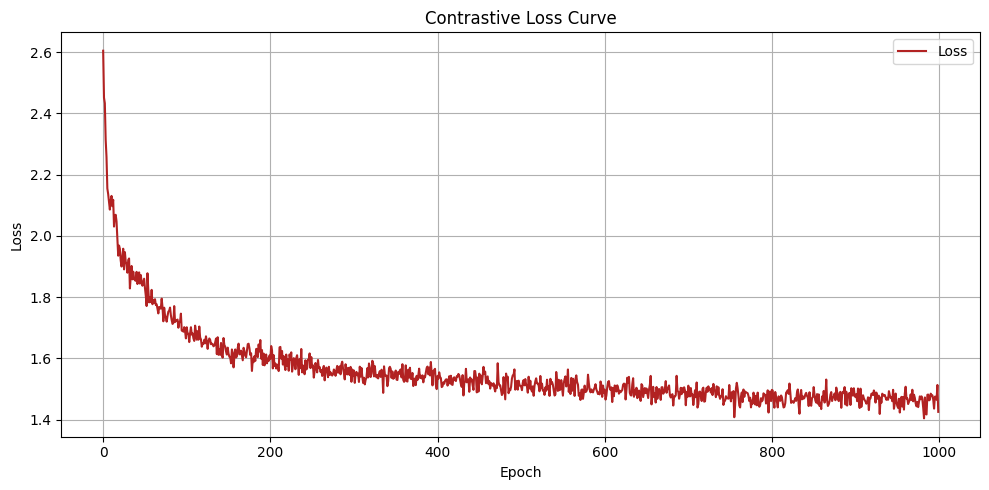

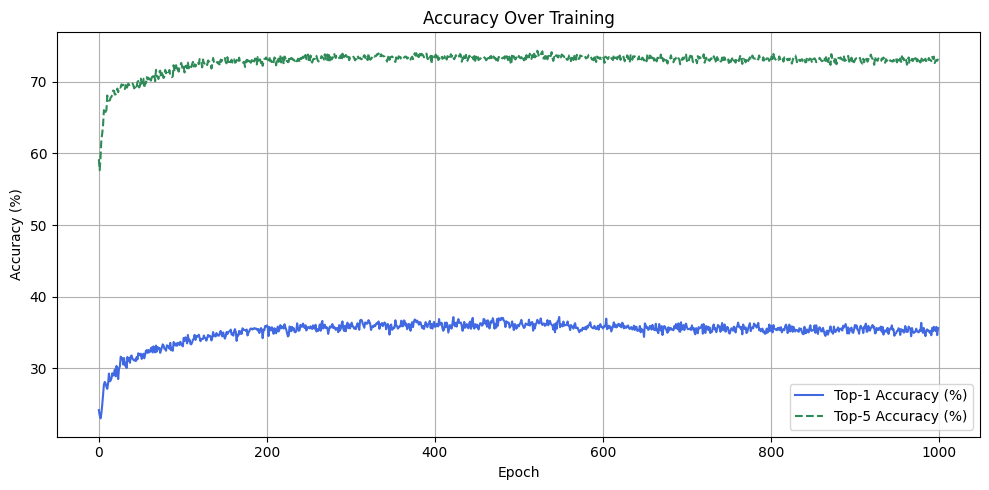

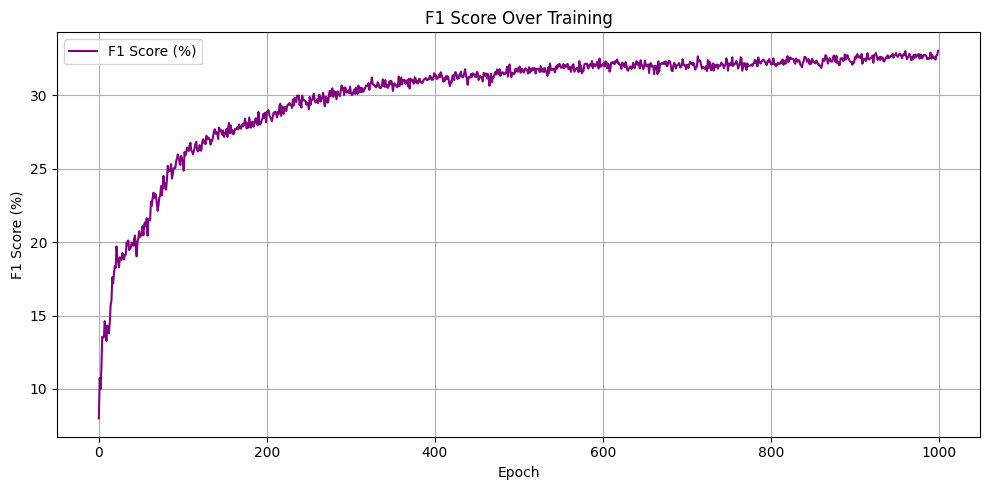

In [15]:
# ✅ Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss", color='firebrick')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(top1_history, label="Top-1 Accuracy (%)", color='royalblue')
plt.plot(top5_history, label="Top-5 Accuracy (%)", linestyle="--", color='seagreen')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot F1 score curve
plt.figure(figsize=(10, 5))
plt.plot(f1_history, label="F1 Score (%)", color='purple')
plt.xlabel("Epoch")
plt.ylabel("F1 Score (%)")
plt.title("F1 Score Over Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "siamese_gnn.pth")
# To load: model.load_state_dict(torch.load("siamese_gnn.pth"))

Using device: cpu
Found 134 pairs


Epoch 1/500: 100%|██████████| 134/134 [00:01<00:00, 83.65it/s] 


Epoch 001  Loss=3.3432  Top1=26.86%  Top5=61.65%  NullF1=18.69%  thr=0.900


Epoch 2/500: 100%|██████████| 134/134 [00:01<00:00, 123.90it/s]


Epoch 002  Loss=3.1090  Top1=28.49%  Top5=61.40%  NullF1=22.06%  thr=0.880


Epoch 3/500: 100%|██████████| 134/134 [00:01<00:00, 131.52it/s]


Epoch 003  Loss=2.9175  Top1=28.89%  Top5=63.31%  NullF1=25.70%  thr=0.848


Epoch 4/500: 100%|██████████| 134/134 [00:01<00:00, 130.49it/s]


Epoch 004  Loss=2.8099  Top1=29.49%  Top5=63.12%  NullF1=25.14%  thr=0.817


Epoch 5/500: 100%|██████████| 134/134 [00:01<00:00, 116.42it/s]


Epoch 005  Loss=2.7621  Top1=29.72%  Top5=63.25%  NullF1=25.79%  thr=0.813


Epoch 6/500: 100%|██████████| 134/134 [00:00<00:00, 135.23it/s]


Epoch 006  Loss=2.7016  Top1=30.10%  Top5=64.36%  NullF1=26.56%  thr=0.800


Epoch 7/500: 100%|██████████| 134/134 [00:01<00:00, 120.19it/s]


Epoch 007  Loss=2.6798  Top1=30.74%  Top5=65.17%  NullF1=26.84%  thr=0.815


Epoch 8/500: 100%|██████████| 134/134 [00:01<00:00, 121.27it/s]


Epoch 008  Loss=2.6493  Top1=30.83%  Top5=64.69%  NullF1=27.05%  thr=0.810


Epoch 9/500: 100%|██████████| 134/134 [00:00<00:00, 137.31it/s]


Epoch 009  Loss=2.6618  Top1=30.29%  Top5=64.99%  NullF1=26.51%  thr=0.830


Epoch 10/500: 100%|██████████| 134/134 [00:00<00:00, 134.08it/s]


Epoch 010  Loss=2.5773  Top1=31.54%  Top5=65.99%  NullF1=29.61%  thr=0.798


Epoch 11/500: 100%|██████████| 134/134 [00:01<00:00, 124.49it/s]


Epoch 011  Loss=2.5592  Top1=31.94%  Top5=65.86%  NullF1=27.11%  thr=0.787


Epoch 12/500: 100%|██████████| 134/134 [00:00<00:00, 136.82it/s]


Epoch 012  Loss=2.6088  Top1=32.38%  Top5=66.46%  NullF1=26.75%  thr=0.814


Epoch 13/500: 100%|██████████| 134/134 [00:01<00:00, 105.22it/s]


Epoch 013  Loss=2.5480  Top1=32.80%  Top5=66.09%  NullF1=28.08%  thr=0.803


Epoch 14/500: 100%|██████████| 134/134 [00:01<00:00, 130.87it/s]


Epoch 014  Loss=2.5255  Top1=32.67%  Top5=66.42%  NullF1=27.20%  thr=0.809


Epoch 15/500: 100%|██████████| 134/134 [00:00<00:00, 139.46it/s]


Epoch 015  Loss=2.4721  Top1=32.81%  Top5=67.36%  NullF1=29.12%  thr=0.789


Epoch 16/500: 100%|██████████| 134/134 [00:00<00:00, 145.33it/s]


Epoch 016  Loss=2.4207  Top1=32.80%  Top5=66.18%  NullF1=27.67%  thr=0.785


Epoch 17/500: 100%|██████████| 134/134 [00:00<00:00, 138.16it/s]


Epoch 017  Loss=2.4545  Top1=33.29%  Top5=67.05%  NullF1=29.34%  thr=0.789


Epoch 18/500: 100%|██████████| 134/134 [00:01<00:00, 130.62it/s]


Epoch 018  Loss=2.3810  Top1=34.05%  Top5=68.10%  NullF1=29.54%  thr=0.775


Epoch 19/500: 100%|██████████| 134/134 [00:00<00:00, 143.12it/s]


Epoch 019  Loss=2.3690  Top1=33.92%  Top5=68.14%  NullF1=27.96%  thr=0.766


Epoch 20/500: 100%|██████████| 134/134 [00:00<00:00, 136.00it/s]


Epoch 020  Loss=2.3311  Top1=34.40%  Top5=66.51%  NullF1=28.94%  thr=0.753


Epoch 21/500: 100%|██████████| 134/134 [00:00<00:00, 144.43it/s]


Epoch 021  Loss=2.3152  Top1=33.05%  Top5=67.97%  NullF1=29.41%  thr=0.773


Epoch 22/500: 100%|██████████| 134/134 [00:01<00:00, 111.81it/s]


Epoch 022  Loss=2.2885  Top1=35.10%  Top5=68.72%  NullF1=30.23%  thr=0.751


Epoch 23/500: 100%|██████████| 134/134 [00:00<00:00, 137.17it/s]


Epoch 023  Loss=2.2463  Top1=35.48%  Top5=68.76%  NullF1=30.17%  thr=0.739


Epoch 24/500: 100%|██████████| 134/134 [00:01<00:00, 130.62it/s]


Epoch 024  Loss=2.2115  Top1=35.55%  Top5=68.70%  NullF1=29.56%  thr=0.731


Epoch 25/500: 100%|██████████| 134/134 [00:01<00:00, 120.48it/s]


Epoch 025  Loss=2.2265  Top1=34.42%  Top5=69.13%  NullF1=30.46%  thr=0.735


Epoch 26/500: 100%|██████████| 134/134 [00:00<00:00, 139.90it/s]


Epoch 026  Loss=2.2073  Top1=34.99%  Top5=68.88%  NullF1=30.33%  thr=0.734


Epoch 27/500: 100%|██████████| 134/134 [00:00<00:00, 145.60it/s]


Epoch 027  Loss=2.1774  Top1=35.36%  Top5=68.41%  NullF1=29.72%  thr=0.728


Epoch 28/500: 100%|██████████| 134/134 [00:00<00:00, 144.66it/s]


Epoch 028  Loss=2.1847  Top1=35.31%  Top5=68.96%  NullF1=29.82%  thr=0.723


Epoch 29/500: 100%|██████████| 134/134 [00:00<00:00, 144.73it/s]


Epoch 029  Loss=2.1483  Top1=35.80%  Top5=69.13%  NullF1=30.75%  thr=0.721


Epoch 30/500: 100%|██████████| 134/134 [00:00<00:00, 145.05it/s]


Epoch 030  Loss=2.1666  Top1=36.25%  Top5=69.48%  NullF1=31.79%  thr=0.724


Epoch 31/500: 100%|██████████| 134/134 [00:01<00:00, 109.88it/s]


Epoch 031  Loss=2.1664  Top1=35.81%  Top5=69.55%  NullF1=31.33%  thr=0.722


Epoch 32/500: 100%|██████████| 134/134 [00:01<00:00, 132.36it/s]


Epoch 032  Loss=2.1502  Top1=35.98%  Top5=69.80%  NullF1=30.50%  thr=0.719


Epoch 33/500: 100%|██████████| 134/134 [00:00<00:00, 135.16it/s]


Epoch 033  Loss=2.1106  Top1=37.10%  Top5=70.11%  NullF1=33.09%  thr=0.715


Epoch 34/500: 100%|██████████| 134/134 [00:00<00:00, 138.16it/s]


Epoch 034  Loss=2.0862  Top1=36.36%  Top5=69.45%  NullF1=31.61%  thr=0.704


Epoch 35/500: 100%|██████████| 134/134 [00:01<00:00, 117.09it/s]


Epoch 035  Loss=2.0868  Top1=36.11%  Top5=69.78%  NullF1=31.48%  thr=0.706


Epoch 36/500: 100%|██████████| 134/134 [00:01<00:00, 131.06it/s]


Epoch 036  Loss=2.1029  Top1=35.93%  Top5=69.95%  NullF1=32.47%  thr=0.713


Epoch 37/500: 100%|██████████| 134/134 [00:01<00:00, 130.87it/s]


Epoch 037  Loss=2.0689  Top1=35.33%  Top5=69.60%  NullF1=31.88%  thr=0.713


Epoch 38/500: 100%|██████████| 134/134 [00:01<00:00, 123.74it/s]


Epoch 038  Loss=2.0820  Top1=36.05%  Top5=69.74%  NullF1=31.43%  thr=0.718


Epoch 39/500: 100%|██████████| 134/134 [00:01<00:00, 110.84it/s]


Epoch 039  Loss=2.0339  Top1=36.93%  Top5=70.76%  NullF1=33.64%  thr=0.710


Epoch 40/500: 100%|██████████| 134/134 [00:01<00:00, 127.93it/s]


Epoch 040  Loss=2.0209  Top1=36.47%  Top5=69.80%  NullF1=31.80%  thr=0.701


Epoch 41/500: 100%|██████████| 134/134 [00:01<00:00, 108.37it/s]


Epoch 041  Loss=2.0235  Top1=36.72%  Top5=69.90%  NullF1=33.51%  thr=0.705


Epoch 42/500: 100%|██████████| 134/134 [00:01<00:00, 132.74it/s]


Epoch 042  Loss=2.0251  Top1=36.98%  Top5=70.19%  NullF1=33.81%  thr=0.698


Epoch 43/500: 100%|██████████| 134/134 [00:00<00:00, 140.26it/s]


Epoch 043  Loss=2.0131  Top1=37.17%  Top5=69.67%  NullF1=31.84%  thr=0.697


Epoch 44/500: 100%|██████████| 134/134 [00:00<00:00, 139.17it/s]


Epoch 044  Loss=1.9972  Top1=36.68%  Top5=70.56%  NullF1=32.42%  thr=0.702


Epoch 45/500: 100%|██████████| 134/134 [00:00<00:00, 139.39it/s]


Epoch 045  Loss=1.9783  Top1=37.56%  Top5=70.19%  NullF1=33.98%  thr=0.698


Epoch 46/500: 100%|██████████| 134/134 [00:01<00:00, 132.49it/s]


Epoch 046  Loss=1.9968  Top1=37.06%  Top5=70.29%  NullF1=31.95%  thr=0.699


Epoch 47/500: 100%|██████████| 134/134 [00:01<00:00, 129.35it/s]


Epoch 047  Loss=1.9802  Top1=37.05%  Top5=70.98%  NullF1=31.97%  thr=0.696


Epoch 48/500: 100%|██████████| 134/134 [00:01<00:00, 107.63it/s]


Epoch 048  Loss=1.9913  Top1=37.22%  Top5=70.52%  NullF1=32.38%  thr=0.703


Epoch 49/500: 100%|██████████| 134/134 [00:00<00:00, 137.31it/s]


Epoch 049  Loss=1.9650  Top1=37.17%  Top5=70.65%  NullF1=32.32%  thr=0.690


Epoch 50/500: 100%|██████████| 134/134 [00:01<00:00, 122.89it/s]


Epoch 050  Loss=1.9735  Top1=37.30%  Top5=70.68%  NullF1=33.26%  thr=0.704


Epoch 51/500: 100%|██████████| 134/134 [00:00<00:00, 134.49it/s]


Epoch 051  Loss=1.9465  Top1=37.45%  Top5=71.50%  NullF1=33.35%  thr=0.690


Epoch 52/500: 100%|██████████| 134/134 [00:00<00:00, 139.60it/s]


Epoch 052  Loss=1.9442  Top1=36.87%  Top5=70.41%  NullF1=34.05%  thr=0.690


Epoch 53/500: 100%|██████████| 134/134 [00:00<00:00, 138.31it/s]


Epoch 053  Loss=1.9612  Top1=37.70%  Top5=70.89%  NullF1=33.37%  thr=0.702


Epoch 54/500: 100%|██████████| 134/134 [00:00<00:00, 140.12it/s]


Epoch 054  Loss=1.9293  Top1=37.44%  Top5=70.79%  NullF1=32.93%  thr=0.690


Epoch 55/500: 100%|██████████| 134/134 [00:01<00:00, 126.36it/s]


Epoch 055  Loss=1.9111  Top1=37.43%  Top5=70.93%  NullF1=34.92%  thr=0.678


Epoch 56/500: 100%|██████████| 134/134 [00:01<00:00, 113.90it/s]


Epoch 056  Loss=1.9297  Top1=38.04%  Top5=70.44%  NullF1=33.25%  thr=0.693


Epoch 57/500: 100%|██████████| 134/134 [00:00<00:00, 137.03it/s]


Epoch 057  Loss=1.9177  Top1=38.06%  Top5=70.26%  NullF1=33.49%  thr=0.692


Epoch 58/500: 100%|██████████| 134/134 [00:01<00:00, 116.98it/s]


Epoch 058  Loss=1.9048  Top1=38.24%  Top5=71.51%  NullF1=32.92%  thr=0.690


Epoch 59/500: 100%|██████████| 134/134 [00:01<00:00, 119.27it/s]


Epoch 059  Loss=1.8956  Top1=37.79%  Top5=71.60%  NullF1=34.01%  thr=0.691


Epoch 60/500: 100%|██████████| 134/134 [00:00<00:00, 139.17it/s]


Epoch 060  Loss=1.8651  Top1=37.64%  Top5=71.53%  NullF1=34.70%  thr=0.680


Epoch 61/500: 100%|██████████| 134/134 [00:01<00:00, 116.88it/s]


Epoch 061  Loss=1.8647  Top1=38.02%  Top5=71.08%  NullF1=35.75%  thr=0.669


Epoch 62/500: 100%|██████████| 134/134 [00:00<00:00, 142.73it/s]


Epoch 062  Loss=1.8939  Top1=38.14%  Top5=70.85%  NullF1=34.20%  thr=0.677


Epoch 63/500: 100%|██████████| 134/134 [00:00<00:00, 136.40it/s]


Epoch 063  Loss=1.8527  Top1=38.16%  Top5=72.25%  NullF1=35.02%  thr=0.675


Epoch 64/500: 100%|██████████| 134/134 [00:01<00:00, 127.87it/s]


Epoch 064  Loss=1.8504  Top1=37.28%  Top5=71.91%  NullF1=35.62%  thr=0.670


Epoch 65/500: 100%|██████████| 134/134 [00:01<00:00, 121.38it/s]


Epoch 065  Loss=1.8802  Top1=37.37%  Top5=71.38%  NullF1=36.00%  thr=0.685


Epoch 66/500: 100%|██████████| 134/134 [00:01<00:00, 120.46it/s]


Epoch 066  Loss=1.9005  Top1=38.88%  Top5=71.59%  NullF1=34.41%  thr=0.691


Epoch 67/500: 100%|██████████| 134/134 [00:01<00:00, 133.42it/s]


Epoch 067  Loss=1.8445  Top1=38.71%  Top5=71.83%  NullF1=34.66%  thr=0.684


Epoch 68/500: 100%|██████████| 134/134 [00:01<00:00, 132.36it/s]


Epoch 068  Loss=1.8155  Top1=38.47%  Top5=71.97%  NullF1=36.61%  thr=0.673


Epoch 69/500: 100%|██████████| 134/134 [00:01<00:00, 131.71it/s]


Epoch 069  Loss=1.8203  Top1=38.94%  Top5=71.60%  NullF1=35.84%  thr=0.666


Epoch 70/500: 100%|██████████| 134/134 [00:01<00:00, 113.76it/s]


Epoch 070  Loss=1.8180  Top1=37.70%  Top5=70.97%  NullF1=34.39%  thr=0.664


Epoch 71/500: 100%|██████████| 134/134 [00:01<00:00, 116.42it/s]


Epoch 071  Loss=1.8180  Top1=38.30%  Top5=71.74%  NullF1=36.86%  thr=0.659


Epoch 72/500: 100%|██████████| 134/134 [00:01<00:00, 120.94it/s]


Epoch 072  Loss=1.8089  Top1=38.21%  Top5=71.09%  NullF1=36.11%  thr=0.662


Epoch 73/500: 100%|██████████| 134/134 [00:00<00:00, 138.17it/s]


Epoch 073  Loss=1.8375  Top1=38.20%  Top5=69.85%  NullF1=34.00%  thr=0.673


Epoch 74/500: 100%|██████████| 134/134 [00:00<00:00, 139.75it/s]


Epoch 074  Loss=1.8289  Top1=39.48%  Top5=71.83%  NullF1=35.68%  thr=0.672


Epoch 75/500: 100%|██████████| 134/134 [00:00<00:00, 136.40it/s]


Epoch 075  Loss=1.8324  Top1=38.28%  Top5=71.16%  NullF1=35.51%  thr=0.672


Epoch 76/500: 100%|██████████| 134/134 [00:00<00:00, 138.59it/s]


Epoch 076  Loss=1.8276  Top1=37.14%  Top5=71.22%  NullF1=35.41%  thr=0.672


Epoch 77/500: 100%|██████████| 134/134 [00:01<00:00, 131.90it/s]


Epoch 077  Loss=1.8498  Top1=38.23%  Top5=70.58%  NullF1=35.75%  thr=0.682


Epoch 78/500: 100%|██████████| 134/134 [00:00<00:00, 136.89it/s]


Epoch 078  Loss=1.8298  Top1=38.91%  Top5=71.09%  NullF1=36.02%  thr=0.665


Epoch 79/500: 100%|██████████| 134/134 [00:01<00:00, 101.36it/s]


Epoch 079  Loss=1.8270  Top1=38.12%  Top5=71.33%  NullF1=35.43%  thr=0.676


Epoch 80/500: 100%|██████████| 134/134 [00:01<00:00, 131.84it/s]


Epoch 080  Loss=1.7921  Top1=39.23%  Top5=71.87%  NullF1=35.41%  thr=0.661


Epoch 81/500: 100%|██████████| 134/134 [00:00<00:00, 141.82it/s]


Epoch 081  Loss=1.7960  Top1=38.41%  Top5=72.00%  NullF1=36.69%  thr=0.666


Epoch 82/500: 100%|██████████| 134/134 [00:00<00:00, 140.04it/s]


Epoch 082  Loss=1.7938  Top1=38.14%  Top5=71.41%  NullF1=34.91%  thr=0.675


Epoch 83/500: 100%|██████████| 134/134 [00:00<00:00, 136.96it/s]


Epoch 083  Loss=1.7945  Top1=38.81%  Top5=71.41%  NullF1=36.74%  thr=0.676


Epoch 84/500: 100%|██████████| 134/134 [00:00<00:00, 135.92it/s]


Epoch 084  Loss=1.8107  Top1=39.70%  Top5=71.76%  NullF1=37.25%  thr=0.664


Epoch 85/500: 100%|██████████| 134/134 [00:01<00:00, 113.08it/s]


Epoch 085  Loss=1.7966  Top1=39.49%  Top5=72.01%  NullF1=35.53%  thr=0.670


Epoch 86/500: 100%|██████████| 134/134 [00:01<00:00, 129.61it/s]


Epoch 086  Loss=1.7818  Top1=39.56%  Top5=71.73%  NullF1=37.32%  thr=0.661


Epoch 87/500: 100%|██████████| 134/134 [00:00<00:00, 134.35it/s]


Epoch 087  Loss=1.7785  Top1=39.74%  Top5=72.21%  NullF1=35.53%  thr=0.656


Epoch 88/500: 100%|██████████| 134/134 [00:01<00:00, 128.73it/s]


Epoch 088  Loss=1.7818  Top1=39.12%  Top5=71.42%  NullF1=36.84%  thr=0.664


Epoch 89/500: 100%|██████████| 134/134 [00:01<00:00, 109.53it/s]


Epoch 089  Loss=1.7671  Top1=39.24%  Top5=71.47%  NullF1=36.67%  thr=0.664


Epoch 90/500: 100%|██████████| 134/134 [00:00<00:00, 139.03it/s]


Epoch 090  Loss=1.7499  Top1=38.59%  Top5=71.88%  NullF1=37.56%  thr=0.650


Epoch 91/500: 100%|██████████| 134/134 [00:00<00:00, 145.21it/s]


Epoch 091  Loss=1.7894  Top1=38.77%  Top5=72.07%  NullF1=36.72%  thr=0.665


Epoch 92/500: 100%|██████████| 134/134 [00:01<00:00, 132.55it/s]


Epoch 092  Loss=1.7962  Top1=39.04%  Top5=72.32%  NullF1=35.70%  thr=0.662


Epoch 93/500: 100%|██████████| 134/134 [00:01<00:00, 128.30it/s]


Epoch 093  Loss=1.7927  Top1=38.15%  Top5=72.16%  NullF1=36.85%  thr=0.666


Epoch 94/500: 100%|██████████| 134/134 [00:01<00:00, 132.76it/s]


Epoch 094  Loss=1.7413  Top1=38.85%  Top5=71.88%  NullF1=37.00%  thr=0.645


Epoch 95/500: 100%|██████████| 134/134 [00:00<00:00, 137.81it/s]


Epoch 095  Loss=1.7748  Top1=39.49%  Top5=71.68%  NullF1=38.50%  thr=0.657


Epoch 96/500: 100%|██████████| 134/134 [00:00<00:00, 138.88it/s]


Epoch 096  Loss=1.7412  Top1=39.71%  Top5=72.01%  NullF1=37.48%  thr=0.646


Epoch 97/500: 100%|██████████| 134/134 [00:01<00:00, 126.25it/s]


Epoch 097  Loss=1.7168  Top1=39.62%  Top5=71.60%  NullF1=37.57%  thr=0.649


Epoch 98/500: 100%|██████████| 134/134 [00:00<00:00, 140.56it/s]


Epoch 098  Loss=1.7301  Top1=39.66%  Top5=72.31%  NullF1=36.60%  thr=0.648


Epoch 99/500: 100%|██████████| 134/134 [00:00<00:00, 144.73it/s]


Epoch 099  Loss=1.7743  Top1=40.17%  Top5=72.05%  NullF1=38.14%  thr=0.662


Epoch 100/500: 100%|██████████| 134/134 [00:00<00:00, 145.13it/s]


Epoch 100  Loss=1.7832  Top1=38.89%  Top5=70.41%  NullF1=37.32%  thr=0.648


Epoch 101/500: 100%|██████████| 134/134 [00:01<00:00, 131.77it/s]


Epoch 101  Loss=1.7583  Top1=39.02%  Top5=72.87%  NullF1=37.58%  thr=0.651


Epoch 102/500: 100%|██████████| 134/134 [00:00<00:00, 138.60it/s]


Epoch 102  Loss=1.7209  Top1=40.35%  Top5=72.66%  NullF1=36.88%  thr=0.640


Epoch 103/500: 100%|██████████| 134/134 [00:00<00:00, 138.45it/s]


Epoch 103  Loss=1.7317  Top1=38.69%  Top5=72.05%  NullF1=36.82%  thr=0.654


Epoch 104/500: 100%|██████████| 134/134 [00:01<00:00, 114.59it/s]


Epoch 104  Loss=1.7673  Top1=39.65%  Top5=71.84%  NullF1=38.18%  thr=0.651


Epoch 105/500: 100%|██████████| 134/134 [00:00<00:00, 141.52it/s]


Epoch 105  Loss=1.7239  Top1=40.64%  Top5=72.32%  NullF1=36.69%  thr=0.646


Epoch 106/500: 100%|██████████| 134/134 [00:01<00:00, 127.27it/s]


Epoch 106  Loss=1.7432  Top1=40.17%  Top5=72.32%  NullF1=37.64%  thr=0.662


Epoch 107/500: 100%|██████████| 134/134 [00:00<00:00, 142.96it/s]


Epoch 107  Loss=1.7003  Top1=40.78%  Top5=71.60%  NullF1=38.31%  thr=0.648


Epoch 108/500: 100%|██████████| 134/134 [00:01<00:00, 131.97it/s]


Epoch 108  Loss=1.6875  Top1=40.63%  Top5=72.25%  NullF1=39.12%  thr=0.641


Epoch 109/500: 100%|██████████| 134/134 [00:01<00:00, 132.89it/s]


Epoch 109  Loss=1.6812  Top1=40.07%  Top5=72.11%  NullF1=37.22%  thr=0.644


Epoch 110/500: 100%|██████████| 134/134 [00:01<00:00, 116.89it/s]


Epoch 110  Loss=1.7130  Top1=40.54%  Top5=72.85%  NullF1=37.80%  thr=0.655


Epoch 111/500: 100%|██████████| 134/134 [00:00<00:00, 138.45it/s]


Epoch 111  Loss=1.6829  Top1=41.25%  Top5=72.92%  NullF1=38.46%  thr=0.643


Epoch 112/500: 100%|██████████| 134/134 [00:00<00:00, 146.00it/s]


Epoch 112  Loss=1.6733  Top1=39.88%  Top5=71.90%  NullF1=37.26%  thr=0.640


Epoch 113/500: 100%|██████████| 134/134 [00:00<00:00, 144.42it/s]


Epoch 113  Loss=1.6816  Top1=40.74%  Top5=72.17%  NullF1=39.51%  thr=0.643


Epoch 114/500: 100%|██████████| 134/134 [00:00<00:00, 137.32it/s]


Epoch 114  Loss=1.6526  Top1=41.81%  Top5=72.43%  NullF1=40.31%  thr=0.635


Epoch 115/500: 100%|██████████| 134/134 [00:01<00:00, 113.57it/s]


Epoch 115  Loss=1.6923  Top1=40.58%  Top5=72.16%  NullF1=38.10%  thr=0.649


Epoch 116/500: 100%|██████████| 134/134 [00:00<00:00, 139.03it/s]


Epoch 116  Loss=1.6997  Top1=40.99%  Top5=72.66%  NullF1=39.74%  thr=0.640


Epoch 117/500: 100%|██████████| 134/134 [00:01<00:00, 109.38it/s]


Epoch 117  Loss=1.6773  Top1=41.16%  Top5=72.76%  NullF1=39.87%  thr=0.645


Epoch 118/500: 100%|██████████| 134/134 [00:01<00:00, 115.77it/s]


Epoch 118  Loss=1.6818  Top1=40.48%  Top5=72.27%  NullF1=37.61%  thr=0.648


Epoch 119/500: 100%|██████████| 134/134 [00:01<00:00, 130.23it/s]


Epoch 119  Loss=1.6870  Top1=40.83%  Top5=72.95%  NullF1=39.26%  thr=0.648


Epoch 120/500: 100%|██████████| 134/134 [00:01<00:00, 124.55it/s]


Epoch 120  Loss=1.6892  Top1=41.10%  Top5=71.60%  NullF1=38.13%  thr=0.634


Epoch 121/500: 100%|██████████| 134/134 [00:01<00:00, 128.06it/s]


Epoch 121  Loss=1.7179  Top1=41.59%  Top5=72.83%  NullF1=39.98%  thr=0.663


Epoch 122/500: 100%|██████████| 134/134 [00:01<00:00, 133.42it/s]


Epoch 122  Loss=1.6708  Top1=39.84%  Top5=72.18%  NullF1=38.42%  thr=0.640


Epoch 123/500: 100%|██████████| 134/134 [00:00<00:00, 139.17it/s]


Epoch 123  Loss=1.6997  Top1=40.98%  Top5=72.56%  NullF1=40.80%  thr=0.644


Epoch 124/500: 100%|██████████| 134/134 [00:01<00:00, 113.09it/s]


Epoch 124  Loss=1.6782  Top1=41.17%  Top5=72.77%  NullF1=39.40%  thr=0.638


Epoch 125/500: 100%|██████████| 134/134 [00:00<00:00, 140.55it/s]


Epoch 125  Loss=1.6432  Top1=41.56%  Top5=72.88%  NullF1=39.08%  thr=0.641


Epoch 126/500: 100%|██████████| 134/134 [00:00<00:00, 143.26it/s]


Epoch 126  Loss=1.6193  Top1=41.10%  Top5=72.67%  NullF1=40.06%  thr=0.622


Epoch 127/500: 100%|██████████| 134/134 [00:01<00:00, 112.99it/s]


Epoch 127  Loss=1.6225  Top1=41.82%  Top5=72.77%  NullF1=41.04%  thr=0.630


Epoch 128/500: 100%|██████████| 134/134 [00:01<00:00, 118.74it/s]


Epoch 128  Loss=1.6378  Top1=41.32%  Top5=72.86%  NullF1=40.62%  thr=0.625


Epoch 129/500: 100%|██████████| 134/134 [00:01<00:00, 126.78it/s]


Epoch 129  Loss=1.6325  Top1=40.98%  Top5=72.44%  NullF1=40.69%  thr=0.633


Epoch 130/500: 100%|██████████| 134/134 [00:00<00:00, 137.60it/s]


Epoch 130  Loss=1.6326  Top1=40.35%  Top5=72.92%  NullF1=40.81%  thr=0.627


Epoch 131/500: 100%|██████████| 134/134 [00:01<00:00, 132.03it/s]


Epoch 131  Loss=1.6555  Top1=41.38%  Top5=73.26%  NullF1=39.88%  thr=0.631


Epoch 132/500: 100%|██████████| 134/134 [00:01<00:00, 124.31it/s]


Epoch 132  Loss=1.6336  Top1=41.17%  Top5=72.63%  NullF1=38.71%  thr=0.632


Epoch 133/500: 100%|██████████| 134/134 [00:01<00:00, 124.03it/s]


Epoch 133  Loss=1.6440  Top1=41.29%  Top5=72.34%  NullF1=40.28%  thr=0.628


Epoch 134/500: 100%|██████████| 134/134 [00:00<00:00, 142.05it/s]


Epoch 134  Loss=1.6561  Top1=41.15%  Top5=72.65%  NullF1=39.85%  thr=0.627


Epoch 135/500: 100%|██████████| 134/134 [00:00<00:00, 141.30it/s]


Epoch 135  Loss=1.6537  Top1=42.48%  Top5=73.04%  NullF1=40.39%  thr=0.650


Epoch 136/500: 100%|██████████| 134/134 [00:00<00:00, 141.83it/s]


Epoch 136  Loss=1.6226  Top1=42.15%  Top5=73.24%  NullF1=37.96%  thr=0.629


Epoch 137/500: 100%|██████████| 134/134 [00:01<00:00, 110.02it/s]


Epoch 137  Loss=1.6107  Top1=42.09%  Top5=73.13%  NullF1=41.13%  thr=0.624


Epoch 138/500: 100%|██████████| 134/134 [00:00<00:00, 136.42it/s]


Epoch 138  Loss=1.6267  Top1=42.26%  Top5=73.34%  NullF1=40.30%  thr=0.631


Epoch 139/500: 100%|██████████| 134/134 [00:01<00:00, 132.62it/s]


Epoch 139  Loss=1.6245  Top1=42.09%  Top5=72.71%  NullF1=41.42%  thr=0.624


Epoch 140/500: 100%|██████████| 134/134 [00:01<00:00, 128.18it/s]


Epoch 140  Loss=1.6377  Top1=41.59%  Top5=72.94%  NullF1=39.25%  thr=0.637


Epoch 141/500: 100%|██████████| 134/134 [00:00<00:00, 141.52it/s]


Epoch 141  Loss=1.6272  Top1=41.33%  Top5=72.01%  NullF1=41.65%  thr=0.625


Epoch 142/500: 100%|██████████| 134/134 [00:01<00:00, 121.44it/s]


Epoch 142  Loss=1.6386  Top1=42.35%  Top5=73.96%  NullF1=41.30%  thr=0.629


Epoch 143/500: 100%|██████████| 134/134 [00:00<00:00, 140.03it/s]


Epoch 143  Loss=1.6232  Top1=41.58%  Top5=72.43%  NullF1=40.43%  thr=0.622


Epoch 144/500: 100%|██████████| 134/134 [00:00<00:00, 138.80it/s]


Epoch 144  Loss=1.5918  Top1=41.79%  Top5=72.55%  NullF1=42.20%  thr=0.627


Epoch 145/500: 100%|██████████| 134/134 [00:00<00:00, 139.03it/s]


Epoch 145  Loss=1.6028  Top1=41.82%  Top5=72.25%  NullF1=38.73%  thr=0.615


Epoch 146/500: 100%|██████████| 134/134 [00:00<00:00, 139.31it/s]


Epoch 146  Loss=1.5996  Top1=42.59%  Top5=73.83%  NullF1=40.21%  thr=0.625


Epoch 147/500: 100%|██████████| 134/134 [00:01<00:00, 130.49it/s]


Epoch 147  Loss=1.5720  Top1=42.30%  Top5=73.23%  NullF1=41.12%  thr=0.617


Epoch 148/500: 100%|██████████| 134/134 [00:01<00:00, 125.53it/s]


Epoch 148  Loss=1.5784  Top1=43.08%  Top5=73.19%  NullF1=42.27%  thr=0.618


Epoch 149/500: 100%|██████████| 134/134 [00:01<00:00, 128.54it/s]


Epoch 149  Loss=1.5904  Top1=42.11%  Top5=72.95%  NullF1=41.40%  thr=0.621


Epoch 150/500: 100%|██████████| 134/134 [00:01<00:00, 128.86it/s]


Epoch 150  Loss=1.5804  Top1=42.41%  Top5=73.51%  NullF1=42.03%  thr=0.621


Epoch 151/500: 100%|██████████| 134/134 [00:01<00:00, 116.32it/s]


Epoch 151  Loss=1.6156  Top1=42.15%  Top5=72.81%  NullF1=39.58%  thr=0.623


Epoch 152/500: 100%|██████████| 134/134 [00:01<00:00, 133.53it/s]


Epoch 152  Loss=1.5987  Top1=40.19%  Top5=72.11%  NullF1=40.94%  thr=0.614


Epoch 153/500: 100%|██████████| 134/134 [00:01<00:00, 124.53it/s]


Epoch 153  Loss=1.5934  Top1=42.01%  Top5=72.91%  NullF1=41.56%  thr=0.612


Epoch 154/500: 100%|██████████| 134/134 [00:01<00:00, 130.30it/s]


Epoch 154  Loss=1.5812  Top1=41.85%  Top5=73.18%  NullF1=38.96%  thr=0.615


Epoch 155/500: 100%|██████████| 134/134 [00:00<00:00, 135.99it/s]


Epoch 155  Loss=1.5960  Top1=41.80%  Top5=73.31%  NullF1=40.31%  thr=0.625


Epoch 156/500: 100%|██████████| 134/134 [00:01<00:00, 132.23it/s]


Epoch 156  Loss=1.6186  Top1=41.63%  Top5=72.53%  NullF1=41.30%  thr=0.623


Epoch 157/500: 100%|██████████| 134/134 [00:01<00:00, 127.51it/s]


Epoch 157  Loss=1.6040  Top1=41.71%  Top5=73.34%  NullF1=41.33%  thr=0.613


Epoch 158/500: 100%|██████████| 134/134 [00:01<00:00, 118.75it/s]


Epoch 158  Loss=1.5985  Top1=42.26%  Top5=72.85%  NullF1=40.44%  thr=0.623


Epoch 159/500: 100%|██████████| 134/134 [00:01<00:00, 131.20it/s]


Epoch 159  Loss=1.5881  Top1=41.60%  Top5=72.87%  NullF1=41.68%  thr=0.617


Epoch 160/500: 100%|██████████| 134/134 [00:01<00:00, 108.72it/s]


Epoch 160  Loss=1.6046  Top1=42.27%  Top5=73.45%  NullF1=39.71%  thr=0.626


Epoch 161/500: 100%|██████████| 134/134 [00:01<00:00, 118.59it/s]


Epoch 161  Loss=1.5961  Top1=43.02%  Top5=73.60%  NullF1=41.48%  thr=0.617


Epoch 162/500: 100%|██████████| 134/134 [00:01<00:00, 123.57it/s]


Epoch 162  Loss=1.5734  Top1=41.82%  Top5=72.42%  NullF1=40.65%  thr=0.616


Epoch 163/500: 100%|██████████| 134/134 [00:00<00:00, 142.12it/s]


Epoch 163  Loss=1.5561  Top1=43.04%  Top5=73.57%  NullF1=41.81%  thr=0.617


Epoch 164/500: 100%|██████████| 134/134 [00:01<00:00, 132.69it/s]


Epoch 164  Loss=1.5626  Top1=42.24%  Top5=72.62%  NullF1=41.21%  thr=0.609


Epoch 165/500: 100%|██████████| 134/134 [00:01<00:00, 129.73it/s]


Epoch 165  Loss=1.5752  Top1=41.46%  Top5=73.33%  NullF1=40.04%  thr=0.610


Epoch 166/500: 100%|██████████| 134/134 [00:01<00:00, 119.54it/s]


Epoch 166  Loss=1.5832  Top1=41.38%  Top5=73.09%  NullF1=40.99%  thr=0.609


Epoch 167/500: 100%|██████████| 134/134 [00:01<00:00, 131.97it/s]


Epoch 167  Loss=1.5716  Top1=42.60%  Top5=73.19%  NullF1=41.72%  thr=0.615


Epoch 168/500: 100%|██████████| 134/134 [00:01<00:00, 127.75it/s]


Epoch 168  Loss=1.5723  Top1=41.68%  Top5=72.90%  NullF1=41.30%  thr=0.614


Epoch 169/500: 100%|██████████| 134/134 [00:01<00:00, 115.07it/s]


Epoch 169  Loss=1.5726  Top1=42.28%  Top5=73.17%  NullF1=40.85%  thr=0.607


Epoch 170/500: 100%|██████████| 134/134 [00:01<00:00, 120.46it/s]


Epoch 170  Loss=1.5374  Top1=42.14%  Top5=73.57%  NullF1=42.11%  thr=0.608


Epoch 171/500: 100%|██████████| 134/134 [00:01<00:00, 128.49it/s]


Epoch 171  Loss=1.5503  Top1=40.68%  Top5=71.49%  NullF1=40.42%  thr=0.603


Epoch 172/500: 100%|██████████| 134/134 [00:01<00:00, 125.30it/s]


Epoch 172  Loss=1.5755  Top1=42.99%  Top5=73.68%  NullF1=40.24%  thr=0.605


Epoch 173/500: 100%|██████████| 134/134 [00:00<00:00, 137.24it/s]


Epoch 173  Loss=1.5552  Top1=42.85%  Top5=73.50%  NullF1=41.52%  thr=0.604


Epoch 174/500: 100%|██████████| 134/134 [00:00<00:00, 141.45it/s]


Epoch 174  Loss=1.5630  Top1=41.23%  Top5=72.03%  NullF1=41.73%  thr=0.607


Epoch 175/500: 100%|██████████| 134/134 [00:01<00:00, 113.33it/s]


Epoch 175  Loss=1.5595  Top1=42.90%  Top5=73.32%  NullF1=42.38%  thr=0.606


Epoch 176/500: 100%|██████████| 134/134 [00:00<00:00, 139.82it/s]


Epoch 176  Loss=1.5493  Top1=41.93%  Top5=73.19%  NullF1=42.12%  thr=0.601


Epoch 177/500: 100%|██████████| 134/134 [00:01<00:00, 132.69it/s]


Epoch 177  Loss=1.5768  Top1=41.99%  Top5=73.36%  NullF1=42.27%  thr=0.606


Epoch 178/500: 100%|██████████| 134/134 [00:00<00:00, 135.51it/s]


Epoch 178  Loss=1.5618  Top1=42.07%  Top5=72.18%  NullF1=41.07%  thr=0.604


Epoch 179/500: 100%|██████████| 134/134 [00:01<00:00, 121.27it/s]


Epoch 179  Loss=1.5618  Top1=41.92%  Top5=73.37%  NullF1=42.70%  thr=0.608


Epoch 180/500: 100%|██████████| 134/134 [00:01<00:00, 121.11it/s]


Epoch 180  Loss=1.5323  Top1=42.25%  Top5=73.26%  NullF1=42.29%  thr=0.601


Epoch 181/500: 100%|██████████| 134/134 [00:00<00:00, 134.83it/s]


Epoch 181  Loss=1.5343  Top1=43.06%  Top5=74.06%  NullF1=42.85%  thr=0.604


Epoch 182/500: 100%|██████████| 134/134 [00:01<00:00, 129.04it/s]


Epoch 182  Loss=1.5355  Top1=42.30%  Top5=73.99%  NullF1=43.66%  thr=0.600


Epoch 183/500: 100%|██████████| 134/134 [00:00<00:00, 137.74it/s]


Epoch 183  Loss=1.5605  Top1=41.25%  Top5=71.67%  NullF1=42.50%  thr=0.603


Epoch 184/500: 100%|██████████| 134/134 [00:01<00:00, 133.55it/s]


Epoch 184  Loss=1.5827  Top1=42.21%  Top5=72.65%  NullF1=42.28%  thr=0.603


Epoch 185/500: 100%|██████████| 134/134 [00:01<00:00, 106.40it/s]


Epoch 185  Loss=1.5401  Top1=42.54%  Top5=73.38%  NullF1=40.88%  thr=0.605


Epoch 186/500: 100%|██████████| 134/134 [00:00<00:00, 138.38it/s]


Epoch 186  Loss=1.5354  Top1=41.81%  Top5=72.64%  NullF1=42.93%  thr=0.605


Epoch 187/500: 100%|██████████| 134/134 [00:00<00:00, 137.01it/s]


Epoch 187  Loss=1.5874  Top1=42.02%  Top5=72.54%  NullF1=43.59%  thr=0.614


Epoch 188/500: 100%|██████████| 134/134 [00:01<00:00, 121.99it/s]


Epoch 188  Loss=1.5294  Top1=42.47%  Top5=73.79%  NullF1=43.07%  thr=0.603


Epoch 189/500: 100%|██████████| 134/134 [00:00<00:00, 137.60it/s]


Epoch 189  Loss=1.5103  Top1=42.68%  Top5=73.54%  NullF1=42.95%  thr=0.603


Epoch 190/500: 100%|██████████| 134/134 [00:00<00:00, 138.02it/s]


Epoch 190  Loss=1.5605  Top1=41.52%  Top5=72.39%  NullF1=42.55%  thr=0.619


Epoch 191/500: 100%|██████████| 134/134 [00:00<00:00, 135.16it/s]


Epoch 191  Loss=1.5332  Top1=41.99%  Top5=73.15%  NullF1=44.08%  thr=0.603


Epoch 192/500: 100%|██████████| 134/134 [00:01<00:00, 128.98it/s]


Epoch 192  Loss=1.5209  Top1=42.66%  Top5=73.32%  NullF1=42.64%  thr=0.599


Epoch 193/500: 100%|██████████| 134/134 [00:01<00:00, 133.02it/s]


Epoch 193  Loss=1.5773  Top1=41.76%  Top5=72.81%  NullF1=42.60%  thr=0.608


Epoch 194/500: 100%|██████████| 134/134 [00:01<00:00, 130.23it/s]


Epoch 194  Loss=1.5491  Top1=43.14%  Top5=73.32%  NullF1=42.12%  thr=0.608


Epoch 195/500: 100%|██████████| 134/134 [00:01<00:00, 129.86it/s]


Epoch 195  Loss=1.5278  Top1=42.80%  Top5=73.20%  NullF1=43.46%  thr=0.600


Epoch 196/500: 100%|██████████| 134/134 [00:00<00:00, 139.60it/s]


Epoch 196  Loss=1.5399  Top1=41.96%  Top5=73.40%  NullF1=42.01%  thr=0.603


Epoch 197/500: 100%|██████████| 134/134 [00:01<00:00, 120.67it/s]


Epoch 197  Loss=1.5413  Top1=42.78%  Top5=73.35%  NullF1=42.25%  thr=0.610


Epoch 198/500: 100%|██████████| 134/134 [00:00<00:00, 141.00it/s]


Epoch 198  Loss=1.5228  Top1=42.14%  Top5=71.91%  NullF1=44.05%  thr=0.611


Epoch 199/500: 100%|██████████| 134/134 [00:01<00:00, 131.91it/s]


Epoch 199  Loss=1.5290  Top1=43.04%  Top5=73.82%  NullF1=41.61%  thr=0.605


Epoch 200/500: 100%|██████████| 134/134 [00:01<00:00, 112.76it/s]


Epoch 200  Loss=1.5046  Top1=42.49%  Top5=73.06%  NullF1=42.78%  thr=0.597


Epoch 201/500: 100%|██████████| 134/134 [00:01<00:00, 122.27it/s]


Epoch 201  Loss=1.5393  Top1=42.24%  Top5=72.56%  NullF1=42.89%  thr=0.595


Epoch 202/500: 100%|██████████| 134/134 [00:01<00:00, 131.85it/s]


Epoch 202  Loss=1.5222  Top1=41.85%  Top5=72.39%  NullF1=42.97%  thr=0.598


Epoch 203/500: 100%|██████████| 134/134 [00:01<00:00, 120.14it/s]


Epoch 203  Loss=1.5118  Top1=43.39%  Top5=74.10%  NullF1=42.82%  thr=0.593


Epoch 204/500: 100%|██████████| 134/134 [00:01<00:00, 133.48it/s]


Epoch 204  Loss=1.4994  Top1=43.35%  Top5=74.31%  NullF1=42.67%  thr=0.599


Epoch 205/500: 100%|██████████| 134/134 [00:01<00:00, 124.31it/s]


Epoch 205  Loss=1.4872  Top1=42.32%  Top5=72.60%  NullF1=43.66%  thr=0.592


Epoch 206/500: 100%|██████████| 134/134 [00:01<00:00, 98.89it/s] 


Epoch 206  Loss=1.5118  Top1=42.46%  Top5=73.81%  NullF1=44.43%  thr=0.590


Epoch 207/500: 100%|██████████| 134/134 [00:00<00:00, 136.97it/s]


Epoch 207  Loss=1.4888  Top1=43.67%  Top5=73.08%  NullF1=43.78%  thr=0.590


Epoch 208/500: 100%|██████████| 134/134 [00:01<00:00, 130.43it/s]


Epoch 208  Loss=1.4980  Top1=41.87%  Top5=72.50%  NullF1=40.48%  thr=0.589


Epoch 209/500: 100%|██████████| 134/134 [00:00<00:00, 137.59it/s]


Epoch 209  Loss=1.5258  Top1=41.79%  Top5=73.42%  NullF1=41.85%  thr=0.590


Epoch 210/500: 100%|██████████| 134/134 [00:00<00:00, 137.88it/s]


Epoch 210  Loss=1.5124  Top1=43.68%  Top5=74.53%  NullF1=42.03%  thr=0.590


Epoch 211/500: 100%|██████████| 134/134 [00:01<00:00, 131.84it/s]


Epoch 211  Loss=1.4924  Top1=42.90%  Top5=72.99%  NullF1=44.16%  thr=0.592


Epoch 212/500: 100%|██████████| 134/134 [00:01<00:00, 109.88it/s]


Epoch 212  Loss=1.5286  Top1=42.89%  Top5=73.97%  NullF1=42.84%  thr=0.601


Epoch 213/500: 100%|██████████| 134/134 [00:01<00:00, 131.45it/s]


Epoch 213  Loss=1.5107  Top1=41.81%  Top5=72.09%  NullF1=43.66%  thr=0.596


Epoch 214/500: 100%|██████████| 134/134 [00:00<00:00, 135.03it/s]


Epoch 214  Loss=1.5181  Top1=43.65%  Top5=73.75%  NullF1=44.77%  thr=0.596


Epoch 215/500: 100%|██████████| 134/134 [00:01<00:00, 111.07it/s]


Epoch 215  Loss=1.4960  Top1=43.39%  Top5=74.12%  NullF1=44.43%  thr=0.596


Epoch 216/500: 100%|██████████| 134/134 [00:01<00:00, 133.42it/s]


Epoch 216  Loss=1.5065  Top1=43.27%  Top5=74.10%  NullF1=43.40%  thr=0.598


Epoch 217/500: 100%|██████████| 134/134 [00:00<00:00, 135.17it/s]


Epoch 217  Loss=1.4973  Top1=43.47%  Top5=73.51%  NullF1=45.11%  thr=0.599


Epoch 218/500: 100%|██████████| 134/134 [00:01<00:00, 122.95it/s]


Epoch 218  Loss=1.4930  Top1=43.05%  Top5=73.72%  NullF1=44.88%  thr=0.597


Epoch 219/500: 100%|██████████| 134/134 [00:00<00:00, 134.22it/s]


Epoch 219  Loss=1.4851  Top1=42.83%  Top5=73.69%  NullF1=44.32%  thr=0.590


Epoch 220/500: 100%|██████████| 134/134 [00:01<00:00, 116.88it/s]


Epoch 220  Loss=1.4733  Top1=43.44%  Top5=74.48%  NullF1=46.08%  thr=0.586


Epoch 221/500: 100%|██████████| 134/134 [00:00<00:00, 135.85it/s]


Epoch 221  Loss=1.4749  Top1=42.54%  Top5=73.42%  NullF1=43.18%  thr=0.589


Epoch 222/500: 100%|██████████| 134/134 [00:01<00:00, 133.61it/s]


Epoch 222  Loss=1.5032  Top1=42.33%  Top5=72.66%  NullF1=43.87%  thr=0.592


Epoch 223/500: 100%|██████████| 134/134 [00:01<00:00, 108.20it/s]


Epoch 223  Loss=1.5074  Top1=43.59%  Top5=73.18%  NullF1=44.27%  thr=0.594


Epoch 224/500: 100%|██████████| 134/134 [00:00<00:00, 134.76it/s]


Epoch 224  Loss=1.4848  Top1=42.53%  Top5=72.97%  NullF1=45.70%  thr=0.593


Epoch 225/500: 100%|██████████| 134/134 [00:01<00:00, 132.10it/s]


Epoch 225  Loss=1.4712  Top1=42.91%  Top5=73.04%  NullF1=44.80%  thr=0.591


Epoch 226/500: 100%|██████████| 134/134 [00:00<00:00, 134.07it/s]


Epoch 226  Loss=1.5071  Top1=41.96%  Top5=73.16%  NullF1=43.58%  thr=0.592


Epoch 227/500: 100%|██████████| 134/134 [00:01<00:00, 133.08it/s]


Epoch 227  Loss=1.5253  Top1=43.21%  Top5=73.77%  NullF1=44.39%  thr=0.596


Epoch 228/500: 100%|██████████| 134/134 [00:00<00:00, 138.24it/s]


Epoch 228  Loss=1.4761  Top1=42.96%  Top5=73.39%  NullF1=45.32%  thr=0.595


Epoch 229/500: 100%|██████████| 134/134 [00:00<00:00, 134.22it/s]


Epoch 229  Loss=1.4855  Top1=42.64%  Top5=73.16%  NullF1=44.03%  thr=0.590


Epoch 230/500: 100%|██████████| 134/134 [00:00<00:00, 134.74it/s]


Epoch 230  Loss=1.5196  Top1=42.62%  Top5=73.49%  NullF1=43.70%  thr=0.596


Epoch 231/500: 100%|██████████| 134/134 [00:00<00:00, 134.62it/s]


Epoch 231  Loss=1.4934  Top1=42.95%  Top5=72.86%  NullF1=43.61%  thr=0.594


Epoch 232/500: 100%|██████████| 134/134 [00:01<00:00, 131.91it/s]


Epoch 232  Loss=1.4775  Top1=43.50%  Top5=73.27%  NullF1=44.80%  thr=0.590


Epoch 233/500: 100%|██████████| 134/134 [00:01<00:00, 107.55it/s]


Epoch 233  Loss=1.4882  Top1=43.45%  Top5=74.17%  NullF1=43.13%  thr=0.582


Epoch 234/500: 100%|██████████| 134/134 [00:00<00:00, 136.75it/s]


Epoch 234  Loss=1.4734  Top1=43.17%  Top5=73.62%  NullF1=43.62%  thr=0.587


Epoch 235/500: 100%|██████████| 134/134 [00:01<00:00, 128.74it/s]


Epoch 235  Loss=1.4780  Top1=43.08%  Top5=73.74%  NullF1=46.02%  thr=0.600


Epoch 236/500: 100%|██████████| 134/134 [00:00<00:00, 141.30it/s]


Epoch 236  Loss=1.4601  Top1=42.48%  Top5=72.83%  NullF1=46.02%  thr=0.581


Epoch 237/500: 100%|██████████| 134/134 [00:00<00:00, 135.10it/s]


Epoch 237  Loss=1.4595  Top1=43.60%  Top5=73.88%  NullF1=44.67%  thr=0.581


Epoch 238/500: 100%|██████████| 134/134 [00:00<00:00, 135.17it/s]


Epoch 238  Loss=1.4475  Top1=44.55%  Top5=74.12%  NullF1=45.52%  thr=0.578


Epoch 239/500: 100%|██████████| 134/134 [00:01<00:00, 120.30it/s]


Epoch 239  Loss=1.4387  Top1=43.71%  Top5=73.77%  NullF1=44.35%  thr=0.581


Epoch 240/500: 100%|██████████| 134/134 [00:01<00:00, 132.17it/s]


Epoch 240  Loss=1.4567  Top1=44.00%  Top5=73.12%  NullF1=46.73%  thr=0.580


Epoch 241/500: 100%|██████████| 134/134 [00:01<00:00, 133.96it/s]


Epoch 241  Loss=1.4424  Top1=43.47%  Top5=74.11%  NullF1=45.25%  thr=0.580


Epoch 242/500: 100%|██████████| 134/134 [00:00<00:00, 135.71it/s]


Epoch 242  Loss=1.4494  Top1=43.41%  Top5=73.89%  NullF1=46.71%  thr=0.578


Epoch 243/500: 100%|██████████| 134/134 [00:00<00:00, 138.38it/s]


Epoch 243  Loss=1.4411  Top1=44.12%  Top5=74.08%  NullF1=44.96%  thr=0.576


Epoch 244/500: 100%|██████████| 134/134 [00:00<00:00, 136.47it/s]


Epoch 244  Loss=1.4803  Top1=42.52%  Top5=72.85%  NullF1=45.34%  thr=0.578


Epoch 245/500: 100%|██████████| 134/134 [00:00<00:00, 139.68it/s]


Epoch 245  Loss=1.5000  Top1=43.00%  Top5=74.36%  NullF1=44.47%  thr=0.588


Epoch 246/500: 100%|██████████| 134/134 [00:01<00:00, 133.81it/s]


Epoch 246  Loss=1.4538  Top1=44.69%  Top5=73.87%  NullF1=45.03%  thr=0.584


Epoch 247/500: 100%|██████████| 134/134 [00:01<00:00, 117.86it/s]


Epoch 247  Loss=1.4468  Top1=42.68%  Top5=73.17%  NullF1=45.94%  thr=0.582


Epoch 248/500: 100%|██████████| 134/134 [00:01<00:00, 133.01it/s]


Epoch 248  Loss=1.4755  Top1=43.35%  Top5=74.08%  NullF1=45.68%  thr=0.585


Epoch 249/500: 100%|██████████| 134/134 [00:00<00:00, 136.41it/s]


Epoch 249  Loss=1.4592  Top1=43.13%  Top5=72.66%  NullF1=42.94%  thr=0.589


Epoch 250/500: 100%|██████████| 134/134 [00:00<00:00, 134.22it/s]


Epoch 250  Loss=1.5184  Top1=43.67%  Top5=73.61%  NullF1=45.29%  thr=0.594


Epoch 251/500: 100%|██████████| 134/134 [00:00<00:00, 134.89it/s]


Epoch 251  Loss=1.4959  Top1=42.93%  Top5=73.54%  NullF1=44.82%  thr=0.584


Epoch 252/500: 100%|██████████| 134/134 [00:00<00:00, 138.02it/s]


Epoch 252  Loss=1.4460  Top1=44.12%  Top5=73.82%  NullF1=46.14%  thr=0.585


Epoch 253/500: 100%|██████████| 134/134 [00:00<00:00, 135.79it/s]


Epoch 253  Loss=1.4758  Top1=42.80%  Top5=73.44%  NullF1=45.82%  thr=0.575


Epoch 254/500: 100%|██████████| 134/134 [00:00<00:00, 145.92it/s]


Epoch 254  Loss=1.4542  Top1=43.27%  Top5=73.30%  NullF1=46.44%  thr=0.573


Epoch 255/500: 100%|██████████| 134/134 [00:00<00:00, 143.57it/s]


Epoch 255  Loss=1.4788  Top1=43.74%  Top5=73.62%  NullF1=44.56%  thr=0.580


Epoch 256/500: 100%|██████████| 134/134 [00:01<00:00, 131.07it/s]


Epoch 256  Loss=1.4798  Top1=43.53%  Top5=74.02%  NullF1=44.74%  thr=0.596


Epoch 257/500: 100%|██████████| 134/134 [00:00<00:00, 136.34it/s]


Epoch 257  Loss=1.4662  Top1=43.67%  Top5=73.57%  NullF1=47.27%  thr=0.583


Epoch 258/500: 100%|██████████| 134/134 [00:00<00:00, 142.05it/s]


Epoch 258  Loss=1.4505  Top1=42.82%  Top5=73.32%  NullF1=47.47%  thr=0.583


Epoch 259/500: 100%|██████████| 134/134 [00:00<00:00, 141.15it/s]


Epoch 259  Loss=1.4581  Top1=43.90%  Top5=73.59%  NullF1=42.85%  thr=0.572


Epoch 260/500: 100%|██████████| 134/134 [00:00<00:00, 139.97it/s]


Epoch 260  Loss=1.4473  Top1=42.96%  Top5=72.94%  NullF1=44.07%  thr=0.581


Epoch 261/500: 100%|██████████| 134/134 [00:00<00:00, 142.64it/s]


Epoch 261  Loss=1.4674  Top1=43.96%  Top5=73.62%  NullF1=45.16%  thr=0.573


Epoch 262/500: 100%|██████████| 134/134 [00:00<00:00, 145.05it/s]


Epoch 262  Loss=1.4545  Top1=43.60%  Top5=73.60%  NullF1=45.04%  thr=0.582


Epoch 263/500: 100%|██████████| 134/134 [00:00<00:00, 141.75it/s]


Epoch 263  Loss=1.4457  Top1=42.62%  Top5=73.62%  NullF1=45.62%  thr=0.580


Epoch 264/500: 100%|██████████| 134/134 [00:00<00:00, 143.19it/s]


Epoch 264  Loss=1.4321  Top1=44.23%  Top5=73.60%  NullF1=45.84%  thr=0.573


Epoch 265/500: 100%|██████████| 134/134 [00:01<00:00, 131.13it/s]


Epoch 265  Loss=1.4470  Top1=44.45%  Top5=74.08%  NullF1=46.51%  thr=0.574


Epoch 266/500: 100%|██████████| 134/134 [00:00<00:00, 137.88it/s]


Epoch 266  Loss=1.4453  Top1=43.33%  Top5=73.62%  NullF1=46.38%  thr=0.585


Epoch 267/500: 100%|██████████| 134/134 [00:01<00:00, 123.00it/s]


Epoch 267  Loss=1.4262  Top1=43.40%  Top5=73.48%  NullF1=45.20%  thr=0.576


Epoch 268/500: 100%|██████████| 134/134 [00:00<00:00, 136.54it/s]


Epoch 268  Loss=1.4346  Top1=43.87%  Top5=73.95%  NullF1=45.53%  thr=0.572


Epoch 269/500: 100%|██████████| 134/134 [00:00<00:00, 143.58it/s]


Epoch 269  Loss=1.4432  Top1=44.61%  Top5=73.58%  NullF1=45.44%  thr=0.579


Epoch 270/500: 100%|██████████| 134/134 [00:01<00:00, 125.83it/s]


Epoch 270  Loss=1.4240  Top1=43.44%  Top5=73.74%  NullF1=46.51%  thr=0.570


Epoch 271/500: 100%|██████████| 134/134 [00:01<00:00, 106.86it/s]


Epoch 271  Loss=1.4538  Top1=44.12%  Top5=73.89%  NullF1=45.55%  thr=0.580


Epoch 272/500: 100%|██████████| 134/134 [00:01<00:00, 131.51it/s]


Epoch 272  Loss=1.4414  Top1=44.69%  Top5=74.20%  NullF1=46.67%  thr=0.580


Epoch 273/500: 100%|██████████| 134/134 [00:00<00:00, 135.57it/s]


Epoch 273  Loss=1.4346  Top1=44.84%  Top5=73.58%  NullF1=47.45%  thr=0.574


Epoch 274/500: 100%|██████████| 134/134 [00:00<00:00, 135.71it/s]


Epoch 274  Loss=1.4287  Top1=44.46%  Top5=73.74%  NullF1=45.46%  thr=0.578


Epoch 275/500: 100%|██████████| 134/134 [00:01<00:00, 131.97it/s]


Epoch 275  Loss=1.4597  Top1=43.31%  Top5=73.51%  NullF1=44.48%  thr=0.579


Epoch 276/500: 100%|██████████| 134/134 [00:00<00:00, 137.18it/s]


Epoch 276  Loss=1.4443  Top1=43.24%  Top5=73.39%  NullF1=45.35%  thr=0.582


Epoch 277/500: 100%|██████████| 134/134 [00:01<00:00, 129.35it/s]


Epoch 277  Loss=1.4785  Top1=43.88%  Top5=73.11%  NullF1=45.70%  thr=0.579


Epoch 278/500: 100%|██████████| 134/134 [00:01<00:00, 129.30it/s]


Epoch 278  Loss=1.4718  Top1=44.41%  Top5=73.92%  NullF1=46.02%  thr=0.574


Epoch 279/500: 100%|██████████| 134/134 [00:01<00:00, 125.84it/s]


Epoch 279  Loss=1.4464  Top1=43.75%  Top5=73.24%  NullF1=44.70%  thr=0.581


Epoch 280/500: 100%|██████████| 134/134 [00:01<00:00, 104.56it/s]


Epoch 280  Loss=1.4557  Top1=44.33%  Top5=74.75%  NullF1=44.53%  thr=0.575


Epoch 281/500: 100%|██████████| 134/134 [00:01<00:00, 105.76it/s]


Epoch 281  Loss=1.4306  Top1=44.38%  Top5=73.77%  NullF1=45.37%  thr=0.579


Epoch 282/500: 100%|██████████| 134/134 [00:00<00:00, 137.25it/s]


Epoch 282  Loss=1.4319  Top1=44.02%  Top5=74.76%  NullF1=46.83%  thr=0.579


Epoch 283/500: 100%|██████████| 134/134 [00:01<00:00, 132.89it/s]


Epoch 283  Loss=1.4196  Top1=43.81%  Top5=73.55%  NullF1=46.59%  thr=0.573


Epoch 284/500: 100%|██████████| 134/134 [00:01<00:00, 129.23it/s]


Epoch 284  Loss=1.4387  Top1=43.70%  Top5=74.33%  NullF1=45.04%  thr=0.569


Epoch 285/500: 100%|██████████| 134/134 [00:00<00:00, 136.96it/s]


Epoch 285  Loss=1.4015  Top1=44.49%  Top5=74.40%  NullF1=47.61%  thr=0.568


Epoch 286/500: 100%|██████████| 134/134 [00:01<00:00, 130.62it/s]


Epoch 286  Loss=1.4157  Top1=44.33%  Top5=74.04%  NullF1=46.31%  thr=0.566


Epoch 287/500: 100%|██████████| 134/134 [00:01<00:00, 132.49it/s]


Epoch 287  Loss=1.4293  Top1=43.44%  Top5=73.57%  NullF1=43.68%  thr=0.574


Epoch 288/500: 100%|██████████| 134/134 [00:01<00:00, 119.01it/s]


Epoch 288  Loss=1.4262  Top1=43.79%  Top5=73.73%  NullF1=46.38%  thr=0.570


Epoch 289/500: 100%|██████████| 134/134 [00:01<00:00, 127.27it/s]


Epoch 289  Loss=1.4186  Top1=43.59%  Top5=73.13%  NullF1=45.10%  thr=0.569


Epoch 290/500: 100%|██████████| 134/134 [00:00<00:00, 138.88it/s]


Epoch 290  Loss=1.4237  Top1=44.27%  Top5=73.49%  NullF1=46.43%  thr=0.567


Epoch 291/500: 100%|██████████| 134/134 [00:00<00:00, 140.27it/s]


Epoch 291  Loss=1.3992  Top1=44.60%  Top5=74.49%  NullF1=47.34%  thr=0.564


Epoch 292/500: 100%|██████████| 134/134 [00:01<00:00, 122.83it/s]


Epoch 292  Loss=1.4001  Top1=43.52%  Top5=74.20%  NullF1=46.94%  thr=0.560


Epoch 293/500: 100%|██████████| 134/134 [00:01<00:00, 130.74it/s]


Epoch 293  Loss=1.4270  Top1=43.93%  Top5=74.27%  NullF1=45.71%  thr=0.574


Epoch 294/500: 100%|██████████| 134/134 [00:00<00:00, 134.35it/s]


Epoch 294  Loss=1.4373  Top1=44.14%  Top5=73.68%  NullF1=45.29%  thr=0.591


Epoch 295/500: 100%|██████████| 134/134 [00:00<00:00, 135.99it/s]


Epoch 295  Loss=1.4046  Top1=43.99%  Top5=73.02%  NullF1=46.27%  thr=0.572


Epoch 296/500: 100%|██████████| 134/134 [00:01<00:00, 110.52it/s]


Epoch 296  Loss=1.4324  Top1=44.28%  Top5=73.80%  NullF1=44.38%  thr=0.564


Epoch 297/500: 100%|██████████| 134/134 [00:00<00:00, 137.60it/s]


Epoch 297  Loss=1.4115  Top1=43.41%  Top5=74.32%  NullF1=42.55%  thr=0.562


Epoch 298/500: 100%|██████████| 134/134 [00:00<00:00, 137.81it/s]


Epoch 298  Loss=1.4458  Top1=43.43%  Top5=72.51%  NullF1=45.91%  thr=0.581


Epoch 299/500: 100%|██████████| 134/134 [00:00<00:00, 136.48it/s]


Epoch 299  Loss=1.4225  Top1=44.59%  Top5=74.38%  NullF1=45.12%  thr=0.566


Epoch 300/500: 100%|██████████| 134/134 [00:01<00:00, 118.23it/s]


Epoch 300  Loss=1.4255  Top1=43.20%  Top5=73.26%  NullF1=44.68%  thr=0.569


Epoch 301/500: 100%|██████████| 134/134 [00:00<00:00, 143.11it/s]


Epoch 301  Loss=1.4191  Top1=43.51%  Top5=73.98%  NullF1=46.57%  thr=0.572


Epoch 302/500: 100%|██████████| 134/134 [00:01<00:00, 107.03it/s]


Epoch 302  Loss=1.4244  Top1=44.07%  Top5=73.97%  NullF1=45.11%  thr=0.568


Epoch 303/500: 100%|██████████| 134/134 [00:01<00:00, 131.32it/s]


Epoch 303  Loss=1.4434  Top1=42.87%  Top5=72.78%  NullF1=45.02%  thr=0.578


Epoch 304/500: 100%|██████████| 134/134 [00:00<00:00, 134.22it/s]


Epoch 304  Loss=1.4334  Top1=43.70%  Top5=73.84%  NullF1=45.82%  thr=0.566


Epoch 305/500: 100%|██████████| 134/134 [00:00<00:00, 141.30it/s]


Epoch 305  Loss=1.4129  Top1=42.71%  Top5=73.48%  NullF1=43.82%  thr=0.569


Epoch 306/500: 100%|██████████| 134/134 [00:00<00:00, 138.02it/s]


Epoch 306  Loss=1.4140  Top1=44.24%  Top5=73.65%  NullF1=47.48%  thr=0.572


Epoch 307/500: 100%|██████████| 134/134 [00:00<00:00, 142.96it/s]


Epoch 307  Loss=1.3895  Top1=44.93%  Top5=73.92%  NullF1=46.55%  thr=0.561


Epoch 308/500: 100%|██████████| 134/134 [00:00<00:00, 137.03it/s]


Epoch 308  Loss=1.4012  Top1=44.30%  Top5=74.12%  NullF1=45.77%  thr=0.558


Epoch 309/500: 100%|██████████| 134/134 [00:00<00:00, 139.90it/s]


Epoch 309  Loss=1.4190  Top1=43.81%  Top5=73.53%  NullF1=45.79%  thr=0.567


Epoch 310/500: 100%|██████████| 134/134 [00:00<00:00, 137.45it/s]


Epoch 310  Loss=1.4203  Top1=43.57%  Top5=73.45%  NullF1=45.31%  thr=0.580


Epoch 311/500: 100%|██████████| 134/134 [00:01<00:00, 115.76it/s]


Epoch 311  Loss=1.3957  Top1=43.96%  Top5=73.65%  NullF1=44.88%  thr=0.562


Epoch 312/500: 100%|██████████| 134/134 [00:01<00:00, 123.18it/s]


Epoch 312  Loss=1.4054  Top1=44.43%  Top5=74.16%  NullF1=47.10%  thr=0.571


Epoch 313/500: 100%|██████████| 134/134 [00:01<00:00, 119.07it/s]


Epoch 313  Loss=1.4024  Top1=43.85%  Top5=73.96%  NullF1=47.11%  thr=0.557


Epoch 314/500: 100%|██████████| 134/134 [00:00<00:00, 139.53it/s]


Epoch 314  Loss=1.3972  Top1=43.80%  Top5=73.76%  NullF1=45.83%  thr=0.559


Epoch 315/500: 100%|██████████| 134/134 [00:00<00:00, 136.47it/s]


Epoch 315  Loss=1.3979  Top1=44.59%  Top5=73.62%  NullF1=47.45%  thr=0.560


Epoch 316/500: 100%|██████████| 134/134 [00:00<00:00, 137.32it/s]


Epoch 316  Loss=1.3950  Top1=43.84%  Top5=73.50%  NullF1=46.21%  thr=0.558


Epoch 317/500: 100%|██████████| 134/134 [00:01<00:00, 119.97it/s]


Epoch 317  Loss=1.3939  Top1=43.92%  Top5=73.64%  NullF1=47.26%  thr=0.560


Epoch 318/500: 100%|██████████| 134/134 [00:01<00:00, 119.44it/s]


Epoch 318  Loss=1.4143  Top1=44.65%  Top5=74.04%  NullF1=46.18%  thr=0.558


Epoch 319/500: 100%|██████████| 134/134 [00:01<00:00, 104.08it/s]


Epoch 319  Loss=1.4046  Top1=44.20%  Top5=74.79%  NullF1=47.71%  thr=0.563


Epoch 320/500: 100%|██████████| 134/134 [00:00<00:00, 136.06it/s]


Epoch 320  Loss=1.3993  Top1=44.82%  Top5=74.10%  NullF1=45.21%  thr=0.562


Epoch 321/500: 100%|██████████| 134/134 [00:01<00:00, 125.83it/s]


Epoch 321  Loss=1.4020  Top1=44.56%  Top5=74.49%  NullF1=45.84%  thr=0.565


Epoch 322/500: 100%|██████████| 134/134 [00:00<00:00, 136.48it/s]


Epoch 322  Loss=1.3783  Top1=44.66%  Top5=74.31%  NullF1=44.96%  thr=0.561


Epoch 323/500: 100%|██████████| 134/134 [00:00<00:00, 134.76it/s]


Epoch 323  Loss=1.3884  Top1=43.31%  Top5=72.84%  NullF1=46.51%  thr=0.561


Epoch 324/500: 100%|██████████| 134/134 [00:01<00:00, 132.49it/s]


Epoch 324  Loss=1.4076  Top1=44.62%  Top5=74.18%  NullF1=47.24%  thr=0.558


Epoch 325/500: 100%|██████████| 134/134 [00:00<00:00, 135.44it/s]


Epoch 325  Loss=1.3833  Top1=43.57%  Top5=73.68%  NullF1=46.41%  thr=0.554


Epoch 326/500: 100%|██████████| 134/134 [00:01<00:00, 133.68it/s]


Epoch 326  Loss=1.4060  Top1=44.24%  Top5=73.38%  NullF1=46.89%  thr=0.559


Epoch 327/500: 100%|██████████| 134/134 [00:00<00:00, 134.76it/s]


Epoch 327  Loss=1.4073  Top1=44.83%  Top5=74.23%  NullF1=44.91%  thr=0.563


Epoch 328/500: 100%|██████████| 134/134 [00:01<00:00, 132.89it/s]


Epoch 328  Loss=1.3725  Top1=44.32%  Top5=74.14%  NullF1=44.84%  thr=0.559


Epoch 329/500: 100%|██████████| 134/134 [00:01<00:00, 109.96it/s]


Epoch 329  Loss=1.3871  Top1=44.58%  Top5=74.10%  NullF1=46.91%  thr=0.563


Epoch 330/500: 100%|██████████| 134/134 [00:00<00:00, 138.60it/s]


Epoch 330  Loss=1.4107  Top1=43.34%  Top5=72.83%  NullF1=46.39%  thr=0.561


Epoch 331/500: 100%|██████████| 134/134 [00:00<00:00, 142.88it/s]


Epoch 331  Loss=1.4076  Top1=44.48%  Top5=74.34%  NullF1=47.57%  thr=0.559


Epoch 332/500: 100%|██████████| 134/134 [00:00<00:00, 142.20it/s]


Epoch 332  Loss=1.3603  Top1=45.18%  Top5=73.86%  NullF1=48.11%  thr=0.549


Epoch 333/500: 100%|██████████| 134/134 [00:00<00:00, 143.80it/s]


Epoch 333  Loss=1.3951  Top1=43.93%  Top5=72.77%  NullF1=46.96%  thr=0.562


Epoch 334/500: 100%|██████████| 134/134 [00:00<00:00, 137.60it/s]


Epoch 334  Loss=1.4279  Top1=43.51%  Top5=73.65%  NullF1=45.63%  thr=0.563


Epoch 335/500: 100%|██████████| 134/134 [00:00<00:00, 137.53it/s]


Epoch 335  Loss=1.3911  Top1=44.11%  Top5=73.78%  NullF1=47.53%  thr=0.574


Epoch 336/500: 100%|██████████| 134/134 [00:00<00:00, 144.27it/s]


Epoch 336  Loss=1.4119  Top1=43.70%  Top5=73.85%  NullF1=45.81%  thr=0.568


Epoch 337/500: 100%|██████████| 134/134 [00:00<00:00, 138.46it/s]


Epoch 337  Loss=1.4019  Top1=44.57%  Top5=74.01%  NullF1=45.92%  thr=0.559


Epoch 338/500: 100%|██████████| 134/134 [00:00<00:00, 143.26it/s]


Epoch 338  Loss=1.3787  Top1=44.04%  Top5=73.86%  NullF1=45.87%  thr=0.551


Epoch 339/500: 100%|██████████| 134/134 [00:00<00:00, 139.31it/s]


Epoch 339  Loss=1.4052  Top1=43.59%  Top5=73.89%  NullF1=47.84%  thr=0.560


Epoch 340/500: 100%|██████████| 134/134 [00:00<00:00, 143.19it/s]


Epoch 340  Loss=1.4098  Top1=44.05%  Top5=73.67%  NullF1=45.91%  thr=0.576


Epoch 341/500: 100%|██████████| 134/134 [00:01<00:00, 119.44it/s]


Epoch 341  Loss=1.3811  Top1=43.60%  Top5=73.68%  NullF1=46.52%  thr=0.558


Epoch 342/500: 100%|██████████| 134/134 [00:00<00:00, 141.38it/s]


Epoch 342  Loss=1.3833  Top1=44.83%  Top5=74.23%  NullF1=46.71%  thr=0.558


Epoch 343/500: 100%|██████████| 134/134 [00:01<00:00, 133.56it/s]


Epoch 343  Loss=1.3844  Top1=44.49%  Top5=74.75%  NullF1=46.01%  thr=0.562


Epoch 344/500: 100%|██████████| 134/134 [00:01<00:00, 130.62it/s]


Epoch 344  Loss=1.3734  Top1=44.09%  Top5=73.94%  NullF1=47.98%  thr=0.556


Epoch 345/500: 100%|██████████| 134/134 [00:01<00:00, 125.54it/s]


Epoch 345  Loss=1.3746  Top1=44.94%  Top5=73.86%  NullF1=47.45%  thr=0.549


Epoch 346/500: 100%|██████████| 134/134 [00:01<00:00, 116.38it/s]


Epoch 346  Loss=1.3820  Top1=44.62%  Top5=73.93%  NullF1=46.52%  thr=0.566


Epoch 347/500: 100%|██████████| 134/134 [00:01<00:00, 128.73it/s]


Epoch 347  Loss=1.3817  Top1=44.14%  Top5=74.14%  NullF1=47.43%  thr=0.560


Epoch 348/500: 100%|██████████| 134/134 [00:01<00:00, 131.45it/s]


Epoch 348  Loss=1.3780  Top1=45.17%  Top5=74.03%  NullF1=48.74%  thr=0.557


Epoch 349/500: 100%|██████████| 134/134 [00:01<00:00, 112.79it/s]


Epoch 349  Loss=1.3875  Top1=44.31%  Top5=73.91%  NullF1=47.30%  thr=0.566


Epoch 350/500: 100%|██████████| 134/134 [00:00<00:00, 139.32it/s]


Epoch 350  Loss=1.3971  Top1=45.11%  Top5=74.62%  NullF1=46.81%  thr=0.557


Epoch 351/500: 100%|██████████| 134/134 [00:00<00:00, 143.19it/s]


Epoch 351  Loss=1.3783  Top1=44.69%  Top5=74.05%  NullF1=47.47%  thr=0.556


Epoch 352/500: 100%|██████████| 134/134 [00:01<00:00, 132.96it/s]


Epoch 352  Loss=1.3731  Top1=45.03%  Top5=74.39%  NullF1=46.97%  thr=0.558


Epoch 353/500: 100%|██████████| 134/134 [00:00<00:00, 134.09it/s]


Epoch 353  Loss=1.3810  Top1=44.50%  Top5=74.06%  NullF1=46.31%  thr=0.549


Epoch 354/500: 100%|██████████| 134/134 [00:00<00:00, 140.49it/s]


Epoch 354  Loss=1.3998  Top1=44.49%  Top5=74.09%  NullF1=46.88%  thr=0.562


Epoch 355/500: 100%|██████████| 134/134 [00:00<00:00, 141.75it/s]


Epoch 355  Loss=1.3632  Top1=44.10%  Top5=74.55%  NullF1=47.64%  thr=0.554


Epoch 356/500: 100%|██████████| 134/134 [00:00<00:00, 143.96it/s]


Epoch 356  Loss=1.3707  Top1=44.61%  Top5=73.68%  NullF1=47.20%  thr=0.551


Epoch 357/500: 100%|██████████| 134/134 [00:01<00:00, 129.92it/s]


Epoch 357  Loss=1.3689  Top1=45.48%  Top5=74.82%  NullF1=48.02%  thr=0.557


Epoch 358/500: 100%|██████████| 134/134 [00:01<00:00, 129.98it/s]


Epoch 358  Loss=1.3779  Top1=44.33%  Top5=73.25%  NullF1=46.43%  thr=0.555


Epoch 359/500: 100%|██████████| 134/134 [00:01<00:00, 113.37it/s]


Epoch 359  Loss=1.3766  Top1=44.38%  Top5=74.28%  NullF1=46.59%  thr=0.560


Epoch 360/500: 100%|██████████| 134/134 [00:00<00:00, 141.07it/s]


Epoch 360  Loss=1.3907  Top1=44.13%  Top5=73.59%  NullF1=46.90%  thr=0.557


Epoch 361/500: 100%|██████████| 134/134 [00:01<00:00, 132.62it/s]


Epoch 361  Loss=1.3860  Top1=44.32%  Top5=74.28%  NullF1=45.79%  thr=0.558


Epoch 362/500: 100%|██████████| 134/134 [00:00<00:00, 148.01it/s]


Epoch 362  Loss=1.3837  Top1=44.15%  Top5=74.01%  NullF1=45.74%  thr=0.561


Epoch 363/500: 100%|██████████| 134/134 [00:00<00:00, 134.71it/s]


Epoch 363  Loss=1.3930  Top1=45.36%  Top5=73.98%  NullF1=49.05%  thr=0.558


Epoch 364/500: 100%|██████████| 134/134 [00:01<00:00, 123.06it/s]


Epoch 364  Loss=1.3683  Top1=44.57%  Top5=73.78%  NullF1=45.69%  thr=0.556


Epoch 365/500: 100%|██████████| 134/134 [00:00<00:00, 143.26it/s]


Epoch 365  Loss=1.3950  Top1=43.90%  Top5=74.11%  NullF1=46.11%  thr=0.562


Epoch 366/500: 100%|██████████| 134/134 [00:00<00:00, 140.78it/s]


Epoch 366  Loss=1.4135  Top1=44.41%  Top5=74.03%  NullF1=46.14%  thr=0.567


Epoch 367/500: 100%|██████████| 134/134 [00:01<00:00, 109.35it/s]


Epoch 367  Loss=1.3864  Top1=44.27%  Top5=73.73%  NullF1=46.53%  thr=0.564


Epoch 368/500: 100%|██████████| 134/134 [00:00<00:00, 142.20it/s]


Epoch 368  Loss=1.3875  Top1=44.40%  Top5=73.89%  NullF1=47.36%  thr=0.559


Epoch 369/500: 100%|██████████| 134/134 [00:01<00:00, 127.64it/s]


Epoch 369  Loss=1.3975  Top1=44.81%  Top5=73.71%  NullF1=47.87%  thr=0.562


Epoch 370/500: 100%|██████████| 134/134 [00:00<00:00, 150.42it/s]


Epoch 370  Loss=1.3650  Top1=45.38%  Top5=74.57%  NullF1=48.72%  thr=0.553


Epoch 371/500: 100%|██████████| 134/134 [00:01<00:00, 130.30it/s]


Epoch 371  Loss=1.3958  Top1=43.67%  Top5=72.96%  NullF1=44.53%  thr=0.556


Epoch 372/500: 100%|██████████| 134/134 [00:01<00:00, 75.65it/s]


Epoch 372  Loss=1.4113  Top1=43.31%  Top5=73.35%  NullF1=46.70%  thr=0.567


Epoch 373/500: 100%|██████████| 134/134 [00:01<00:00, 122.72it/s]


Epoch 373  Loss=1.3983  Top1=43.30%  Top5=73.16%  NullF1=45.64%  thr=0.564


Epoch 374/500: 100%|██████████| 134/134 [00:01<00:00, 120.25it/s]


Epoch 374  Loss=1.3856  Top1=44.62%  Top5=74.07%  NullF1=47.61%  thr=0.549


Epoch 375/500: 100%|██████████| 134/134 [00:00<00:00, 146.72it/s]


Epoch 375  Loss=1.3644  Top1=44.70%  Top5=73.91%  NullF1=48.23%  thr=0.549


Epoch 376/500: 100%|██████████| 134/134 [00:00<00:00, 150.93it/s]


Epoch 376  Loss=1.3662  Top1=44.40%  Top5=73.97%  NullF1=44.99%  thr=0.549


Epoch 377/500: 100%|██████████| 134/134 [00:01<00:00, 117.29it/s]


Epoch 377  Loss=1.3661  Top1=44.75%  Top5=74.07%  NullF1=47.83%  thr=0.554


Epoch 378/500: 100%|██████████| 134/134 [00:00<00:00, 146.07it/s]


Epoch 378  Loss=1.3560  Top1=44.13%  Top5=74.25%  NullF1=47.50%  thr=0.555


Epoch 379/500: 100%|██████████| 134/134 [00:00<00:00, 139.67it/s]


Epoch 379  Loss=1.3607  Top1=44.41%  Top5=73.75%  NullF1=47.19%  thr=0.549


Epoch 380/500: 100%|██████████| 134/134 [00:01<00:00, 125.35it/s]


Epoch 380  Loss=1.3517  Top1=45.24%  Top5=74.63%  NullF1=48.56%  thr=0.550


Epoch 381/500: 100%|██████████| 134/134 [00:01<00:00, 129.05it/s]


Epoch 381  Loss=1.3807  Top1=43.25%  Top5=73.29%  NullF1=46.96%  thr=0.545


Epoch 382/500: 100%|██████████| 134/134 [00:01<00:00, 131.91it/s]


Epoch 382  Loss=1.3980  Top1=44.49%  Top5=73.50%  NullF1=47.63%  thr=0.561


Epoch 383/500: 100%|██████████| 134/134 [00:01<00:00, 119.61it/s]


Epoch 383  Loss=1.3562  Top1=45.79%  Top5=73.91%  NullF1=49.70%  thr=0.556


Epoch 384/500: 100%|██████████| 134/134 [00:00<00:00, 148.26it/s]


Epoch 384  Loss=1.3500  Top1=44.86%  Top5=74.50%  NullF1=49.43%  thr=0.553


Epoch 385/500: 100%|██████████| 134/134 [00:00<00:00, 152.66it/s]


Epoch 385  Loss=1.3578  Top1=44.73%  Top5=73.78%  NullF1=45.67%  thr=0.551


Epoch 386/500: 100%|██████████| 134/134 [00:00<00:00, 154.24it/s]


Epoch 386  Loss=1.3536  Top1=45.57%  Top5=74.53%  NullF1=46.90%  thr=0.547


Epoch 387/500: 100%|██████████| 134/134 [00:00<00:00, 143.26it/s]


Epoch 387  Loss=1.3643  Top1=45.01%  Top5=74.40%  NullF1=47.36%  thr=0.555


Epoch 388/500: 100%|██████████| 134/134 [00:01<00:00, 132.10it/s]


Epoch 388  Loss=1.3777  Top1=44.06%  Top5=73.15%  NullF1=46.60%  thr=0.554


Epoch 389/500: 100%|██████████| 134/134 [00:00<00:00, 140.04it/s]


Epoch 389  Loss=1.3640  Top1=44.60%  Top5=74.56%  NullF1=47.98%  thr=0.554


Epoch 390/500: 100%|██████████| 134/134 [00:00<00:00, 143.26it/s]


Epoch 390  Loss=1.3555  Top1=45.62%  Top5=74.50%  NullF1=49.43%  thr=0.549


Epoch 391/500: 100%|██████████| 134/134 [00:00<00:00, 138.24it/s]


Epoch 391  Loss=1.3625  Top1=45.57%  Top5=74.41%  NullF1=48.52%  thr=0.552


Epoch 392/500: 100%|██████████| 134/134 [00:01<00:00, 101.17it/s]


Epoch 392  Loss=1.3724  Top1=45.35%  Top5=73.74%  NullF1=47.13%  thr=0.554


Epoch 393/500: 100%|██████████| 134/134 [00:00<00:00, 144.43it/s]


Epoch 393  Loss=1.4109  Top1=44.38%  Top5=74.17%  NullF1=47.38%  thr=0.566


Epoch 394/500: 100%|██████████| 134/134 [00:01<00:00, 121.11it/s]


Epoch 394  Loss=1.3577  Top1=45.70%  Top5=73.75%  NullF1=47.23%  thr=0.557


Epoch 395/500: 100%|██████████| 134/134 [00:00<00:00, 137.74it/s]


Epoch 395  Loss=1.3639  Top1=44.69%  Top5=73.97%  NullF1=47.95%  thr=0.560


Epoch 396/500: 100%|██████████| 134/134 [00:00<00:00, 145.60it/s]


Epoch 396  Loss=1.3639  Top1=44.32%  Top5=73.45%  NullF1=47.28%  thr=0.546


Epoch 397/500: 100%|██████████| 134/134 [00:00<00:00, 142.20it/s]


Epoch 397  Loss=1.3815  Top1=44.29%  Top5=74.39%  NullF1=47.77%  thr=0.567


Epoch 398/500: 100%|██████████| 134/134 [00:01<00:00, 118.91it/s]


Epoch 398  Loss=1.3351  Top1=44.63%  Top5=73.59%  NullF1=47.96%  thr=0.544


Epoch 399/500: 100%|██████████| 134/134 [00:00<00:00, 150.93it/s]


Epoch 399  Loss=1.3581  Top1=44.36%  Top5=73.81%  NullF1=47.34%  thr=0.549


Epoch 400/500: 100%|██████████| 134/134 [00:00<00:00, 141.75it/s]


Epoch 400  Loss=1.3699  Top1=44.47%  Top5=73.54%  NullF1=46.11%  thr=0.546


Epoch 401/500: 100%|██████████| 134/134 [00:00<00:00, 149.50it/s]


Epoch 401  Loss=1.3671  Top1=44.32%  Top5=74.21%  NullF1=46.41%  thr=0.554


Epoch 402/500: 100%|██████████| 134/134 [00:00<00:00, 142.50it/s]


Epoch 402  Loss=1.3691  Top1=44.14%  Top5=73.60%  NullF1=48.17%  thr=0.552


Epoch 403/500: 100%|██████████| 134/134 [00:00<00:00, 145.67it/s]


Epoch 403  Loss=1.3581  Top1=44.86%  Top5=74.43%  NullF1=47.54%  thr=0.550


Epoch 404/500: 100%|██████████| 134/134 [00:00<00:00, 153.71it/s]


Epoch 404  Loss=1.3475  Top1=44.68%  Top5=74.49%  NullF1=47.84%  thr=0.546


Epoch 405/500: 100%|██████████| 134/134 [00:00<00:00, 150.17it/s]


Epoch 405  Loss=1.3294  Top1=45.61%  Top5=74.57%  NullF1=49.23%  thr=0.544


Epoch 406/500: 100%|██████████| 134/134 [00:00<00:00, 141.90it/s]


Epoch 406  Loss=1.3205  Top1=45.31%  Top5=73.99%  NullF1=45.69%  thr=0.540


Epoch 407/500: 100%|██████████| 134/134 [00:01<00:00, 116.33it/s]


Epoch 407  Loss=1.3654  Top1=44.71%  Top5=73.85%  NullF1=47.75%  thr=0.550


Epoch 408/500: 100%|██████████| 134/134 [00:00<00:00, 141.15it/s]


Epoch 408  Loss=1.3581  Top1=43.92%  Top5=72.99%  NullF1=47.72%  thr=0.546


Epoch 409/500: 100%|██████████| 134/134 [00:00<00:00, 141.60it/s]


Epoch 409  Loss=1.3574  Top1=45.36%  Top5=74.18%  NullF1=47.80%  thr=0.550


Epoch 410/500: 100%|██████████| 134/134 [00:00<00:00, 134.76it/s]


Epoch 410  Loss=1.3481  Top1=45.15%  Top5=74.52%  NullF1=45.56%  thr=0.550


Epoch 411/500: 100%|██████████| 134/134 [00:00<00:00, 146.16it/s]


Epoch 411  Loss=1.3323  Top1=44.32%  Top5=73.74%  NullF1=46.34%  thr=0.544


Epoch 412/500: 100%|██████████| 134/134 [00:00<00:00, 141.23it/s]


Epoch 412  Loss=1.3363  Top1=44.93%  Top5=74.73%  NullF1=47.22%  thr=0.541


Epoch 413/500: 100%|██████████| 134/134 [00:00<00:00, 141.31it/s]


Epoch 413  Loss=1.3550  Top1=45.06%  Top5=74.54%  NullF1=47.38%  thr=0.544


Epoch 414/500: 100%|██████████| 134/134 [00:01<00:00, 132.36it/s]


Epoch 414  Loss=1.3402  Top1=44.88%  Top5=74.54%  NullF1=48.18%  thr=0.547


Epoch 415/500: 100%|██████████| 134/134 [00:01<00:00, 108.55it/s]


Epoch 415  Loss=1.3464  Top1=44.53%  Top5=73.35%  NullF1=46.80%  thr=0.543


Epoch 416/500: 100%|██████████| 134/134 [00:01<00:00, 85.91it/s]


Epoch 416  Loss=1.3501  Top1=45.07%  Top5=74.17%  NullF1=46.57%  thr=0.549


Epoch 417/500: 100%|██████████| 134/134 [00:01<00:00, 118.96it/s]


Epoch 417  Loss=1.3593  Top1=45.05%  Top5=73.99%  NullF1=48.34%  thr=0.551


Epoch 418/500: 100%|██████████| 134/134 [00:01<00:00, 95.80it/s] 


Epoch 418  Loss=1.3322  Top1=44.54%  Top5=74.26%  NullF1=46.26%  thr=0.549


Epoch 419/500: 100%|██████████| 134/134 [00:01<00:00, 117.24it/s]


Epoch 419  Loss=1.3578  Top1=45.33%  Top5=74.24%  NullF1=48.25%  thr=0.550


Epoch 420/500: 100%|██████████| 134/134 [00:01<00:00, 115.06it/s]


Epoch 420  Loss=1.3415  Top1=44.55%  Top5=74.82%  NullF1=47.16%  thr=0.548


Epoch 421/500: 100%|██████████| 134/134 [00:01<00:00, 128.67it/s]


Epoch 421  Loss=1.3310  Top1=43.89%  Top5=73.76%  NullF1=46.40%  thr=0.543


Epoch 422/500: 100%|██████████| 134/134 [00:01<00:00, 108.81it/s]


Epoch 422  Loss=1.3629  Top1=45.26%  Top5=73.68%  NullF1=47.10%  thr=0.549


Epoch 423/500: 100%|██████████| 134/134 [00:01<00:00, 128.06it/s]


Epoch 423  Loss=1.3468  Top1=44.67%  Top5=73.93%  NullF1=48.17%  thr=0.545


Epoch 424/500: 100%|██████████| 134/134 [00:01<00:00, 110.93it/s]


Epoch 424  Loss=1.3452  Top1=45.04%  Top5=73.98%  NullF1=46.92%  thr=0.550


Epoch 425/500: 100%|██████████| 134/134 [00:01<00:00, 113.27it/s]


Epoch 425  Loss=1.3474  Top1=45.79%  Top5=74.11%  NullF1=48.61%  thr=0.549


Epoch 426/500: 100%|██████████| 134/134 [00:01<00:00, 110.15it/s]


Epoch 426  Loss=1.3302  Top1=45.17%  Top5=74.75%  NullF1=49.45%  thr=0.546


Epoch 427/500: 100%|██████████| 134/134 [00:00<00:00, 140.11it/s]


Epoch 427  Loss=1.3290  Top1=45.32%  Top5=74.36%  NullF1=48.42%  thr=0.549


Epoch 428/500: 100%|██████████| 134/134 [00:00<00:00, 146.80it/s]


Epoch 428  Loss=1.3503  Top1=45.13%  Top5=73.60%  NullF1=46.91%  thr=0.550


Epoch 429/500: 100%|██████████| 134/134 [00:00<00:00, 142.81it/s]


Epoch 429  Loss=1.3439  Top1=46.01%  Top5=74.13%  NullF1=49.21%  thr=0.552


Epoch 430/500: 100%|██████████| 134/134 [00:00<00:00, 146.48it/s]


Epoch 430  Loss=1.3386  Top1=45.78%  Top5=74.13%  NullF1=47.89%  thr=0.547


Epoch 431/500: 100%|██████████| 134/134 [00:00<00:00, 149.25it/s]


Epoch 431  Loss=1.3406  Top1=45.06%  Top5=73.76%  NullF1=48.99%  thr=0.544


Epoch 432/500: 100%|██████████| 134/134 [00:01<00:00, 122.16it/s]


Epoch 432  Loss=1.3359  Top1=45.92%  Top5=74.88%  NullF1=50.06%  thr=0.546


Epoch 433/500: 100%|██████████| 134/134 [00:00<00:00, 137.61it/s]


Epoch 433  Loss=1.3279  Top1=44.95%  Top5=73.92%  NullF1=47.76%  thr=0.540


Epoch 434/500: 100%|██████████| 134/134 [00:00<00:00, 135.45it/s]


Epoch 434  Loss=1.3526  Top1=45.04%  Top5=74.17%  NullF1=48.88%  thr=0.548


Epoch 435/500: 100%|██████████| 134/134 [00:00<00:00, 149.00it/s]


Epoch 435  Loss=1.3389  Top1=44.68%  Top5=73.99%  NullF1=46.38%  thr=0.551


Epoch 436/500: 100%|██████████| 134/134 [00:01<00:00, 121.50it/s]


Epoch 436  Loss=1.3473  Top1=45.21%  Top5=74.24%  NullF1=48.50%  thr=0.543


Epoch 437/500: 100%|██████████| 134/134 [00:00<00:00, 138.96it/s]


Epoch 437  Loss=1.3384  Top1=44.85%  Top5=74.11%  NullF1=48.65%  thr=0.543


Epoch 438/500: 100%|██████████| 134/134 [00:00<00:00, 139.17it/s]


Epoch 438  Loss=1.3565  Top1=45.46%  Top5=73.73%  NullF1=47.72%  thr=0.542


Epoch 439/500: 100%|██████████| 134/134 [00:00<00:00, 135.58it/s]


Epoch 439  Loss=1.3564  Top1=44.97%  Top5=74.13%  NullF1=48.13%  thr=0.547


Epoch 440/500: 100%|██████████| 134/134 [00:00<00:00, 134.34it/s]


Epoch 440  Loss=1.3286  Top1=45.41%  Top5=74.05%  NullF1=49.38%  thr=0.538


Epoch 441/500: 100%|██████████| 134/134 [00:01<00:00, 93.48it/s] 


Epoch 441  Loss=1.3216  Top1=45.23%  Top5=74.15%  NullF1=48.50%  thr=0.540


Epoch 442/500: 100%|██████████| 134/134 [00:01<00:00, 133.55it/s]


Epoch 442  Loss=1.3436  Top1=43.63%  Top5=73.37%  NullF1=48.12%  thr=0.550


Epoch 443/500: 100%|██████████| 134/134 [00:01<00:00, 133.02it/s]


Epoch 443  Loss=1.3749  Top1=43.80%  Top5=73.56%  NullF1=47.58%  thr=0.551


Epoch 444/500: 100%|██████████| 134/134 [00:00<00:00, 135.93it/s]


Epoch 444  Loss=1.3843  Top1=44.42%  Top5=74.35%  NullF1=46.00%  thr=0.553


Epoch 445/500: 100%|██████████| 134/134 [00:00<00:00, 140.64it/s]


Epoch 445  Loss=1.3431  Top1=45.54%  Top5=74.06%  NullF1=48.90%  thr=0.548


Epoch 446/500: 100%|██████████| 134/134 [00:00<00:00, 140.41it/s]


Epoch 446  Loss=1.3305  Top1=45.28%  Top5=74.82%  NullF1=48.85%  thr=0.543


Epoch 447/500: 100%|██████████| 134/134 [00:01<00:00, 118.49it/s]


Epoch 447  Loss=1.3119  Top1=44.83%  Top5=74.05%  NullF1=48.64%  thr=0.541


Epoch 448/500: 100%|██████████| 134/134 [00:01<00:00, 130.05it/s]


Epoch 448  Loss=1.3299  Top1=45.82%  Top5=74.42%  NullF1=49.48%  thr=0.540


Epoch 449/500: 100%|██████████| 134/134 [00:00<00:00, 137.74it/s]


Epoch 449  Loss=1.3120  Top1=44.95%  Top5=73.80%  NullF1=49.12%  thr=0.540


Epoch 450/500: 100%|██████████| 134/134 [00:00<00:00, 139.39it/s]


Epoch 450  Loss=1.3140  Top1=45.65%  Top5=74.03%  NullF1=48.01%  thr=0.534


Epoch 451/500: 100%|██████████| 134/134 [00:01<00:00, 124.95it/s]


Epoch 451  Loss=1.3083  Top1=45.14%  Top5=74.13%  NullF1=47.73%  thr=0.537


Epoch 452/500: 100%|██████████| 134/134 [00:00<00:00, 134.62it/s]


Epoch 452  Loss=1.3218  Top1=46.16%  Top5=74.31%  NullF1=47.83%  thr=0.543


Epoch 453/500: 100%|██████████| 134/134 [00:00<00:00, 141.30it/s]


Epoch 453  Loss=1.3507  Top1=44.33%  Top5=74.22%  NullF1=45.99%  thr=0.546


Epoch 454/500: 100%|██████████| 134/134 [00:00<00:00, 139.82it/s]


Epoch 454  Loss=1.3482  Top1=44.58%  Top5=73.59%  NullF1=50.21%  thr=0.542


Epoch 455/500: 100%|██████████| 134/134 [00:00<00:00, 144.97it/s]


Epoch 455  Loss=1.3386  Top1=45.00%  Top5=74.23%  NullF1=48.56%  thr=0.536


Epoch 456/500: 100%|██████████| 134/134 [00:01<00:00, 132.56it/s]


Epoch 456  Loss=1.3300  Top1=45.86%  Top5=74.41%  NullF1=49.07%  thr=0.540


Epoch 457/500: 100%|██████████| 134/134 [00:01<00:00, 132.23it/s]


Epoch 457  Loss=1.3182  Top1=45.35%  Top5=74.07%  NullF1=48.24%  thr=0.534


Epoch 458/500: 100%|██████████| 134/134 [00:01<00:00, 132.82it/s]


Epoch 458  Loss=1.3064  Top1=44.18%  Top5=73.87%  NullF1=47.41%  thr=0.532


Epoch 459/500: 100%|██████████| 134/134 [00:01<00:00, 125.30it/s]


Epoch 459  Loss=1.3213  Top1=45.35%  Top5=74.43%  NullF1=49.25%  thr=0.535


Epoch 460/500: 100%|██████████| 134/134 [00:01<00:00, 112.56it/s]


Epoch 460  Loss=1.3346  Top1=44.55%  Top5=74.24%  NullF1=46.82%  thr=0.539


Epoch 461/500: 100%|██████████| 134/134 [00:00<00:00, 136.34it/s]


Epoch 461  Loss=1.3396  Top1=44.96%  Top5=74.12%  NullF1=48.10%  thr=0.548


Epoch 462/500: 100%|██████████| 134/134 [00:00<00:00, 137.60it/s]


Epoch 462  Loss=1.3276  Top1=45.72%  Top5=73.61%  NullF1=48.95%  thr=0.536


Epoch 463/500: 100%|██████████| 134/134 [00:01<00:00, 114.79it/s]


Epoch 463  Loss=1.3119  Top1=44.74%  Top5=73.47%  NullF1=49.38%  thr=0.537


Epoch 464/500: 100%|██████████| 134/134 [00:00<00:00, 144.27it/s]


Epoch 464  Loss=1.3305  Top1=45.60%  Top5=74.00%  NullF1=46.84%  thr=0.549


Epoch 465/500: 100%|██████████| 134/134 [00:00<00:00, 143.26it/s]


Epoch 465  Loss=1.3252  Top1=45.60%  Top5=74.77%  NullF1=48.35%  thr=0.537


Epoch 466/500: 100%|██████████| 134/134 [00:00<00:00, 145.76it/s]


Epoch 466  Loss=1.3119  Top1=45.16%  Top5=73.40%  NullF1=48.00%  thr=0.535


Epoch 467/500: 100%|██████████| 134/134 [00:00<00:00, 145.21it/s]


Epoch 467  Loss=1.3275  Top1=44.93%  Top5=73.91%  NullF1=48.80%  thr=0.543


Epoch 468/500: 100%|██████████| 134/134 [00:01<00:00, 130.24it/s]


Epoch 468  Loss=1.3294  Top1=45.18%  Top5=74.38%  NullF1=49.10%  thr=0.540


Epoch 469/500: 100%|██████████| 134/134 [00:01<00:00, 127.63it/s]


Epoch 469  Loss=1.3315  Top1=46.01%  Top5=74.92%  NullF1=49.84%  thr=0.541


Epoch 470/500: 100%|██████████| 134/134 [00:00<00:00, 141.30it/s]


Epoch 470  Loss=1.2958  Top1=45.18%  Top5=74.52%  NullF1=50.14%  thr=0.534


Epoch 471/500: 100%|██████████| 134/134 [00:01<00:00, 127.39it/s]


Epoch 471  Loss=1.3144  Top1=45.42%  Top5=73.97%  NullF1=48.62%  thr=0.536


Epoch 472/500: 100%|██████████| 134/134 [00:00<00:00, 136.48it/s]


Epoch 472  Loss=1.3118  Top1=44.32%  Top5=73.71%  NullF1=47.83%  thr=0.537


Epoch 473/500: 100%|██████████| 134/134 [00:01<00:00, 116.43it/s]


Epoch 473  Loss=1.3397  Top1=45.52%  Top5=74.09%  NullF1=48.63%  thr=0.534


Epoch 474/500: 100%|██████████| 134/134 [00:00<00:00, 139.32it/s]


Epoch 474  Loss=1.3102  Top1=44.88%  Top5=74.21%  NullF1=48.75%  thr=0.538


Epoch 475/500: 100%|██████████| 134/134 [00:00<00:00, 141.91it/s]


Epoch 475  Loss=1.3086  Top1=45.90%  Top5=74.48%  NullF1=48.61%  thr=0.537


Epoch 476/500: 100%|██████████| 134/134 [00:00<00:00, 140.49it/s]


Epoch 476  Loss=1.3277  Top1=46.14%  Top5=74.25%  NullF1=49.00%  thr=0.536


Epoch 477/500: 100%|██████████| 134/134 [00:00<00:00, 140.49it/s]


Epoch 477  Loss=1.3053  Top1=46.09%  Top5=74.18%  NullF1=48.21%  thr=0.536


Epoch 478/500: 100%|██████████| 134/134 [00:01<00:00, 125.19it/s]


Epoch 478  Loss=1.2983  Top1=45.09%  Top5=74.25%  NullF1=49.60%  thr=0.536


Epoch 479/500: 100%|██████████| 134/134 [00:00<00:00, 143.42it/s]


Epoch 479  Loss=1.3123  Top1=45.60%  Top5=74.06%  NullF1=49.03%  thr=0.536


Epoch 480/500: 100%|██████████| 134/134 [00:00<00:00, 144.81it/s]


Epoch 480  Loss=1.3280  Top1=45.13%  Top5=74.12%  NullF1=48.70%  thr=0.544


Epoch 481/500: 100%|██████████| 134/134 [00:00<00:00, 134.76it/s]


Epoch 481  Loss=1.3134  Top1=45.49%  Top5=74.41%  NullF1=49.46%  thr=0.536


Epoch 482/500: 100%|██████████| 134/134 [00:00<00:00, 140.12it/s]


Epoch 482  Loss=1.3309  Top1=45.22%  Top5=73.71%  NullF1=49.58%  thr=0.540


Epoch 483/500: 100%|██████████| 134/134 [00:01<00:00, 126.69it/s]


Epoch 483  Loss=1.3397  Top1=46.02%  Top5=74.40%  NullF1=48.83%  thr=0.547


Epoch 484/500: 100%|██████████| 134/134 [00:01<00:00, 130.56it/s]


Epoch 484  Loss=1.3201  Top1=45.93%  Top5=74.81%  NullF1=49.88%  thr=0.544


Epoch 485/500: 100%|██████████| 134/134 [00:01<00:00, 133.48it/s]


Epoch 485  Loss=1.3099  Top1=45.04%  Top5=74.21%  NullF1=47.67%  thr=0.538


Epoch 486/500: 100%|██████████| 134/134 [00:01<00:00, 114.53it/s]


Epoch 486  Loss=1.3539  Top1=45.35%  Top5=74.02%  NullF1=48.63%  thr=0.556


Epoch 487/500: 100%|██████████| 134/134 [00:01<00:00, 132.43it/s]


Epoch 487  Loss=1.3211  Top1=45.43%  Top5=74.31%  NullF1=50.36%  thr=0.537


Epoch 488/500: 100%|██████████| 134/134 [00:01<00:00, 117.70it/s]


Epoch 488  Loss=1.3045  Top1=45.45%  Top5=74.21%  NullF1=49.91%  thr=0.531


Epoch 489/500: 100%|██████████| 134/134 [00:01<00:00, 133.82it/s]


Epoch 489  Loss=1.3274  Top1=44.81%  Top5=73.95%  NullF1=47.30%  thr=0.541


Epoch 490/500: 100%|██████████| 134/134 [00:00<00:00, 136.90it/s]


Epoch 490  Loss=1.3259  Top1=45.39%  Top5=73.73%  NullF1=50.38%  thr=0.532


Epoch 491/500: 100%|██████████| 134/134 [00:01<00:00, 109.01it/s]


Epoch 491  Loss=1.3069  Top1=45.53%  Top5=73.89%  NullF1=49.04%  thr=0.533


Epoch 492/500: 100%|██████████| 134/134 [00:01<00:00, 111.25it/s]


Epoch 492  Loss=1.3068  Top1=45.65%  Top5=74.36%  NullF1=48.91%  thr=0.534


Epoch 493/500: 100%|██████████| 134/134 [00:01<00:00, 124.19it/s]


Epoch 493  Loss=1.3051  Top1=44.96%  Top5=74.03%  NullF1=48.92%  thr=0.530


Epoch 494/500: 100%|██████████| 134/134 [00:01<00:00, 115.63it/s]


Epoch 494  Loss=1.3179  Top1=44.62%  Top5=73.73%  NullF1=49.09%  thr=0.536


Epoch 495/500: 100%|██████████| 134/134 [00:01<00:00, 117.03it/s]


Epoch 495  Loss=1.3164  Top1=46.15%  Top5=74.40%  NullF1=49.29%  thr=0.542


Epoch 496/500: 100%|██████████| 134/134 [00:00<00:00, 145.21it/s]


Epoch 496  Loss=1.3113  Top1=45.77%  Top5=74.38%  NullF1=48.83%  thr=0.534


Epoch 497/500: 100%|██████████| 134/134 [00:00<00:00, 138.16it/s]


Epoch 497  Loss=1.3167  Top1=45.58%  Top5=74.17%  NullF1=47.43%  thr=0.540


Epoch 498/500: 100%|██████████| 134/134 [00:00<00:00, 141.45it/s]


Epoch 498  Loss=1.3387  Top1=44.72%  Top5=73.56%  NullF1=48.29%  thr=0.534


Epoch 499/500: 100%|██████████| 134/134 [00:00<00:00, 141.08it/s]


Epoch 499  Loss=1.3283  Top1=45.83%  Top5=73.99%  NullF1=49.21%  thr=0.533


Epoch 500/500: 100%|██████████| 134/134 [00:00<00:00, 140.85it/s]


Epoch 500  Loss=1.3394  Top1=45.56%  Top5=74.50%  NullF1=47.95%  thr=0.545


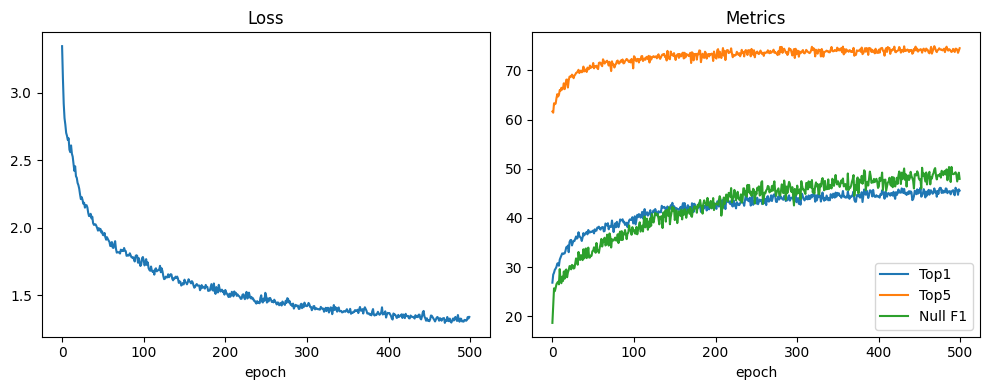

In [26]:
# train_full_with_infonce_null.py
# Full training script with InfoNCE + NULL loss + projector + normalization

import os
import json
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data

# -------------------------
# ====== CONFIG ===========
# -------------------------
CONFIG = {
    "xt_path": r"C:\\Users\Z0054udc\\Downloads\\Siamese GNN\\XT_merged_new1_doubled_fixed.json",  # <- change as needed
    "use_features": list(range(4)),   # which columns to use (first-k)
    "proj_dim": 64,                   # projector output dim
    "encoder_hidden": 64,
    "encoder_out": 32,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "epochs": 500,
    "grad_accum_steps": 8,
    "temperature": 0.1,
    "null_margin": 0.2,               # desired max sim for NULL anchors
    "null_weight": 0.5,
    "device": "cpu",
    "seed": 42,
    "save_path": "siamese_infonce_null.pt",
}
# -------------------------

torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

# -------------------------
# Dataset (loads whole JSON, precomputes normalization stats)
# -------------------------
class SingleFileEmbeddingPairDataset(Dataset):
    def __init__(self, json_path, feature_idx=None, preload_stats=True):
        super().__init__(os.path.dirname(json_path))
        with open(json_path, "r") as f:
            self.data = json.load(f)
        # list of model keys (keep deterministic order)
        self.keys = sorted(self.data.keys(), key=lambda x: int(x))
        self.feature_idx = feature_idx if feature_idx is not None else list(range(4))

        # Precompute normalization stats across dataset (per-feature mean/std)
        # We compute on combined A+B embeddings
        all_feats = []
        for key in self.keys:
            p = self.data[key]
            for aid, vec in p.get("A_embeddings", {}).items():
                all_feats.append(vec)
            for bid, vec in p.get("B_embeddings", {}).items():
                all_feats.append(vec)
        if len(all_feats) == 0:
            raise ValueError("No embeddings found in JSON")
        arr = np.array(all_feats, dtype=np.float64)[:, self.feature_idx].astype(np.float32)
        self.feat_mean = torch.from_numpy(arr.mean(axis=0)).float()
        self.feat_std = torch.from_numpy(arr.std(axis=0) + 1e-9).float()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        pair = self.data[key]

        # A
        A_ids = sorted(pair["A_embeddings"].keys(), key=lambda x: int(x))
        xA = torch.tensor([pair["A_embeddings"][aid] for aid in A_ids], dtype=torch.float)[:, self.feature_idx]
        # B
        B_ids = sorted(pair["B_embeddings"].keys(), key=lambda x: int(x))
        xB = torch.tensor([pair["B_embeddings"][bid] for bid in B_ids], dtype=torch.float)[:, self.feature_idx]

        # Normalize per-feature using dataset stats (z-score)
        xA = (xA - self.feat_mean) / self.feat_std
        xB = (xB - self.feat_mean) / self.feat_std

        # Edges -> convert id pairs to indices (ids in JSON are numeric ids)
        def convert_edges(edge_list, id_list):
            id_to_idx = {int(id_): i for i, id_ in enumerate(id_list)}
            edges = []
            for a, b in edge_list:
                if (a is None) or (b is None): 
                    continue
                if int(a) in id_to_idx and int(b) in id_to_idx:
                    ai = id_to_idx[int(a)]; bi = id_to_idx[int(b)]
                    edges.append([ai, bi]); edges.append([bi, ai])
            if not edges:
                return torch.empty((2, 0), dtype=torch.long)
            return torch.tensor(edges, dtype=torch.long).t().contiguous()

        A_edges_raw = pair.get("A_edges", [])
        B_edges_raw = pair.get("B_edges", [])
        edge_indexA = convert_edges(A_edges_raw, A_ids)
        edge_indexB = convert_edges(B_edges_raw, B_ids)

        # Build mapping tensor: convert entity id strings -> indices in sorted lists
        A_id_to_idx = {int(aid): i for i, aid in enumerate(A_ids)}
        B_id_to_idx = {int(bid): i for i, bid in enumerate(B_ids)}
        mappings = []
        for a, b in pair.get("mappings", []):
            idx_a = -1 if a == "NULL" else A_id_to_idx.get(int(a), -1)
            idx_b = -1 if b == "NULL" else B_id_to_idx.get(int(b), -1)
            mappings.append([idx_a, idx_b])
        matches = torch.tensor(mappings, dtype=torch.long)

        dataA = Data(x=xA, edge_index=edge_indexA, xt_entity_ids=A_ids)
        dataB = Data(x=xB, edge_index=edge_indexB, xt_entity_ids=B_ids)
        return dataA, dataB, matches

# -------------------------
# Model: Graph encoder + projector
# -------------------------
from torch_geometric.nn import SAGEConv

class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)
    def forward(self, x, edge_index):
        # edge_index might be empty shape (2,0) -> SAGEConv expects LongTensor; PyG will handle empty
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

class SiameseGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, proj_dim=64):
        super().__init__()
        self.encoder = GraphEncoder(in_dim, hidden_dim, out_dim)
        self.projector = nn.Sequential(
            nn.Linear(out_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )
    def forward(self, data1, data2):
        h1 = self.encoder(data1.x, data1.edge_index)
        h2 = self.encoder(data2.x, data2.edge_index)
        z1 = F.normalize(self.projector(h1), dim=1)
        z2 = F.normalize(self.projector(h2), dim=1)
        # Also return normalized encoder outputs (optional) for other uses
        return F.normalize(h1, dim=1), F.normalize(h2, dim=1), z1, z2

# -------------------------
# Losses: InfoNCE (vectorized) + NULL penalty
# -------------------------
def info_nce_loss_vectorized(z1, z2, matches_pos, temperature=0.1):
    """
    z1: [N1, D], z2: [N2, D], matches_pos: [K,2] (indices)
    Computes cross-entropy over z2 candidates for anchors present in matches_pos.
    """
    if matches_pos.numel() == 0:
        return (z1.sum() * 0.0) + (z2.sum() * 0.0)
    device = z1.device
    sims = torch.matmul(z1, z2.t()) / temperature  # [N1, N2]
    anchors = matches_pos[:, 0].long().to(device)
    targets = matches_pos[:, 1].long().to(device)
    logits = sims[anchors]           # [K, N2]
    loss = F.cross_entropy(logits, targets)
    return loss

def null_penalty_loss(z_null, z_other, null_margin=0.2):
    """
    For anchors that should be NULL, penalize if max similarity to other side exceeds null_margin.
    z_null: [M, D], z_other: [N, D] (both normalized).
    """
    if z_null.numel() == 0:
        return torch.tensor(0.0, device=z_other.device)
    sims = torch.matmul(z_null, z_other.t())  # [M, N]
    max_sim, _ = sims.max(dim=1)              # [M]
    # penalize values above margin; softplus gives smooth penalty
    return F.softplus(max_sim - null_margin).mean()

# -------------------------
# Helpers: negatives (device-safe), metrics and threshold estimator
# -------------------------
def get_random_negatives_device(emb1_size, emb2_size, num_neg, device):
    A = torch.randint(0, emb1_size, (num_neg,), device=device)
    B = torch.randint(0, emb2_size, (num_neg,), device=device)
    return torch.stack([A, B], dim=1)

def compute_threshold_from_epoch(z1, z2, matches_pos):
    """
    Compute a simple threshold between pos and null distributions:
    - pos_sims: similarities of true positive pairs
    - null_sims: max similarities for NULL anchors
    Return threshold = (mean_pos + mean_null) / 2 (clamped).
    """
    device = z1.device
    pos_sims = []
    null_max_sims = []
    if matches_pos.numel() > 0:
        ps = (z1[matches_pos[:,0].long()] * z2[matches_pos[:,1].long()]).sum(dim=1).detach().cpu().numpy()
        pos_sims = ps.tolist()
    # identify null anchors in A
    # matches should be full mapping tensor; we will provide matches_pos outside
    # For threshold estimating at training time we will pass matches (not only pos)
    # We'll allow caller to compute pos/null lists directly.
    return pos_sims, null_max_sims

def predict_with_threshold(z1, z2, threshold):
    """
    z1: [N1,D], z2: [N2,D] normalized
    returns preds: LongTensor shape [N1] with predicted index in [0..N2-1] or -1 for NULL
    """
    if z2.shape[0] == 0:
        return torch.full((z1.shape[0],), -1, dtype=torch.long, device=z1.device)
    sims = torch.matmul(z1, z2.t())  # [N1, N2]
    max_sim, max_idx = sims.max(dim=1)
    preds = torch.where(max_sim > threshold, max_idx, torch.full_like(max_idx, -1))
    return preds, max_sim

def compute_metrics_from_preds(preds, matches, k=5):
    """
    preds: [N1] predicted indices or -1
    matches: [K,2] ground-truth index mapping rows (indices refer to 0..N-1)
    Return: top1 (over non-null GT), top5, null_precision, null_recall, null_f1
    """
    # Build mapping dict for GT: anchor_idx -> gt_b_idx (or -1)
    gt_map = {}
    for a, b in matches.tolist():
        gt_map[int(a)] = int(b)

    # Filter valid anchors present in GT keys
    anchors = sorted(gt_map.keys())
    # compute top1 and top5
    tp = 0; total = 0
    top5_tp = 0; top5_total = 0
    null_TP = 0; null_FP = 0; null_FN = 0
    for a in anchors:
        gt_b = gt_map[a]
        pred = int(preds[a].item())
        # If GT is -1 (NULL)
        if gt_b == -1:
            # true positive if pred == -1
            if pred == -1:
                null_TP += 1
            else:
                null_FP += 1
            # count FN if pred != -1? For null, FN is when a null anchor not predicted null: that's counted as FP above, and FN counts as 1 if predicted not null
            if pred != -1:
                null_FN += 1
        else:
            # only consider anchors that have GT > -1 for top1/top5
            total += 1
            if pred == gt_b:
                tp += 1
            # for top5 we need the full sims - caller must provide topk logic. Here we approximate top5 by checking if pred in top5? 
            # We'll compute top5 separately elsewhere (we'll implement a better function below).
    top1 = (tp / total * 100.0) if total > 0 else None
    # Null metrics:
    prec = null_TP / (null_TP + null_FP + 1e-12)
    rec = null_TP / (null_TP + null_FN + 1e-12)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    return top1, (prec*100.0, rec*100.0, f1*100.0)

def compute_top1_top5_and_null(z1, z2, matches, k=5):
    """
    Compute proper Top-1, Top-5 and Null Precision/Recall/F1 for one pair.
    """
    device = z1.device
    preds, max_sim = predict_with_threshold(z1, z2, threshold=-1.0)  # we will ignore threshold for topk computations
    # Build gt lists
    valid_rows = []
    gt_cols = []
    null_anchors = []
    for a, b in matches.tolist():
        if int(b) == -1:
            null_anchors.append(int(a))
        else:
            valid_rows.append(int(a)); gt_cols.append(int(b))
    # Top-1 and top-5 (only on anchors with gt != -1)
    top1 = None; top5 = None
    if len(valid_rows) > 0 and z2.shape[0] > 0:
        dists = torch.cdist(z1, z2)  # since z normalized, cdist monotonic with cosine
        minidx = dists.argmin(dim=1)[valid_rows]
        top1 = (minidx.cpu() == torch.tensor(gt_cols)).float().mean().item()
        actual_k = min(k, z2.shape[0])
        topk = torch.topk(-dists[valid_rows], actual_k, dim=1).indices
        top5 = torch.any(topk == torch.tensor(gt_cols).unsqueeze(1), dim=1).float().mean().item()
    # Null metrics using threshold
    # We'll compute threshold externally when calling this function; so here just return null anchor max sim distribution
    null_max_sims = []
    if len(null_anchors) > 0 and z2.shape[0] > 0:
        sims = torch.matmul(z1[null_anchors], z2.t())
        null_max_sims = sims.max(dim=1).values.cpu().tolist()
    pos_sims = []
    if len(valid_rows) > 0 and z2.shape[0] > 0:
        pos_sims = (z1[valid_rows] * z2[gt_cols]).sum(dim=1).cpu().tolist()
    return top1, top5, pos_sims, null_max_sims

# -------------------------
# Training script
# -------------------------
def train():
    device = torch.device(CONFIG["device"])
    print("Using device:", device)

    dataset = SingleFileEmbeddingPairDataset(CONFIG["xt_path"], feature_idx=CONFIG["use_features"])
    print("Found", len(dataset), "pairs")

    model = SiameseGNN(in_dim=len(CONFIG["use_features"]),
                       hidden_dim=CONFIG["encoder_hidden"],
                       out_dim=CONFIG["encoder_out"],
                       proj_dim=CONFIG["proj_dim"]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=CONFIG["weight_decay"])
    epochs = CONFIG["epochs"]
    grad_accum = CONFIG["grad_accum_steps"]

    loss_hist = []; top1_hist = []; top5_hist = []; null_f1_hist = []

    best_val = -1.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_pairs = 0

        # collect pos/null sim distributions to estimate threshold
        all_pos_sims = []
        all_null_max_sims = []

        optimizer.zero_grad()
        for i in tqdm(range(len(dataset)), desc=f"Epoch {epoch+1}/{epochs}"):
            dataA, dataB, matches = dataset[i]
            dataA = dataA.to(device)
            dataB = dataB.to(device)
            matches = matches.to(device)

            h1, h2, z1, z2 = model(dataA, dataB)
            # matches_pos (valid)
            matches_pos = matches[(matches[:,0] != -1) & (matches[:,1] != -1)]
            # symmetric InfoNCE
            loss_ab = info_nce_loss_vectorized(z1, z2, matches_pos, temperature=CONFIG["temperature"])
            # flip matches for reverse direction
            if matches_pos.numel() > 0:
                matches_pos_rev = matches_pos[:, [1,0]]
                loss_ba = info_nce_loss_vectorized(z2, z1, matches_pos_rev, temperature=CONFIG["temperature"])
            else:
                loss_ba = (z1.sum() * 0.0) + (z2.sum() * 0.0)
            info_loss = 0.5 * (loss_ab + loss_ba)

            # NULL losses
            nullA_idx = matches[matches[:,1] == -1, 0].long()
            nullB_idx = matches[matches[:,0] == -1, 1].long()
            null_loss_A = null_penalty_loss(z1[nullA_idx], z2, null_margin=CONFIG["null_margin"]) if nullA_idx.numel() > 0 else torch.tensor(0.0, device=device)
            null_loss_B = null_penalty_loss(z2[nullB_idx], z1, null_margin=CONFIG["null_margin"]) if nullB_idx.numel() > 0 else torch.tensor(0.0, device=device)
            null_loss = (null_loss_A + null_loss_B) * CONFIG["null_weight"]

            # total
            loss = info_loss + null_loss
            loss = loss / grad_accum   # scale for gradient accumulation
            loss.backward()

            total_loss += loss.item() * grad_accum
            total_pairs += 1

            # accumulate pos/null sim stats
            t1, t5, pos_sims, null_max_sims = compute_top1_top5_and_null(z1, z2, matches, k=5)
            all_pos_sims += pos_sims
            all_null_max_sims += null_max_sims

            # step
            if (i + 1) % grad_accum == 0 or (i + 1) == len(dataset):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()
                optimizer.zero_grad()

        # estimate threshold = midpoint between mean pos and mean null max sims
        mean_pos = np.mean(all_pos_sims) if len(all_pos_sims) > 0 else 0.5
        mean_null = np.mean(all_null_max_sims) if len(all_null_max_sims) > 0 else -0.5
        threshold = float((mean_pos + mean_null) / 2.0)
        # clamp to [-0.9, 0.9]
        threshold = max(min(threshold, 0.9), -0.9)

        # Evaluation pass (compute top1/top5/null metrics averaged)
        model.eval()
        epoch_top1 = []; epoch_top5 = []; epoch_null_prec = []; epoch_null_rec = []; epoch_null_f1 = []
        with torch.no_grad():
            for i in range(len(dataset)):
                dataA, dataB, matches = dataset[i]
                dataA = dataA.to(device); dataB = dataB.to(device); matches = matches.to(device)
                _, _, z1, z2 = model(dataA, dataB)
                # predictions
                preds, max_sim = predict_with_threshold(z1, z2, threshold)
                # compute top1/top5/null metrics properly
                top1, top5, pos_sims, null_max_sims = compute_top1_top5_and_null(z1, z2, matches, k=5)
                # compute null precision/recall/f1 using threshold
                # build GT map
                gt_map = {int(a): int(b) for a,b in matches.tolist()}
                # compute null metrics
                TP = FP = FN = 0
                for a,b in matches.tolist():
                    a = int(a); b = int(b)
                    pred_a = int(preds[a].item())
                    if b == -1:
                        if pred_a == -1: TP += 1
                        else: FN += 1
                    else:
                        # if predicted -1 but gt is not null -> FP for null (wrongly predicted null)
                        if pred_a == -1: FP += 1
                prec = TP / (TP + FP + 1e-12)
                rec = TP / (TP + FN + 1e-12)
                f1 = 2 * prec * rec / (prec + rec + 1e-12) if (prec+rec)>0 else 0.0

                if top1 is not None: epoch_top1.append(top1*100.0)
                if top5 is not None: epoch_top5.append(top5*100.0)
                epoch_null_prec.append(prec*100.0); epoch_null_rec.append(rec*100.0); epoch_null_f1.append(f1*100.0)

        avg_top1 = float(np.mean(epoch_top1)) if len(epoch_top1)>0 else 0.0
        avg_top5 = float(np.mean(epoch_top5)) if len(epoch_top5)>0 else 0.0
        avg_null_f1 = float(np.mean(epoch_null_f1)) if len(epoch_null_f1)>0 else 0.0
        loss_hist.append(total_loss / max(total_pairs,1))
        top1_hist.append(avg_top1)
        top5_hist.append(avg_top5)
        null_f1_hist.append(avg_null_f1)

        print(f"Epoch {epoch+1:03d}  Loss={loss_hist[-1]:.4f}  Top1={avg_top1:.2f}%  Top5={avg_top5:.2f}%  NullF1={avg_null_f1:.2f}%  thr={threshold:.3f}")

        # save best by Top1
        if avg_top1 > best_val:
            best_val = avg_top1
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "config": CONFIG,
            }, CONFIG["save_path"])

    # plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(loss_hist); plt.title("Loss"); plt.xlabel("epoch")
    plt.subplot(1,2,2)
    plt.plot(top1_hist, label="Top1"); plt.plot(top5_hist, label="Top5"); plt.plot(null_f1_hist, label="Null F1")
    plt.legend(); plt.title("Metrics"); plt.xlabel("epoch")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train()
